# Lead Scoring Case Study 

- Supervised Learning Algorithm - Logistic Regression [ Classification ]
- Programming Language - Python
- Developed by UV, VK, VY


## Initialization - Preprocessing - Visualization

### 1. Package Imports and Data Initialization

In [1580]:
%pip install fast_ml    ## Required for constant feature identification package if you dont have fast_ml package then install using this line.

# these are the libraries which will help to identify constant feature.
from fast_ml.utilities import display_all 
from fast_ml.feature_selection import get_constant_features

Note: you may need to restart the kernel to use updated packages.


In [1581]:
# import all libraries numpy, pandas, matplotlib, seaborn. 
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns; sns.set_theme(color_codes=True)

import warnings
warnings.filterwarnings('ignore')

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
%matplotlib inline

# Set custom display properties in pandas
pd.set_option("display.max_rows", 900)
pd.set_option("display.max_columns", 900) 
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [1582]:
# Import the necessary machine learning packages (sklearn, statsmodel) for performing logistic regression
import statsmodels.api as sm 
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler, StandardScaler
from sklearn.metrics import accuracy_score, recall_score,precision_score, roc_auc_score, confusion_matrix, f1_score, roc_curve, precision_recall_curve

In [1583]:
# Importing the dataset from leads.csv
lead_score_df = pd.read_csv('Leads.csv')
lead_score_df.head(1)

Prospect ID  Lead Number Lead Origin Lead Source  \
0  7927b2df-8bba-4d29-b9a2-b6e0beafe620       660737         API  Olark Chat   

  Do Not Email Do Not Call  Converted  TotalVisits  \
0           No          No          0        0.000   

   Total Time Spent on Website  Page Views Per Visit            Last Activity  \
0                            0                 0.000  Page Visited on Website   

  Country Specialization How did you hear about X Education  \
0     NaN         Select                             Select   

  What is your current occupation  \
0                      Unemployed   

  What matters most to you in choosing a course Search Magazine  \
0                       Better Career Prospects     No       No   

  Newspaper Article X Education Forums Newspaper Digital Advertisement  \
0                No                 No        No                    No   

  Through Recommendations Receive More Updates About Our Courses  \
0                      No                                     No   

                          Tags      Lead Quality  \
0  Interested in other courses  Low in Relevance   

  Update me on Supply Chain Content Get updates on DM Content Lead Profile  \
0                                No                        No       Select   

     City Asymmetrique Activity Index Asymmetrique Profile Index  \
0  Select                   02.Medium                  02.Medium   

   Asymmetrique Activity Score  Asymmetrique Profile Score  \
0                       15.000                      15.000   

  I agree to pay the amount through cheque  \
0                                       No   

  A free copy of Mastering The Interview Last Notable Activity  
0                                     No              Modified

In [1584]:
# looking at the information of the dataset
lead_score_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9240 entries, 0 to 9239
Data columns (total 37 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   Prospect ID                                    9240 non-null   object 
 1   Lead Number                                    9240 non-null   int64  
 2   Lead Origin                                    9240 non-null   object 
 3   Lead Source                                    9204 non-null   object 
 4   Do Not Email                                   9240 non-null   object 
 5   Do Not Call                                    9240 non-null   object 
 6   Converted                                      9240 non-null   int64  
 7   TotalVisits                                    9103 non-null   float64
 8   Total Time Spent on Website                    9240 non-null   int64  
 9   Page Views Per Visit                           9103 

###  ----------------------------------------------------------------------

### 2. Data Preprocesing - Part 1

#### Custom Functions for Preprocessing and EDA

In [1585]:
# To distinguish numerical columns either as categorical/discrete or non categorical and return as dict
def classify_feature_dtype(df, cols):
    d_categories = {'int_cat': [], "float_ts":[] }
    for col in cols:
        if (len(df[col].unique()) < 20) and (df[col].dtype != np.float64):
            d_categories['int_cat'].append(col)
        else:
            
            if not isinstance(df[col][df[col].notna()].unique()[0], str):
                d_categories['float_ts'].append(col)
            else:
                d_categories['int_cat'].append(col)
    return d_categories

# Print all statistical information for a given set of columns
def show_stats(df, cols):
    for col in list(cols):
        print("Total Nulls: {0},\nMode: {1}".format(df[col].isna().sum(), df[col].mode()[0]))
        if len(df[col].unique()) < 50:
            print("\nUnique: {0}\n".format(df[col].unique()))
        if (df[col].dtype == int) or (df[col].dtype == float):
            print("Median   : {0}, \nVariance: {1}, \n\nDescribe: {2} \n".format(df[col].median(), df[col].var(), df[col].describe()))
        print("ValueCounts: {0} \n\n\n".format((df[col].value_counts(normalize=True) * 100).head(5)))
        print("------------------------------------------------------------------")

# Return the percentage of null values in each columns in a dataframe
def check_cols_null_pct(df):
    df_non_na = df.count() / len(df)  # Ratio of non null values
    df_na_pct = (1 - df_non_na) * 100 # Find the Percentage of null values
    return df_na_pct.sort_values(ascending=False) # Sort the resulting values in descending order

# Generates charts based on the data type of the cols, as part of the univariate analysis 
# it takes dataframe, columns, train data 0,1, and feature type as args.
def univariate_plots(df, cols, target=None, ftype=None, l_dict = None):
    for col in cols:
        #generate plots and graphs for category type. (generates piechart, countplot, boxplot / if training data is provided it generates bar chart instead)
        if ftype == "categorical":
            fig, axs = plt.subplots(1, 3, figsize=(20, 6))
 
            col_idx = 0
            axs[col_idx].pie(x=df[col].value_counts().head(12), labels=df[col].value_counts().head(12).index.str[:10], autopct="%1.1f%%", 
                    radius=1, textprops={"fontsize": 10, "color": "Black"}, startangle=90, rotatelabels=False, )
            axs[col_idx].set_title("PieChart of {0}".format(col), y=1); plt.xticks(rotation=45); plt.ylabel("Percentage")
            fig.subplots_adjust(wspace=0.5, hspace=0.3)
            
            col_idx += 1
            sns.countplot(data=df, y=col, order=df[col].value_counts().head(15).index, palette="viridis",  ax=axs[col_idx])
            if (l_dict is not None) and (l_dict.get(col) is not None):
                axs[col_idx].legend([ f'{k} - {v}' for k,v in l_dict[col].items()])
            axs[col_idx].set_title("Countplot of {0}".format(col)); plt.xticks(rotation=45); plt.xlabel(col); plt.ylabel("Count")
            fig.subplots_adjust(wspace=0.5, hspace=0.3)

            col_idx += 1
            ax = sns.barplot(data=df, x=df[col].str[:10], y=target, order=df[col].value_counts().index.str[:10], palette="viridis",  ax=axs[col_idx], errwidth=0)
            for i in ax.containers:
                ax.bar_label(i,)
            axs[col_idx].set_title('Barplot against target'); plt.xticks(rotation=90); plt.xlabel(col)
            fig.subplots_adjust(wspace=0.5, hspace=0.3)

            plt.suptitle("Univariate analysis of {0}".format(col), fontsize=12, y=0.95)
            plt.tight_layout()
            plt.subplots_adjust(top=0.85)
            plt.show();
            plt.clf()

        #generate plots and graphs for numerical types. (generates boxplot, histplot, kdeplot, scatterplot)
        elif ftype == "non_categorical":        
            fig, axs = plt.subplots(1, 4, figsize=(20, 6))
            
            col_idx = 0
            
            sns.boxplot(data=df, y=col, palette="viridis", flierprops=dict(marker="o", markersize=6, markerfacecolor="red", markeredgecolor="black"),
                        medianprops=dict(linestyle="-", linewidth=3, color="#FF9900"), whiskerprops=dict(linestyle="-", linewidth=2, color="black"),
                        capprops=dict(linestyle="-", linewidth=2, color="black"), ax=axs[col_idx])
            axs[col_idx].set_title("Boxplot of {0}".format(col)); plt.xticks(rotation=45); plt.xlabel(col)
            fig.subplots_adjust(wspace=0.5, hspace=0.3)
            
            col_idx += 1

            axs[col_idx].hist(data=df, x=col, label=col)
            axs[col_idx].set_title("Histogram of {0}".format(col)); plt.xticks(rotation=45); plt.xlabel(col)
            fig.subplots_adjust(wspace=0.5, hspace=0.3)
            
            col_idx += 1

            sns.kdeplot(df[col], shade=True, ax=axs[col_idx])
            axs[col_idx].set_title("KDE plot of {0}".format(col)); plt.xticks(rotation=45); plt.xlabel(col)
            fig.subplots_adjust(wspace=0.5, hspace=0.3)
            
            col_idx += 1

            sns.scatterplot(df[col], ax=axs[col_idx])
            axs[col_idx].set_title("Scatterplot of {0}".format(col)); plt.xticks(rotation=45); plt.xlabel(col)
            fig.subplots_adjust(wspace=0.5, hspace=0.3)

            plt.suptitle("Univariate analysis of {0}".format(col), fontsize=12, y=0.95)
            plt.tight_layout()
            plt.subplots_adjust(top=0.85)
            plt.show()
            plt.clf()

# Perform Outlier analysis on the given dataframe.
# Find Lower threshold, Upper threshold and IQR values. 
# Return the Result as a dataframe. 
# find_outlier = True argument: restricts the output df to outlier columns. whereas find_outlier = False: returns results for all columns
def get_extremeval_threshld(df, find_outlier=False):
    outlier_df = pd.DataFrame(columns=[i for i in df.columns if find_outlier == True], data=None)
    
    for col in df.columns:
        thirdq, firstq = df[col].quantile(0.75), df[col].quantile(0.25)
        iqr = 1.5 * (thirdq - firstq)
        extvalhigh, extvallow = iqr + thirdq, firstq - iqr
        
        if find_outlier == True:
            dfout = df.loc[(df[col] > extvalhigh) | (df[col] < extvallow)]
            dfout = dfout.assign(name=col, thresh_low=extvallow, thresh_high=extvalhigh)
        else:
            dfout = pd.DataFrame([[col, extvallow, extvalhigh]], columns=['name', 'thresh_low', 'thresh_high'])
            
        outlier_df = pd.concat([outlier_df, dfout])
    # outlier_df = outlier_df.reset_index(drop=True)
    outlier_df = outlier_df.set_index('name',drop=True)
    return outlier_df

#### Data Cleaning, Column Renaming, Missing Value Imputation, Feature Selection

In [1586]:
#duplicates row validation by id cols
print(f"{lead_score_df.index.is_unique}, {lead_score_df.columns.is_unique}, {lead_score_df['Prospect ID'].is_unique}, {lead_score_df['Lead Number'].is_unique}")

True, True, True, True


In [1587]:
# drop unnecessary columns
lead_score_df = lead_score_df.drop(columns=['Prospect ID','Lead Number', 'I agree to pay the amount through cheque', 'Last Notable Activity'])

In [1588]:
# rename columns that are too long
lead_score_df = lead_score_df.rename(columns={'Total Time Spent on Website':'ttime_on_site', 'Page Views Per Visit':'pg_view_pv', 'How did you hear about X Education':'info_abt_X_Edu', 'What is your current occupation':'curr_occupation',
    'What matters most to you in choosing a course':'reason_behind_course', 'Receive More Updates About Our Courses':'more_course_updates', 'Update me on Supply Chain Content':'supply_chain_info', 'Get updates on DM Content':'get_dm',
    'Asymmetrique Activity Index':'asym_activ_idx', 'Asymmetrique Profile Index':'asym_prof_idx', 'Asymmetrique Activity Score':'asym_activ_score', 'Asymmetrique Profile Score':'asym_prof_score',
    'A free copy of Mastering The Interview':'avail_free_copy'})

In [1589]:
# replace unnecessary space in columns with underscore and covert it to lower case
lead_score_df.columns = lead_score_df.columns.str.replace(pat=' ',repl='_', regex=True)
lead_score_df.columns = lead_score_df.columns.str.lower()

In [1590]:
# Check the shape and size of the data frame
lead_score_df.head(1)
lead_score_df.dtypes

lead_origin lead_source do_not_email do_not_call  converted  totalvisits  \
0         API  Olark Chat           No          No          0        0.000   

   ttime_on_site  pg_view_pv            last_activity country specialization  \
0              0       0.000  Page Visited on Website     NaN         Select   

  info_abt_x_edu curr_occupation     reason_behind_course search magazine  \
0         Select      Unemployed  Better Career Prospects     No       No   

  newspaper_article x_education_forums newspaper digital_advertisement  \
0                No                 No        No                    No   

  through_recommendations more_course_updates                         tags  \
0                      No                  No  Interested in other courses   

       lead_quality supply_chain_info get_dm lead_profile    city  \
0  Low in Relevance                No     No       Select  Select   

  asym_activ_idx asym_prof_idx  asym_activ_score  asym_prof_score  \
0      02.Medium     02.Medium            15.000           15.000   

  avail_free_copy  
0              No

lead_origin                 object
lead_source                 object
do_not_email                object
do_not_call                 object
converted                    int64
totalvisits                float64
ttime_on_site                int64
pg_view_pv                 float64
last_activity               object
country                     object
specialization              object
info_abt_x_edu              object
curr_occupation             object
reason_behind_course        object
search                      object
magazine                    object
newspaper_article           object
x_education_forums          object
newspaper                   object
digital_advertisement       object
through_recommendations     object
more_course_updates         object
tags                        object
lead_quality                object
supply_chain_info           object
get_dm                      object
lead_profile                object
city                        object
asym_activ_idx      

In [1591]:
print(f'{lead_score_df.shape}, {lead_score_df.size}')

(9240, 33), 304920


In [1592]:
# check null val percentage
# After checking the null value percentage for all the features
# We could see that there are many features that have more than 45% of non values

null_pct = check_cols_null_pct(lead_score_df)
null_pct[null_pct > 0]

lead_quality           51.591
asym_prof_score        45.649
asym_activ_score       45.649
asym_prof_idx          45.649
asym_activ_idx         45.649
tags                   36.288
lead_profile           29.318
reason_behind_course   29.318
curr_occupation        29.113
country                26.634
info_abt_x_edu         23.885
specialization         15.563
city                   15.368
pg_view_pv              1.483
totalvisits             1.483
last_activity           1.115
lead_source             0.390
dtype: float64

In [1593]:
# checking all the values under Tags and specialization
show_stats(lead_score_df,['tags','specialization'])

Total Nulls: 3353,
Mode: Will revert after reading the email

Unique: ['Interested in other courses' 'Ringing'
 'Will revert after reading the email' nan 'Lost to EINS'
 'In confusion whether part time or DLP' 'Busy' 'switched off'
 'in touch with EINS' 'Already a student' 'Diploma holder (Not Eligible)'
 'Graduation in progress' 'Closed by Horizzon' 'number not provided'
 'opp hangup' 'Not doing further education' 'invalid number'
 'wrong number given' 'Interested  in full time MBA' 'Still Thinking'
 'Lost to Others' 'Shall take in the next coming month' 'Lateral student'
 'Interested in Next batch' 'Recognition issue (DEC approval)'
 'Want to take admission but has financial problems'
 'University not recognized']

ValueCounts: tags
Will revert after reading the email   35.196
Ringing                               20.435
Interested in other courses            8.714
Already a student                      7.899
Closed by Horizzon                     6.081
Name: proportion, dtype: float

In [1594]:
# replacing select and imputing null value of the tags and specialization column as unknown
lead_score_df[['tags','specialization']] = lead_score_df[['tags','specialization']].replace(to_replace=['select','Select',np.nan], value='unknown') ###--------------------->>>>>>>>>>>>>>>

# replace select string with nan for apart from tags and specialization column.
lead_score_df = lead_score_df.replace(to_replace=['select','Select'], value=np.nan) 

# validate select str is replaced 
[i for i in lead_score_df.columns if 'select' in (lead_score_df[i].astype(str).str.lower()).str.findall('select').value_counts().index.map(''.join).to_list()]

[]

##### Constant Feature Identification

In [1595]:
# check constant features that has only one values
# In the given data set there are a lot of features that have only single value as a category
# These are called as constant features and these features are of little relevance for the machine learning model hence we dropped those features

constant_features = get_constant_features(lead_score_df)
constant_features.head(10)
"','".join(constant_features['Var'].to_list())

Desc                      Var Value    Perc
0        Constant                 magazine    No 100.000
1        Constant      more_course_updates    No 100.000
2        Constant        supply_chain_info    No 100.000
3        Constant                   get_dm    No 100.000
4  Quasi Constant       x_education_forums    No  99.989
5  Quasi Constant                newspaper    No  99.989
6  Quasi Constant              do_not_call    No  99.978
7  Quasi Constant        newspaper_article    No  99.978
8  Quasi Constant    digital_advertisement    No  99.957
9  Quasi Constant  through_recommendations    No  99.924

"magazine','more_course_updates','supply_chain_info','get_dm','x_education_forums','newspaper','do_not_call','newspaper_article','digital_advertisement','through_recommendations','search"

In [1596]:
# seeing the values of reason_behind_course column
lead_score_df['reason_behind_course'].value_counts(normalize=True)*100
# since this has also almost same value means constant value then we will drop this column too

reason_behind_course
Better Career Prospects     99.954
Flexibility & Convenience    0.031
Other                        0.015
Name: proportion, dtype: float64

#####

In [1597]:
# dropping all the constant_features
lead_score_df = lead_score_df.drop(['magazine', 'more_course_updates', 'supply_chain_info', 'get_dm', 'x_education_forums', 
                                    'newspaper', 'do_not_call', 'newspaper_article', 'digital_advertisement', 'through_recommendations', 'search','reason_behind_course'], axis=1)

In [1598]:
# convert dtypes
# Convert the data type of certain features from object to category type

obj_cols = lead_score_df.select_dtypes(include='object').columns
lead_score_df[obj_cols] = lead_score_df[obj_cols].astype(dtype='category')

In [1599]:
# check null val percentage
# Since we have replaced select as null value for certain columns we are seeing increase in the null value percentage for those features
# Therefore we dropped all the features that have more than 40 of null values

null_pct = check_cols_null_pct(lead_score_df)
null_pct[null_pct > 0]
lead_score_df = lead_score_df.drop(null_pct[null_pct > 40].index, axis=1)

info_abt_x_edu     78.463
lead_profile       74.188
lead_quality       51.591
asym_prof_score    45.649
asym_activ_score   45.649
asym_prof_idx      45.649
asym_activ_idx     45.649
city               39.708
curr_occupation    29.113
country            26.634
totalvisits         1.483
pg_view_pv          1.483
last_activity       1.115
lead_source         0.390
dtype: float64

In [1600]:
# checking the columns again whos having more than 0% of null values
null_pct = check_cols_null_pct(lead_score_df)
null_pct[null_pct > 0]
na_cols = null_pct[null_pct > 0].index
na_cols

city              39.708
curr_occupation   29.113
country           26.634
totalvisits        1.483
pg_view_pv         1.483
last_activity      1.115
lead_source        0.390
dtype: float64

Index(['city', 'curr_occupation', 'country', 'totalvisits', 'pg_view_pv',
       'last_activity', 'lead_source'],
      dtype='object')

In [1601]:
lead_score_df.describe(include=np.number)
lead_score_df.describe(exclude=np.number)

converted  totalvisits  ttime_on_site  pg_view_pv
count   9240.000     9103.000       9240.000    9103.000
mean       0.385        3.445        487.698       2.363
std        0.487        4.855        548.021       2.161
min        0.000        0.000          0.000       0.000
25%        0.000        1.000         12.000       1.000
50%        0.000        3.000        248.000       2.000
75%        1.000        5.000        936.000       3.000
max        1.000      251.000       2272.000      55.000

lead_origin lead_source do_not_email last_activity  \
count                      9240        9204         9240          9137   
unique                        5          21            2            17   
top     Landing Page Submission      Google           No  Email Opened   
freq                       4886        2868         8506          3437   

       country specialization curr_occupation     tags    city avail_free_copy  
count     6779           9240            6550     9240    5571            9240  
unique      38             19               6       27       6               2  
top      India        unknown      Unemployed  unknown  Mumbai              No  
freq      6492           3380            5600     3353    3222            6352

In [1602]:
# impute missing categorical values using mode, if a particular value in that column has higher frequency say > 50%
for i in lead_score_df.select_dtypes(include='category'):
    temp = lead_score_df[i].value_counts(normalize=True, ascending=False) * 100
    if temp.iloc[0] > 50:
        print(i)
        lead_score_df[i] = lead_score_df[i].fillna(temp.index[0])

lead_origin
do_not_email
country
curr_occupation
city
avail_free_copy


In [1603]:
# Now there are only two columns that have more than 36 off missing values tags and specialization

null_pct = check_cols_null_pct(lead_score_df)
null_pct[null_pct > 0]

totalvisits     1.483
pg_view_pv      1.483
last_activity   1.115
lead_source     0.390
dtype: float64

In [1604]:
# seeing stats of df
show_stats(lead_score_df, lead_score_df.columns) 

Total Nulls: 0,
Mode: Landing Page Submission

Unique: ['API', 'Landing Page Submission', 'Lead Add Form', 'Lead Import', 'Quick Add Form']
Categories (5, object): ['API', 'Landing Page Submission', 'Lead Add Form', 'Lead Import', 'Quick Add Form']

ValueCounts: lead_origin
Landing Page Submission   52.879
API                       38.745
Lead Add Form              7.771
Lead Import                0.595
Quick Add Form             0.011
Name: proportion, dtype: float64 



------------------------------------------------------------------
Total Nulls: 36,
Mode: Google

Unique: ['Olark Chat', 'Organic Search', 'Direct Traffic', 'Google', 'Referral Sites', ..., 'welearnblog_Home', 'youtubechannel', 'testone', 'Press_Release', 'NC_EDM']
Length: 22
Categories (21, object): ['Click2call', 'Direct Traffic', 'Facebook', 'Google', ..., 'google', 'testone', 'welearnblog_Home', 'youtubechannel']

ValueCounts: lead_source
Google           31.160
Direct Traffic   27.629
Olark Chat       19.068
Orga

###  ----------------------------------------------------------------------

### 3. Data Visualization - EDA

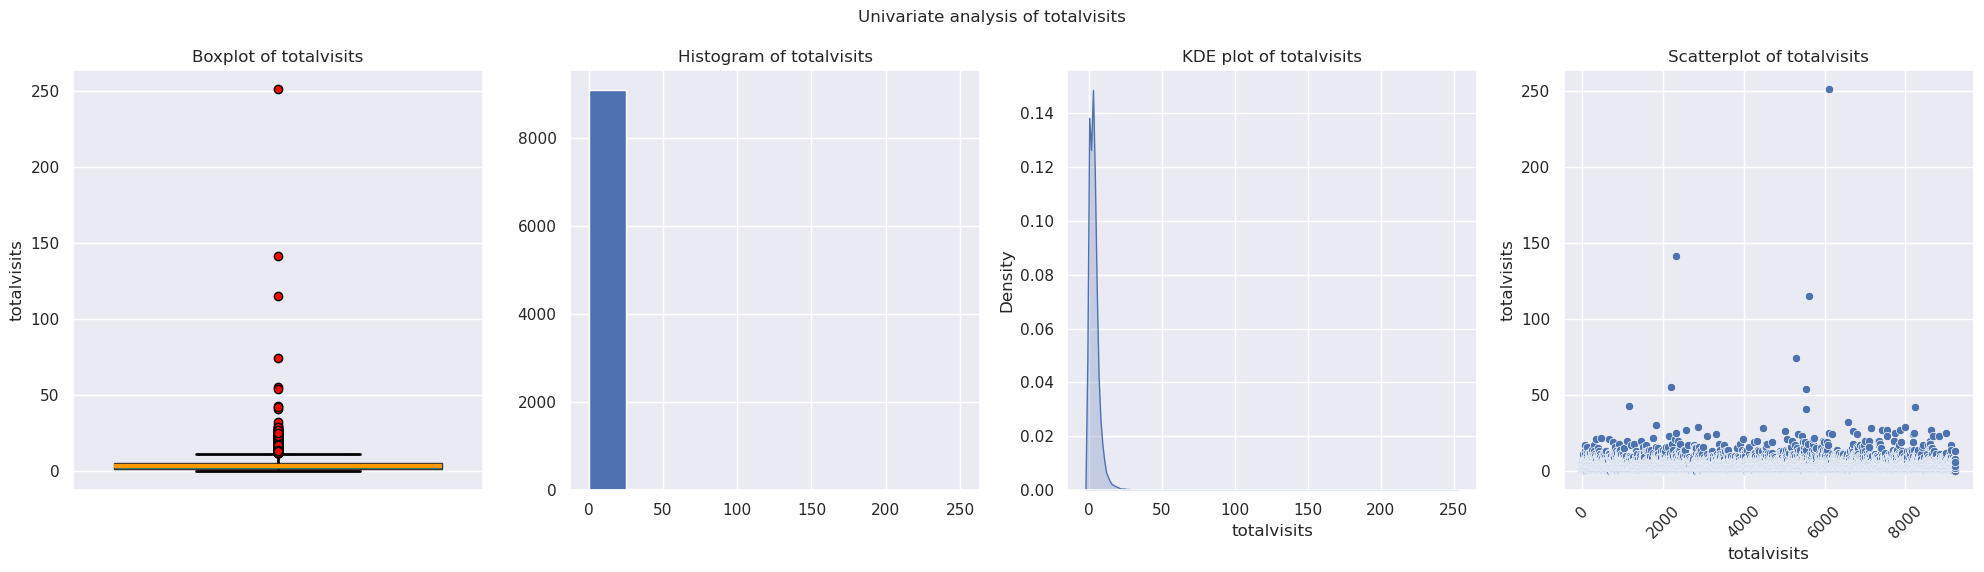

<Figure size 640x480 with 0 Axes>

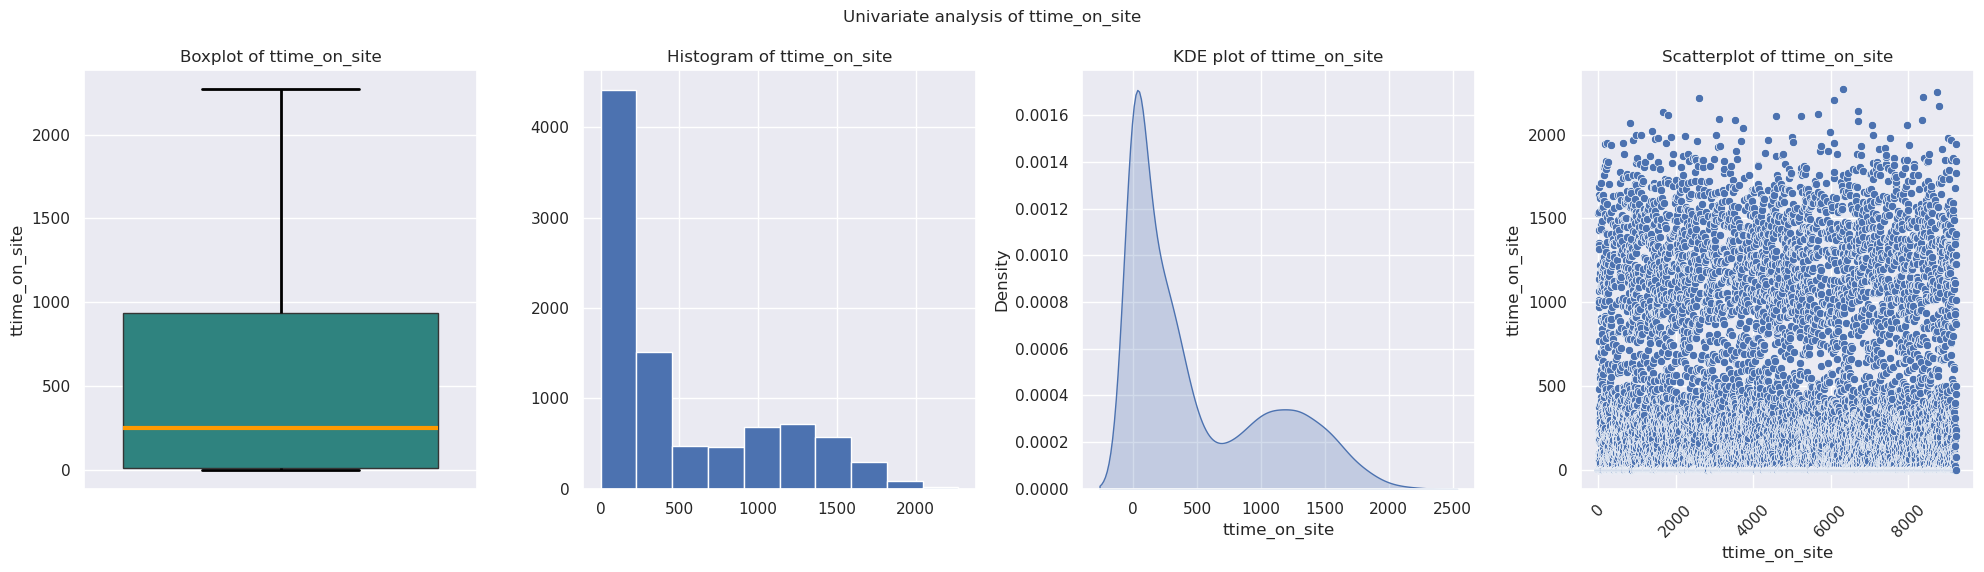

<Figure size 640x480 with 0 Axes>

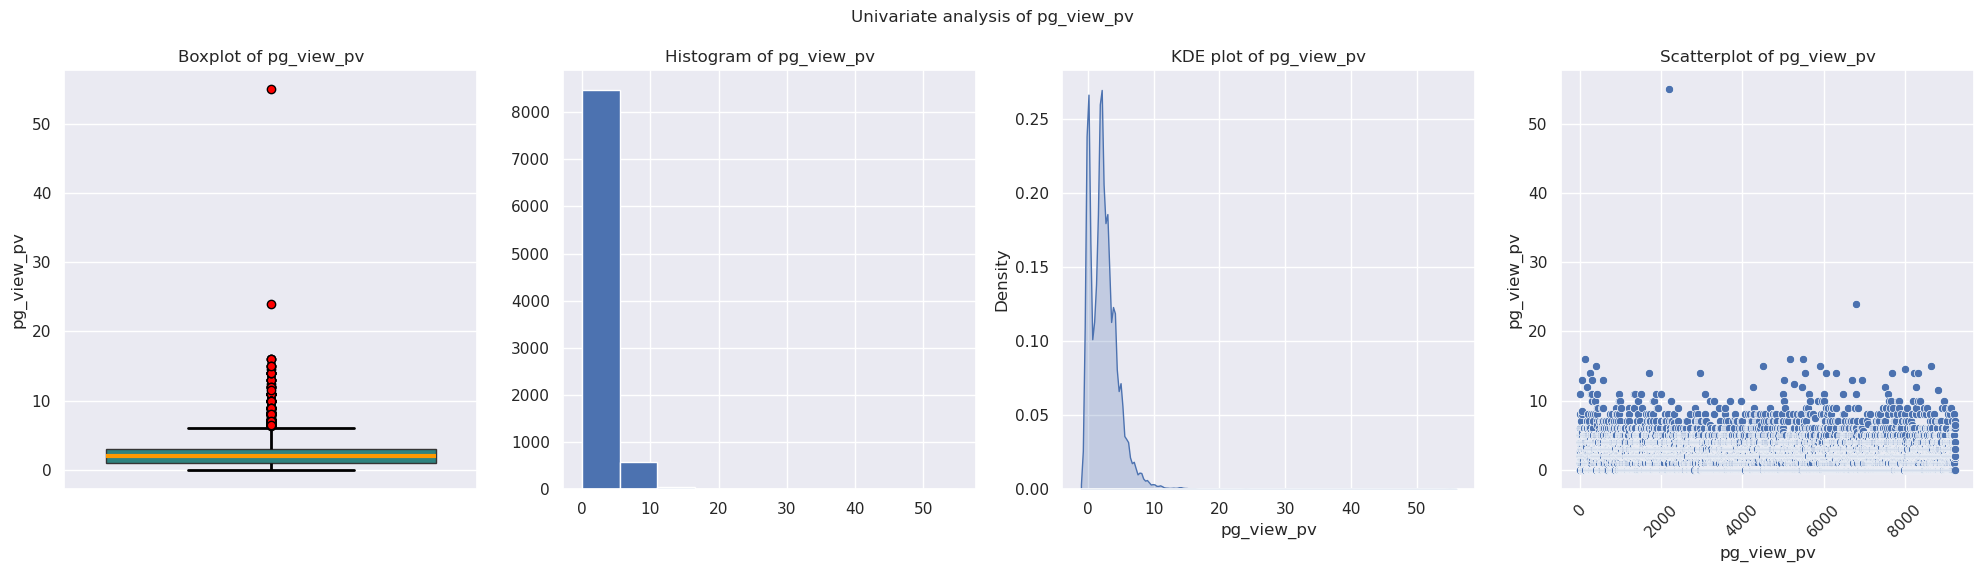

<Figure size 640x480 with 0 Axes>

In [1605]:
# univariate plots#
# Now we perform Univariate analysis on both categorical and numerical variables
dtype_dict = classify_feature_dtype(lead_score_df, lead_score_df.columns )
univariate_plots(lead_score_df, dtype_dict['float_ts'], ftype='non_categorical', target='converted')

#####  Observations

- The converter column has more ones than zeros
- The box plot for total visits shows that there are outliers and the majority of the total visits fall between 0 and 30
- The box plot for page view per visit shows that there are outliers majority of them fall between 0 and 20

#####

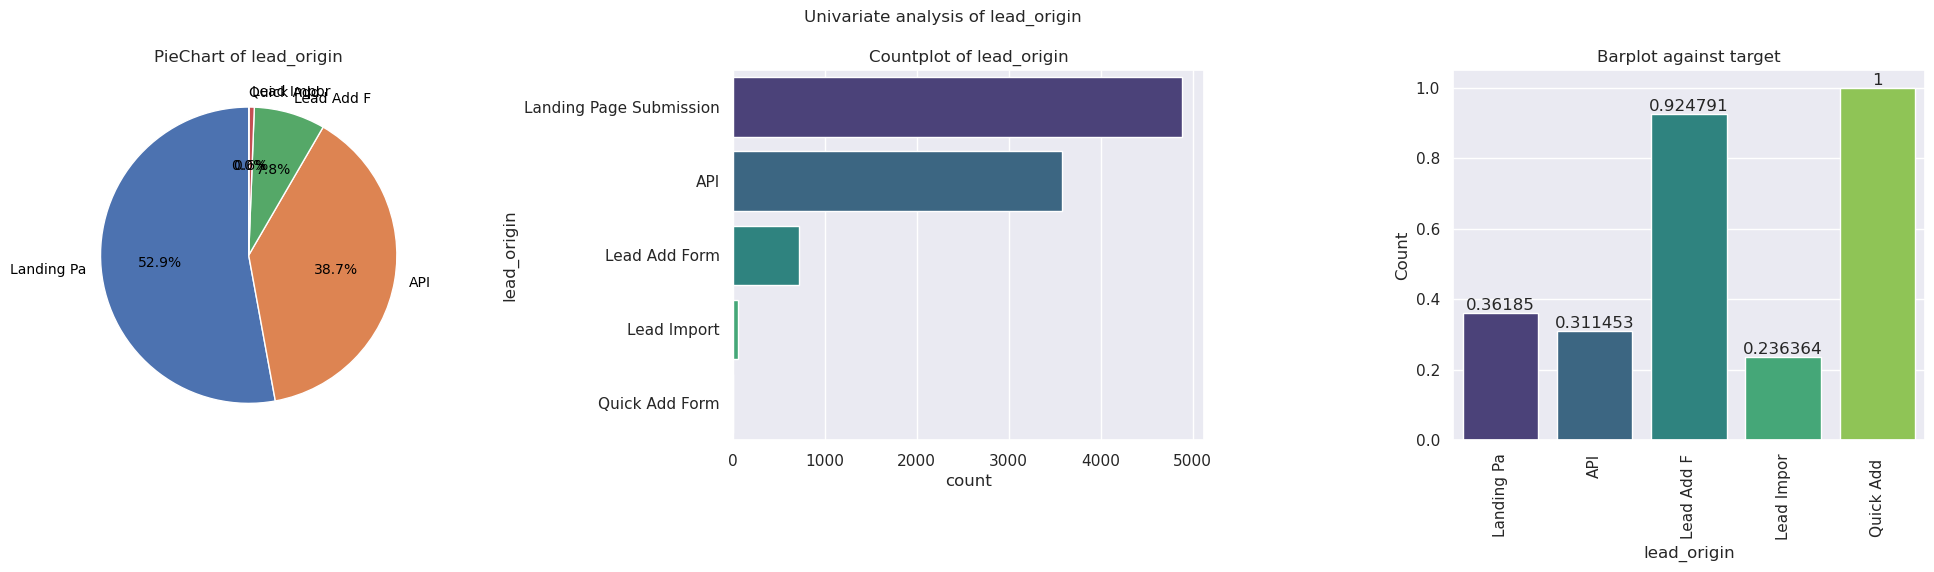

<Figure size 640x480 with 0 Axes>

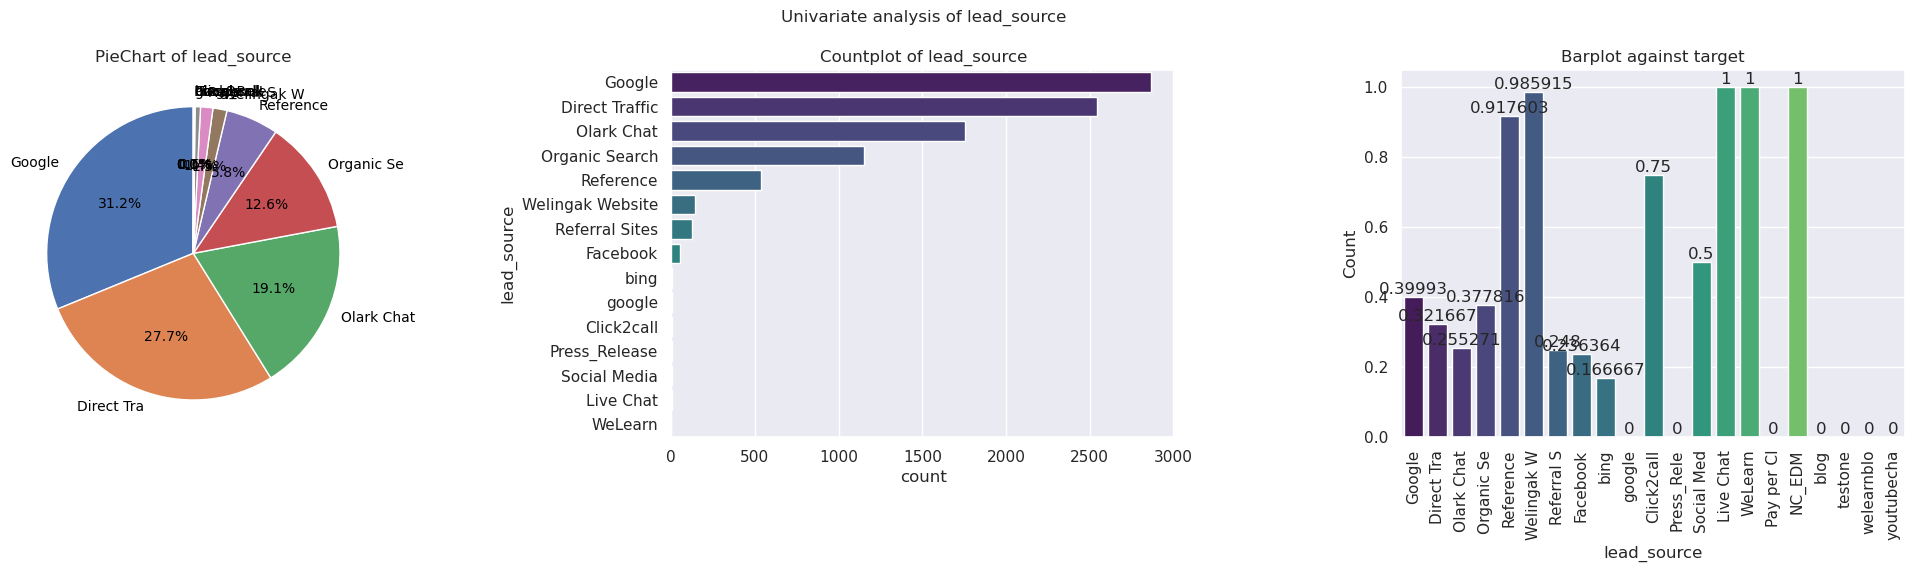

<Figure size 640x480 with 0 Axes>

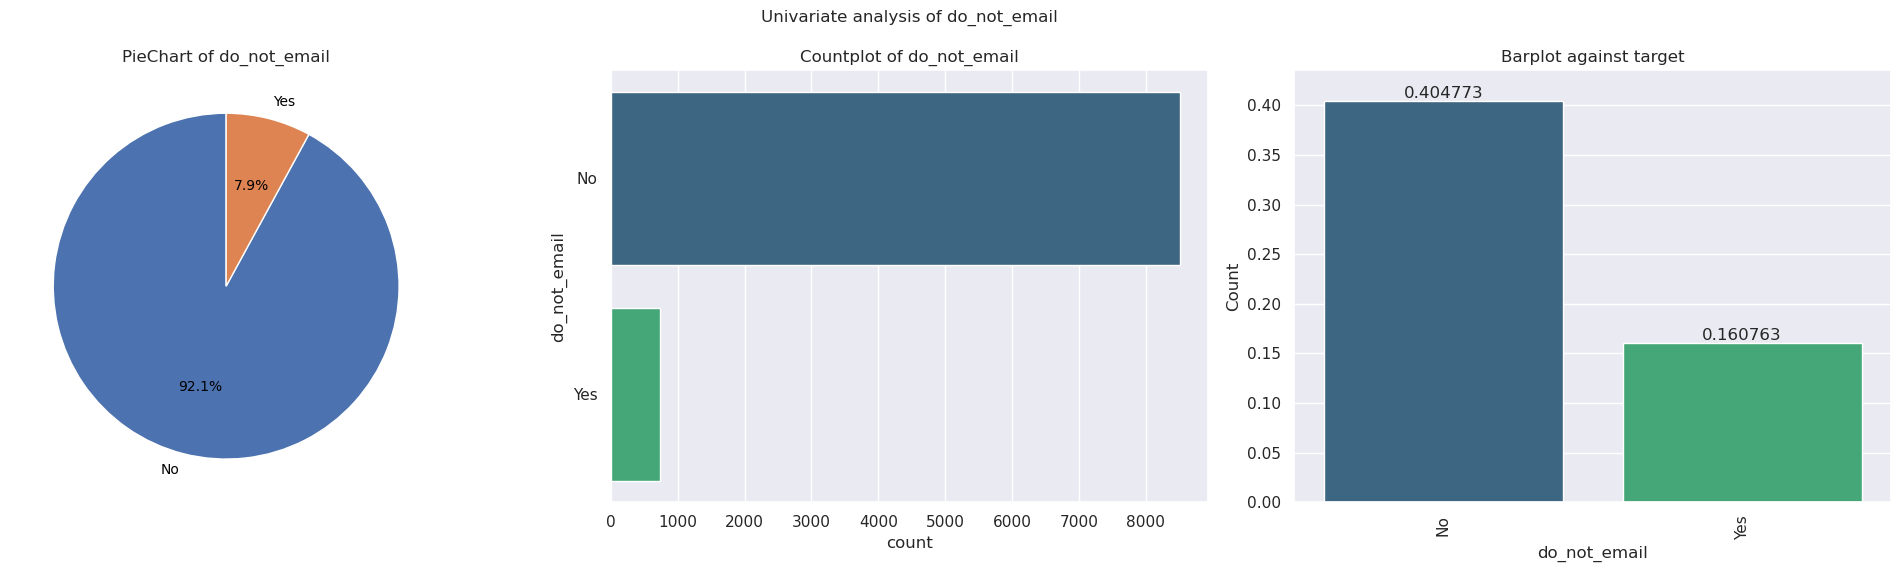

<Figure size 640x480 with 0 Axes>

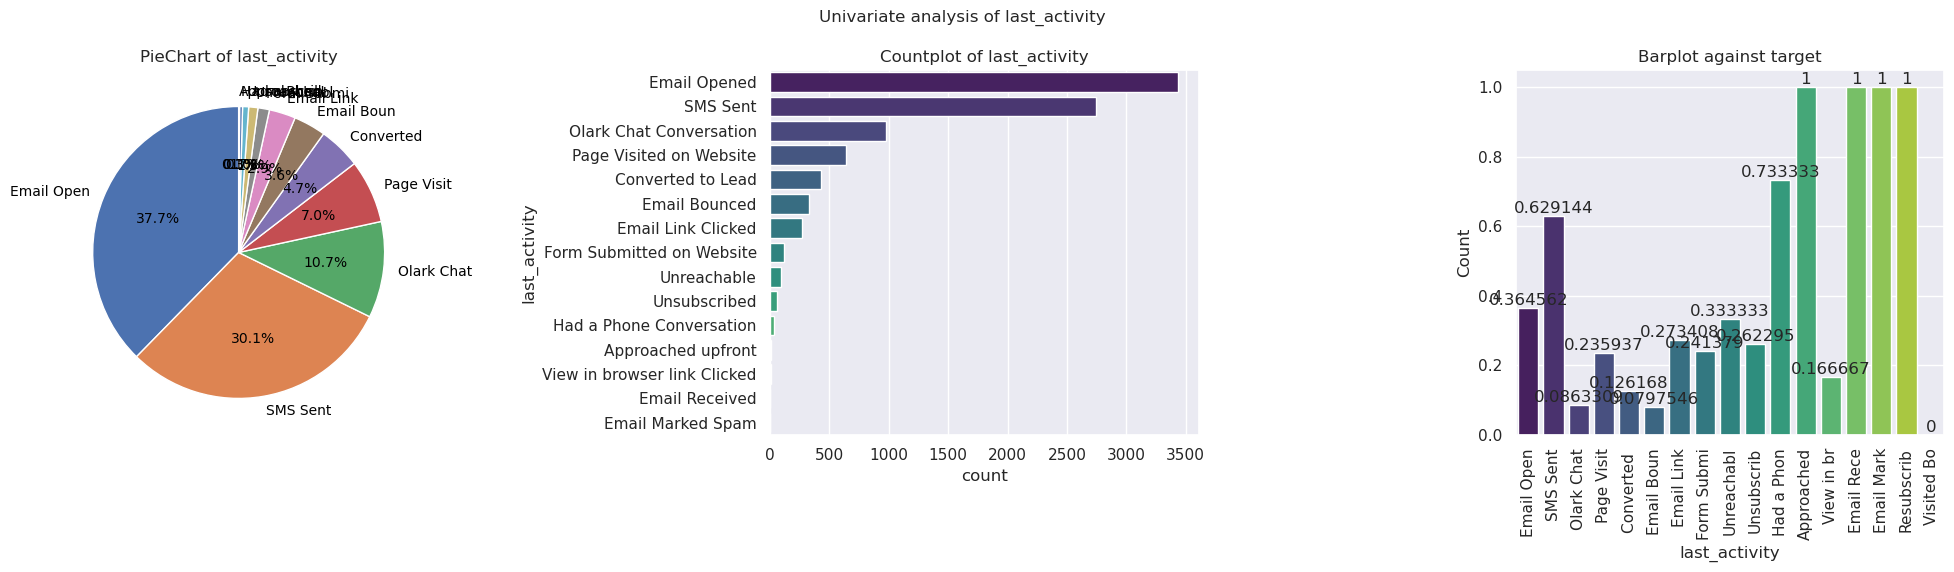

<Figure size 640x480 with 0 Axes>

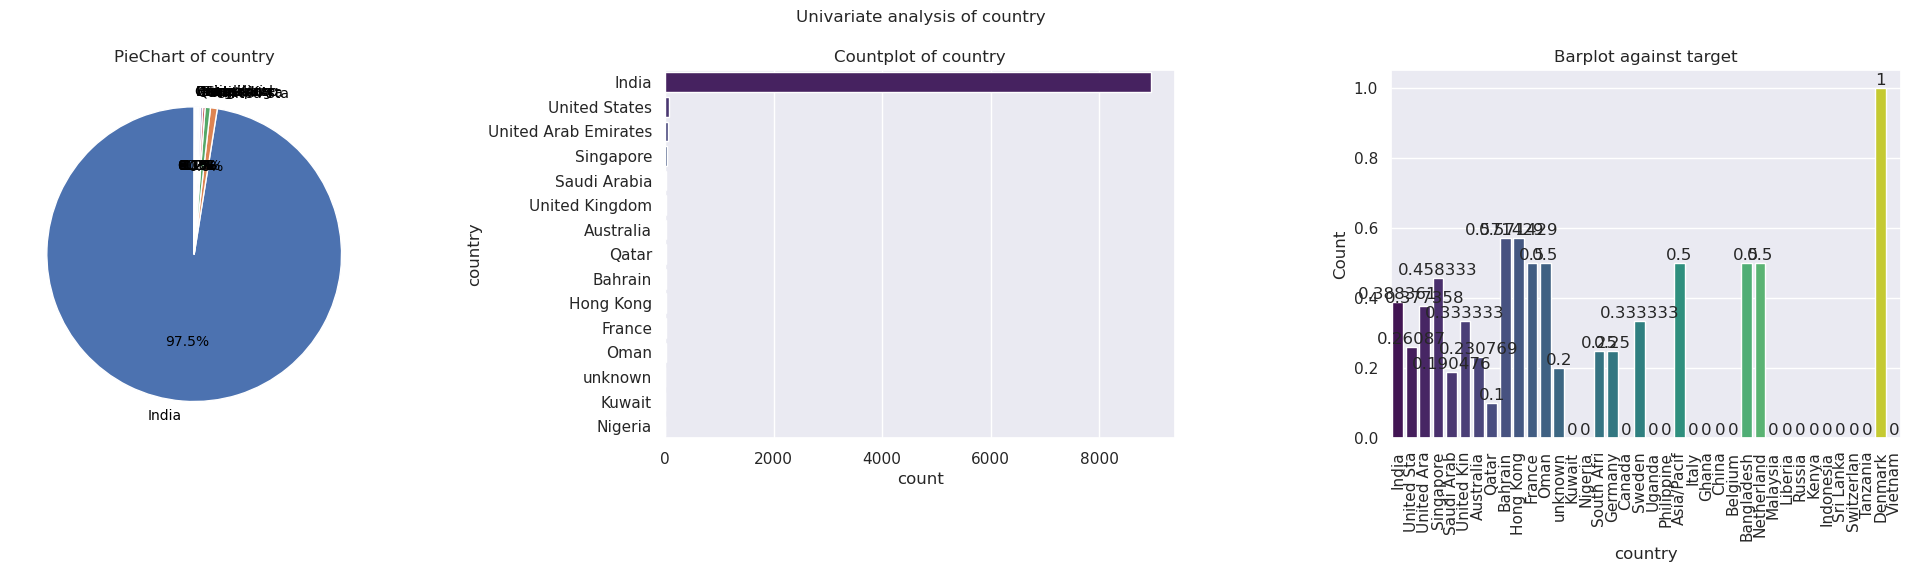

<Figure size 640x480 with 0 Axes>

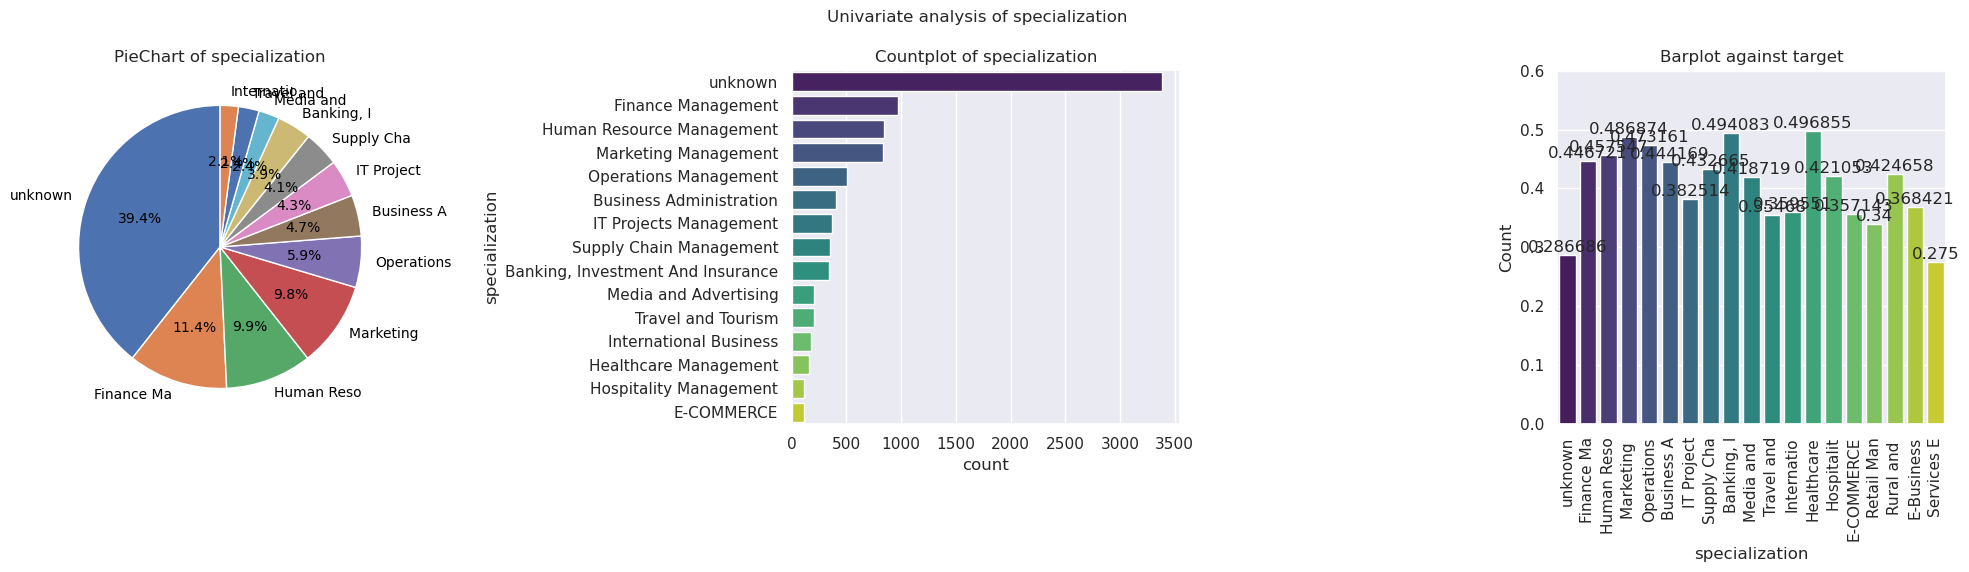

<Figure size 640x480 with 0 Axes>

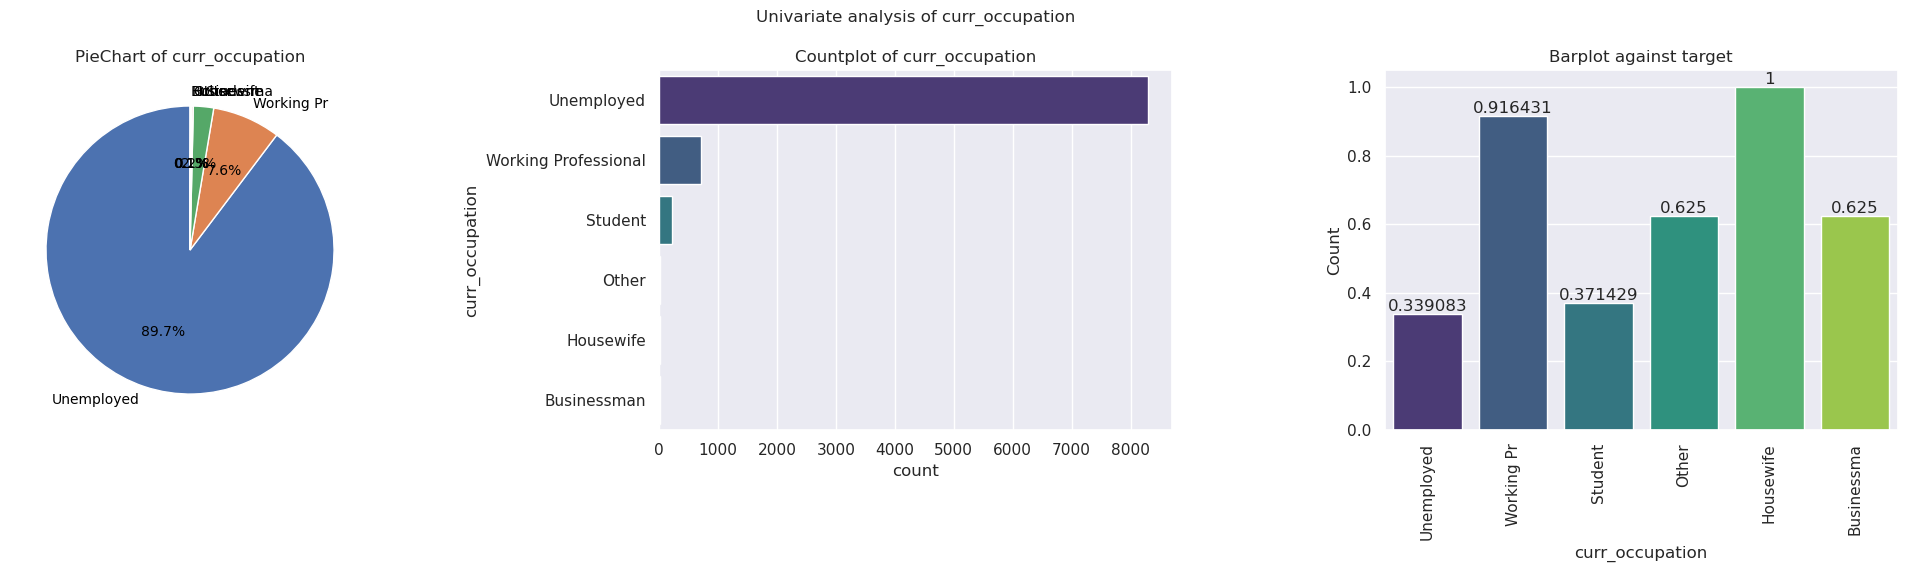

<Figure size 640x480 with 0 Axes>

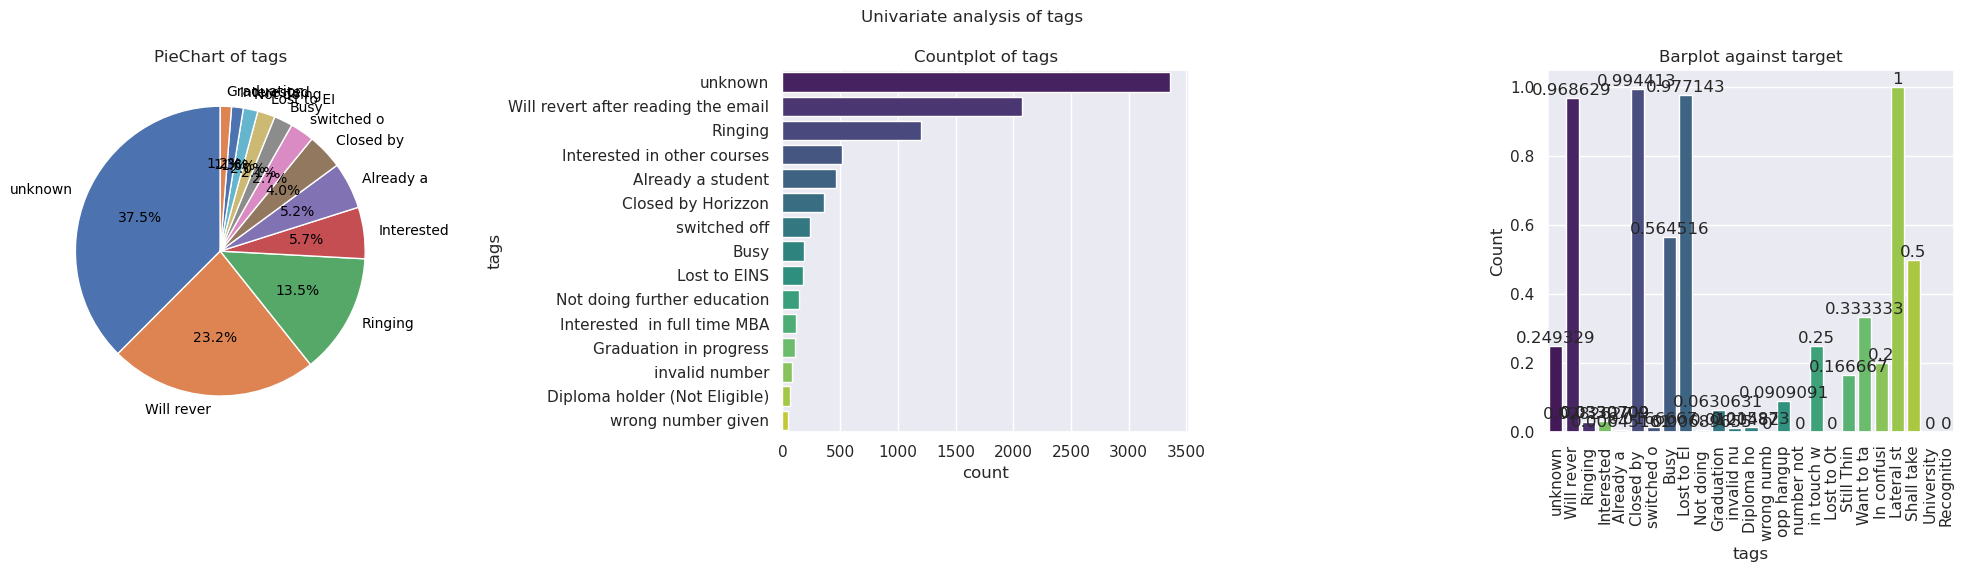

<Figure size 640x480 with 0 Axes>

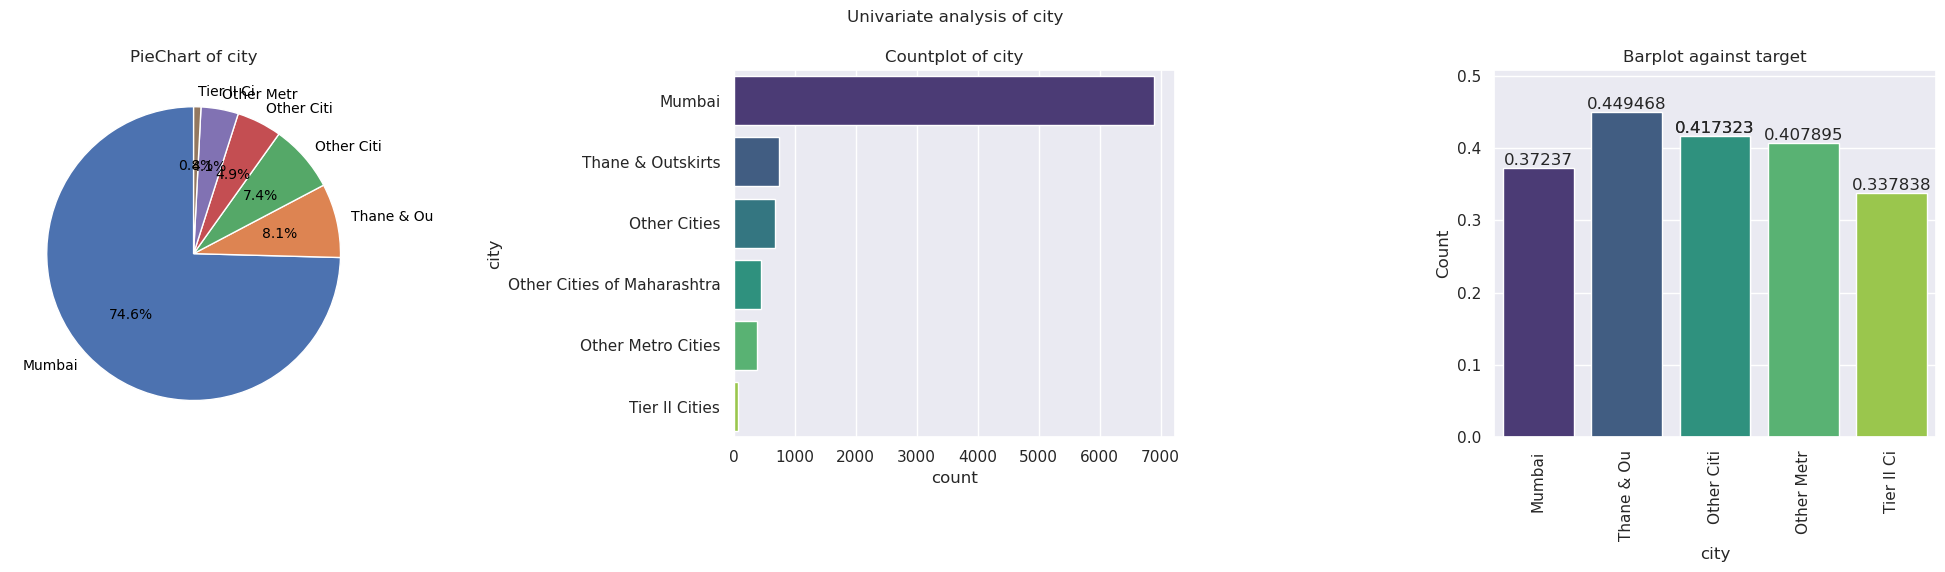

<Figure size 640x480 with 0 Axes>

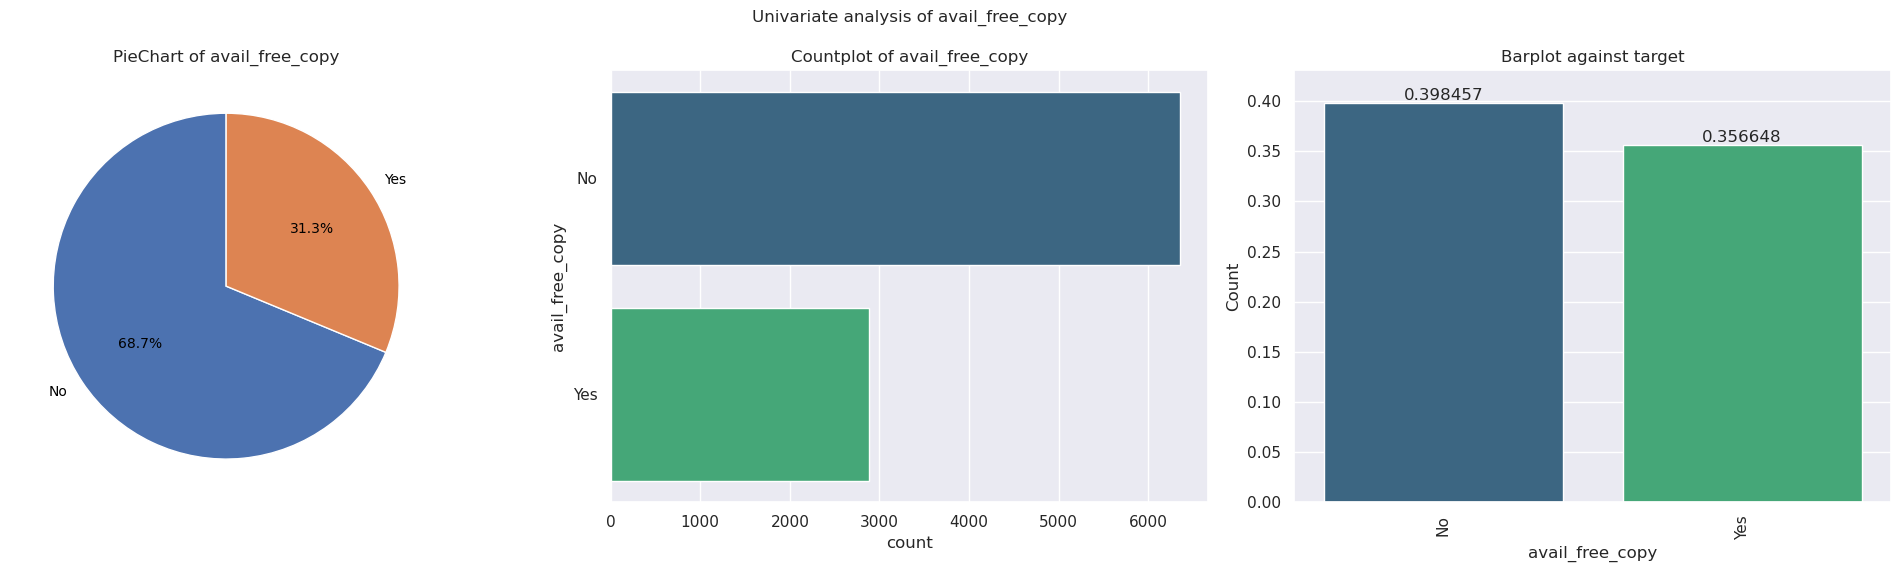

<Figure size 640x480 with 0 Axes>

In [1606]:
# univariate plots
cols = dtype_dict['int_cat'].copy()
cols.remove('converted')
univariate_plots(lead_score_df, cols, ftype='categorical', target='converted')

####  Observations

##### The categorical analysis
 - More than 50 per cent of the users are by originated landing page following which the apis have 38 of leeds
 - When it comes to lead origin conversion rates lead add form has higher conversion rates holistically all have similar probability rate
 
 - When it comes to lead source 30 are from google twenty seven percent are from direct traffic 19 are from olak chat
 
 - For the do not email feature 90 of them chose no while 7 of them chose yes therefore majority of them are interested in the edtech platform
 - Also the people who have said no also the users who said no have a higher percent of conversion rate
  
 - The last activity of majority of the users say 38 of users are email opened followed by sms sent therefore we can say that
 - Majority of the users are active on email conversations
  
 - Majority of the users are from india
 - We can we can assume that air tech has a higher popularity in india or higher interest in india higher demand in india
 
 - Among the employed users most of the interested users have finance management as a specialization followed by human resource management and marketing management almost all specialization has a similar conversion rate
 
 - Majority of the users are unemployed followed by working professionals
 - Working professionals have a higher conversion rates while the user count is low in comparison to unemployed
  
 - Majority of the users have chosen better career prospects as a reason for opting for the course
 
 - The majority of the leads have been tagged under will revert after reading the email
 
 - Maximum number of leads have been from the city of mumbai followed by thane almost all categories have similar probabilities of conversion
  
 - 90 of the leads have opted not to free copy of the interview while 31 are opted for interview copy
 

####

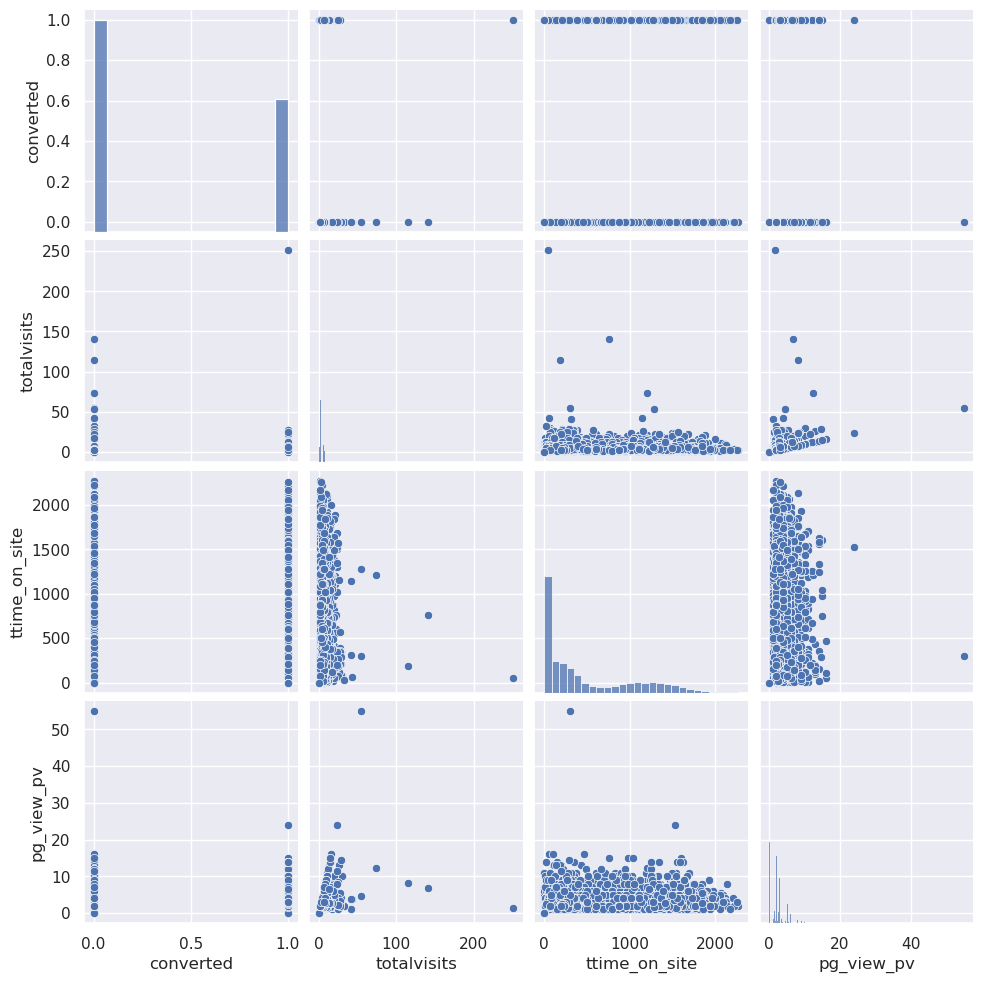

In [1607]:
# Bivariate plots
# The pair plot view shows that there is a slight correlation between total visits and page view per visit

sns.pairplot(lead_score_df)
plt.show();
# we can see that there is no clear linear relation among those columns apart from total visits and page view per visit.

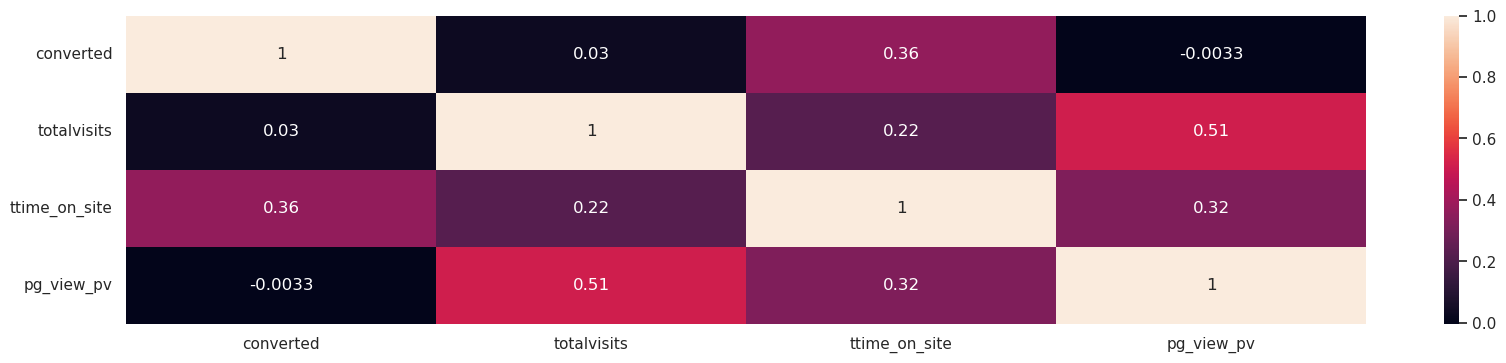

In [1608]:
# multivariate plots
# The heat map shows that majority of the features have no correlation or has lesser than 0 5 correlation

plt.figure(figsize = (20, 4)) # Size of the figure
sns.heatmap(lead_score_df.select_dtypes(exclude='category').corr(), annot = True)
plt.show();

#### 3.1 Other Bivariate - Multivariate plots (computationally intensive)

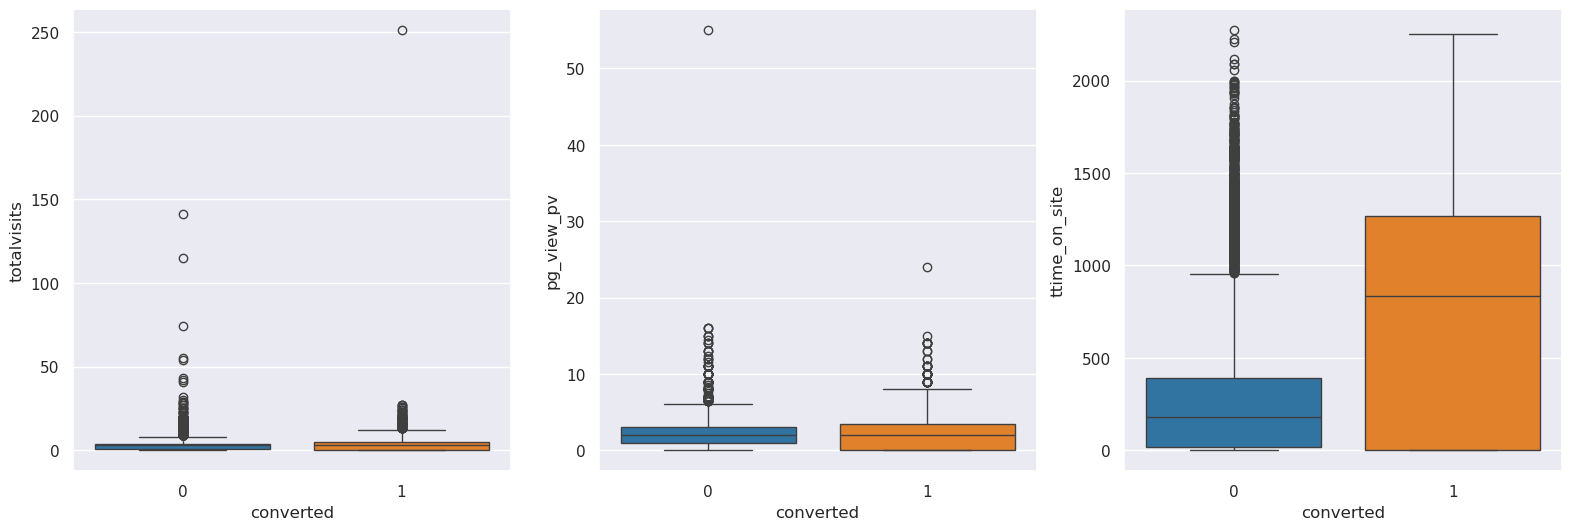

In [1609]:
# # Boxplots - numerical features against target

axs = 141
plt.figure(figsize=(26, 6))
for i in list(set(dtype_dict['float_ts']) - set(['date','converted','lead_number'])):
    plt.subplot(axs)
    sns.boxplot(y=i, x='converted', data=lead_score_df, palette='tab10')
    axs += 1
plt.show();

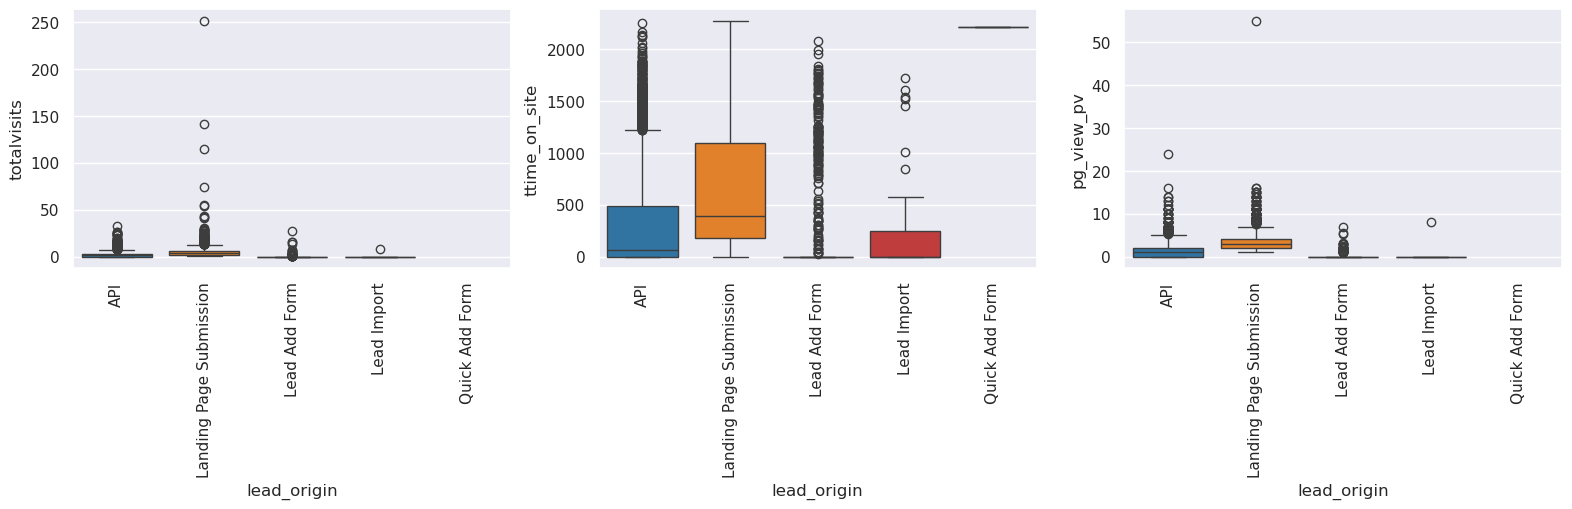

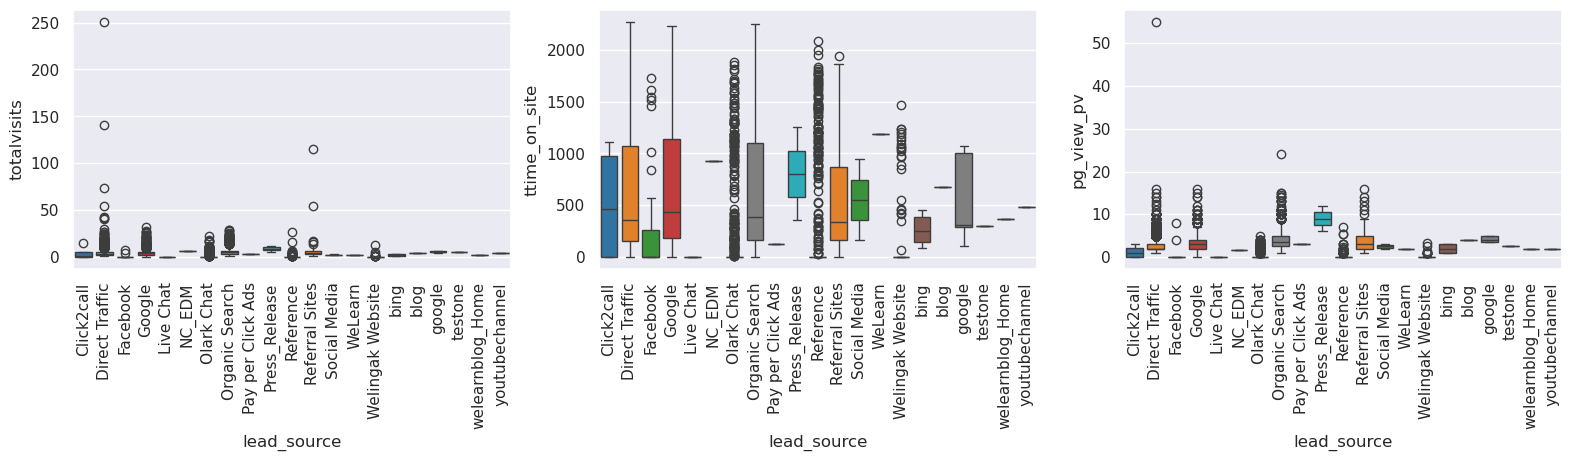

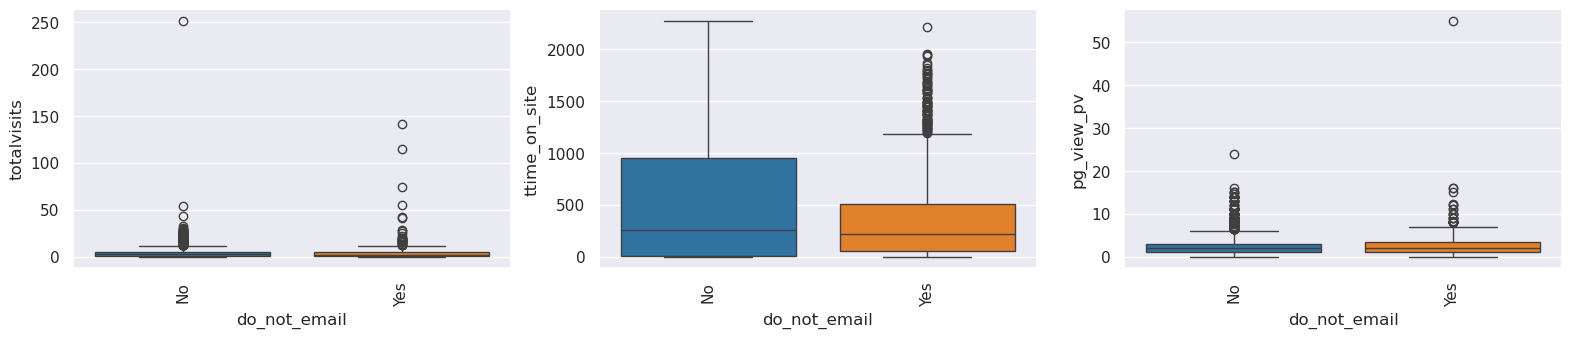

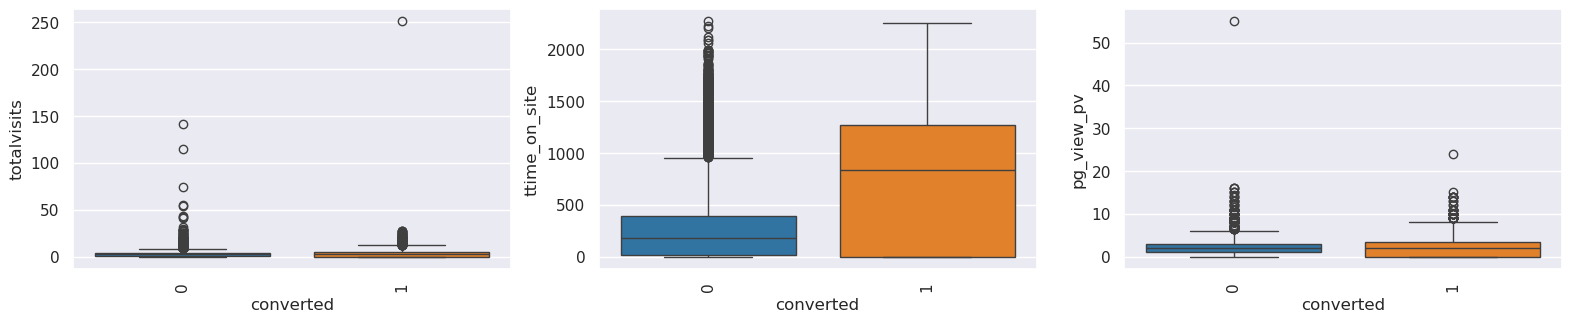

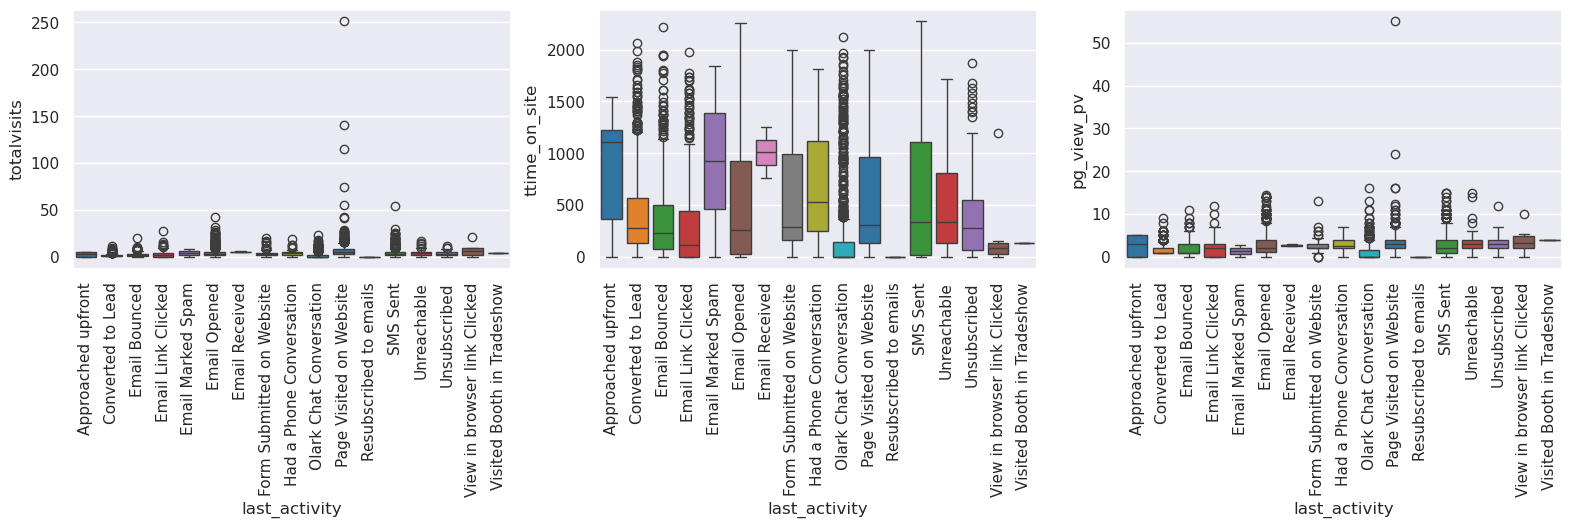

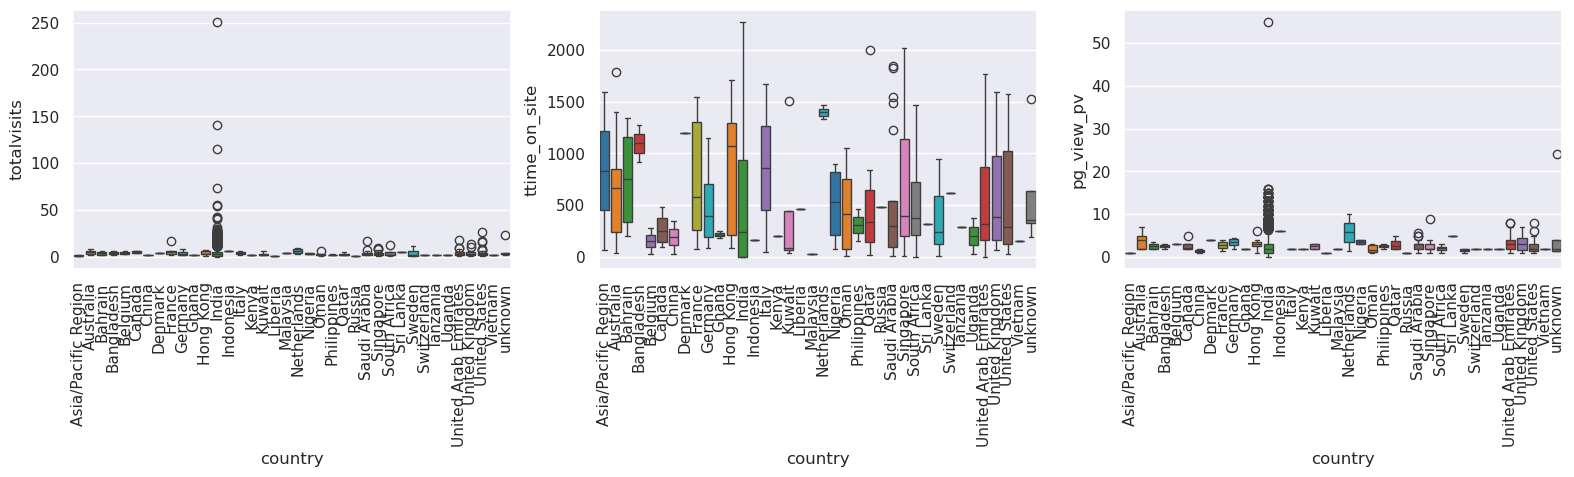

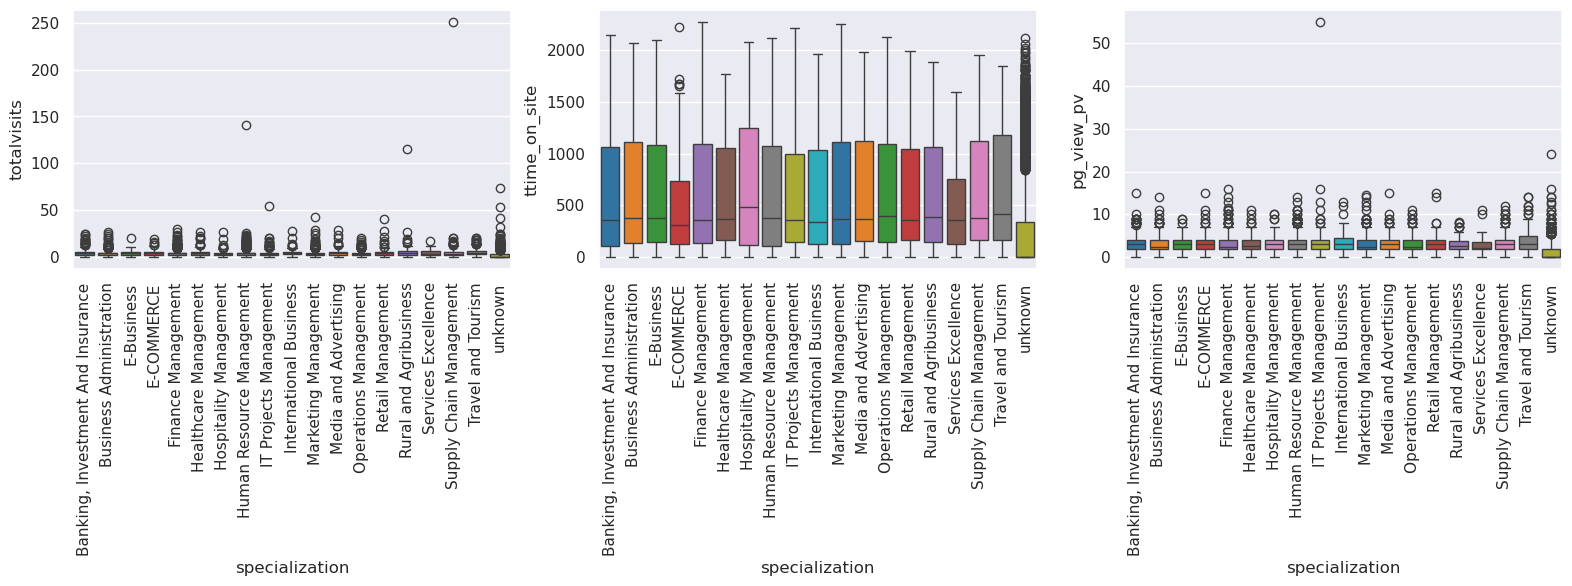

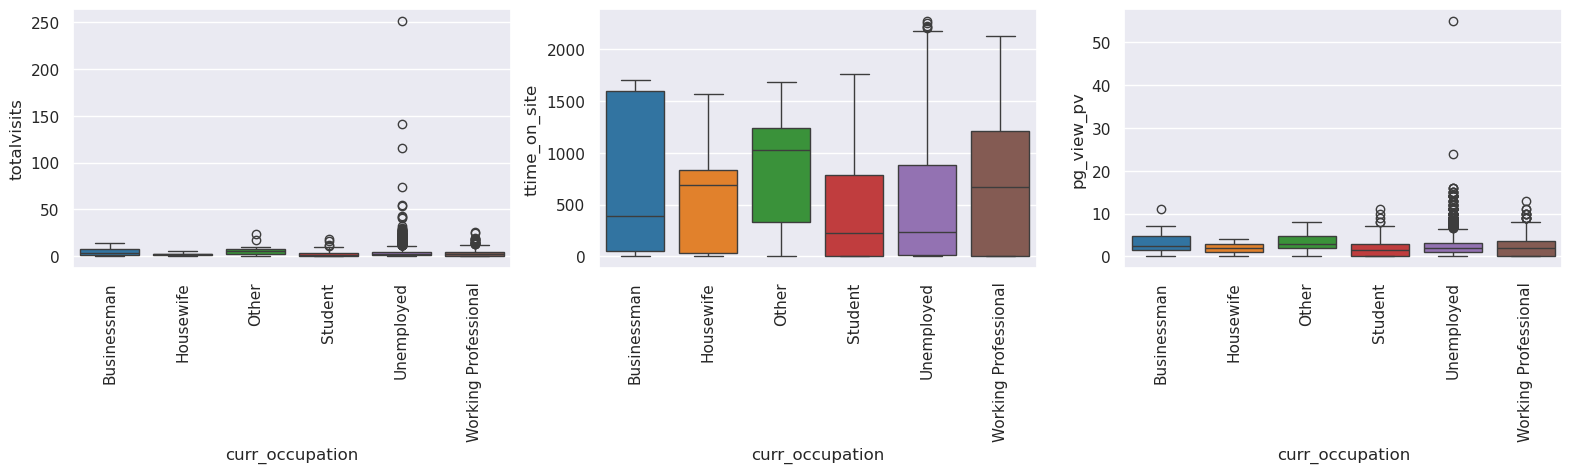

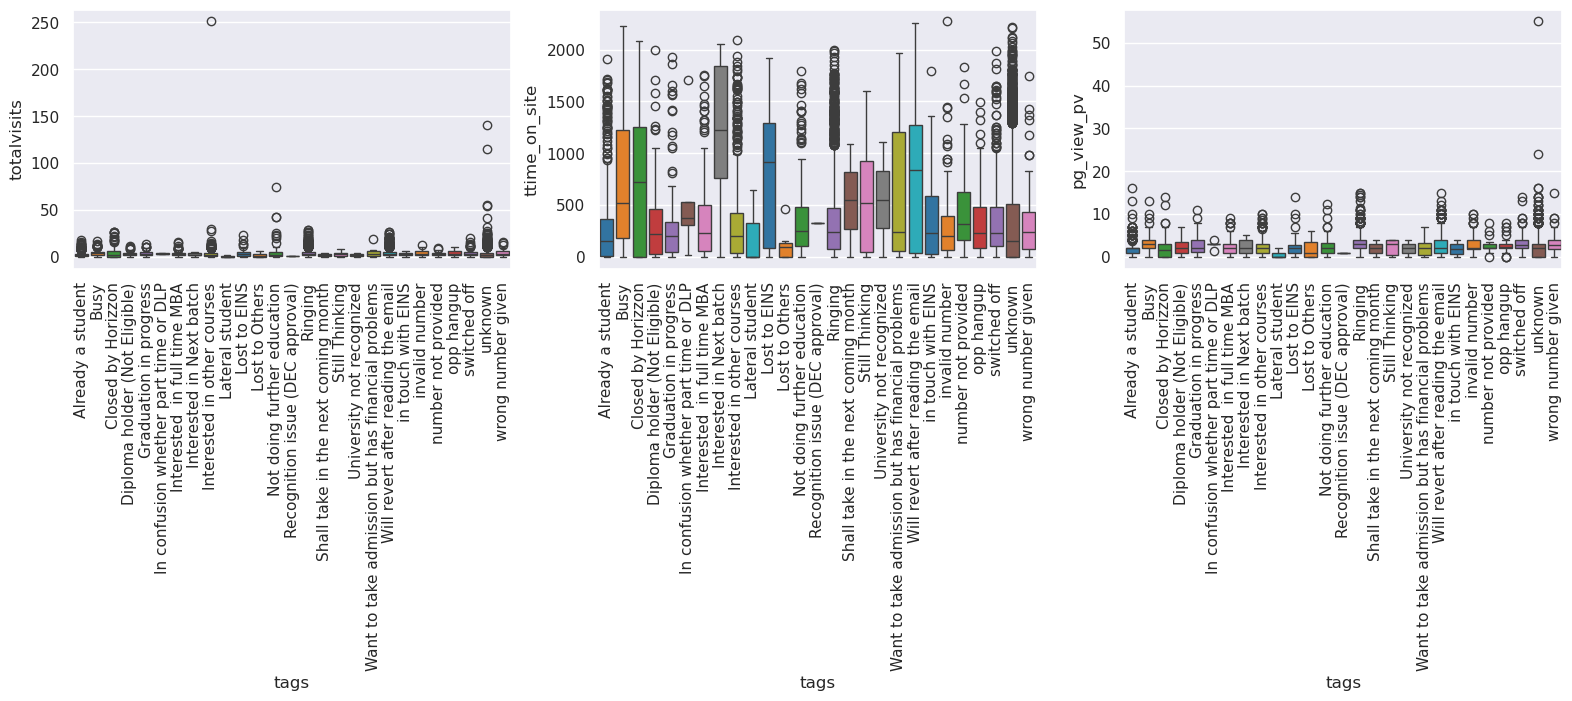

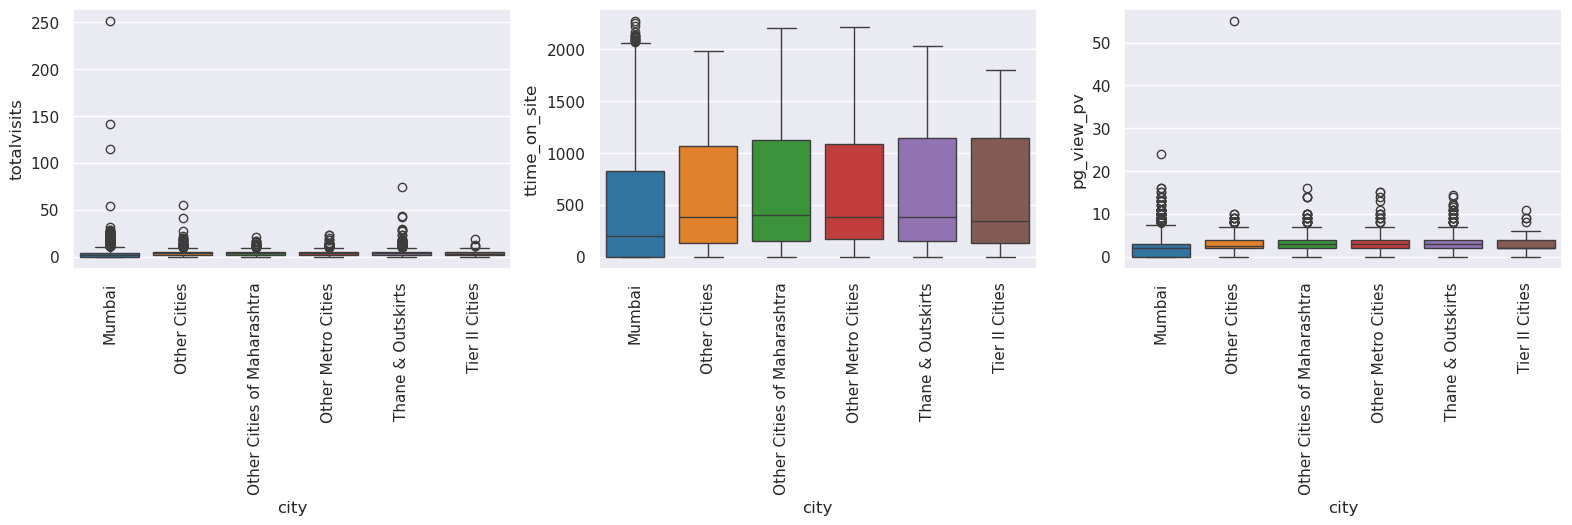

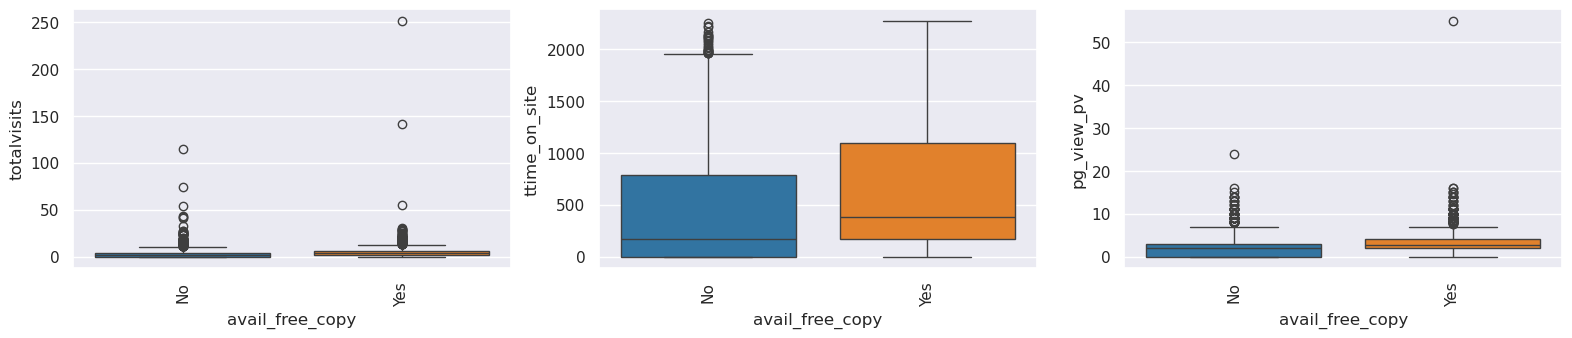

In [1610]:
# # Generate Bivariate Boxplots combinations for all the categorical vs continuous columns

x_lst = list(dtype_dict['int_cat']) # x_list variable contains all the categorical Columns 
y_lst = list(dtype_dict['float_ts'])# y_list contains all Continuous feature type columns 
axs = 1
for x_col in x_lst:
    plt.figure(figsize=(26,72))
    for y_col in y_lst:
        plt.subplot(18,4,axs)
        sns.boxplot(x=x_col, y=y_col, data=lead_score_df, palette='tab10')
        plt.xticks(rotation=90)
        axs += 1
    plt.show();
    axs = 1
plt.show();

In [1611]:
# # Generate Bivariate Barplots combinations for all the categorical features

# matplotlib.rcParams['ytick.labelsize'] = 8
# matplotlib.rcParams['xtick.labelsize'] = 8

# y_lst = x_lst = list(set(dtype_dict['int_cat']) - set(['converted','lead_number'])) # x_list variable contains all the categorical Columns 
# axs = 1
# for x_col in x_lst:
#     plt.figure(figsize=(25,400))
#     for y_col in y_lst:
        
#         # x_f = lead_score_df[x_col]
#         # y_f = lead_score_df[y_col]
            
#         # if isinstance(x_f,(object,'category')):
#         #     x_f = x_f.astype('str',copy=True).str.slice(0,10)
#         # if isinstance(y_f,(object,'category')):
#         #     y_f = y_f.astype('str',copy=True).str.slice(0,10)
        
#         plt.subplot(60,4,axs)
#         sns.barplot(x=x_col, y=y_col, hue ='converted' ,data=lead_score_df, palette='tab10')
#         plt.xticks(rotation=90)
#         # plt.ylabel(ylabel= lead_score_df[y_col].name, labelpad=-50)
#         # plt.locator_params(tight=True)
#         axs += 1
#     plt.show();
#     axs = 1
# plt.show();

In [1612]:
# # Multivariate Boxplots  - 

# matplotlib.rcParams['ytick.labelsize'] = 8
# matplotlib.rcParams['xtick.labelsize'] = 8
# # matplotlib.rcParams['ytick.major.size'] = 2
# # matplotlib.rcParams['xtick.major.size'] = 2

# z_lst = x_lst = list(dtype_dict['int_cat'])
# y_lst = list(dtype_dict['float_ts'])

# axs = 1
# for x_col in x_lst:
#     for y_col in y_lst:
#         plt.figure(figsize=(25, 200))
#         for z_col in z_lst:
            
#             # x_f = lead_score_df[x_col]
#             # y_f = lead_score_df[y_col]
            
#             # if isinstance(x_f,(object,'category')):
#             #     x_f = x_f.astype('str',copy=True).str.slice(0,10)
#             # if isinstance(y_f,(object,'category')):
#             #     y_f = y_f.astype('str',copy=True).str.slice(0,10)
            
#             plt.subplot(25, 2, axs)
#             sns.boxplot(x=x_col, y=y_col, hue=z_col,hue_order=lead_score_df[z_col].value_counts().head(10).index ,data=lead_score_df, palette='tab10')
#             plt.xticks(rotation=90)
#             # plt.locator_params(tight=True)
#             plt.legend(loc='best')
#             axs += 1
#         plt.show();
#     axs = 1
#     print("--------------------------------------------------------------------------")
#     # break
# plt.show();

In [1613]:
# # Multivariate Boxplots  - 

# matplotlib.rcParams['ytick.labelsize'] = 8
# matplotlib.rcParams['xtick.labelsize'] = 8
# # matplotlib.rcParams['ytick.major.size'] = 2
# # matplotlib.rcParams['xtick.major.size'] = 2

# x_lst = list(dtype_dict['int_cat'])
# x_lst.remove('lead_origin')
# x_lst.remove('converted')
# z_lst = y_lst= x_lst
# axs = 1
# for x_col in x_lst:
#     for y_col in y_lst:
#             plt.figure(figsize=(25, 500))
#             for z_col in z_lst:
#                  if (x_col != y_col) & (y_col != z_col) & (x_col != z_col):
                         
#                 #     x_f = lead_score_df[x_col]
#                 #     y_f = lead_score_df[y_col]
#                 #     if isinstance(x_f,(object,'category')):
#                 #             x_f = x_f.astype('str',copy=True).str.slice(0,10)
#                 #     if isinstance(y_f,(object,'category')):
#                 #             y_f = y_f.astype('str',copy=True).str.slice(0,10)
                            
#                     plt.subplot(100, 3, axs)
#                     sns.barplot(x=x_col, y=y_col, hue=z_col, hue_order=lead_score_df[z_col].value_counts().head(10).index, data=lead_score_df, palette='tab10')
#                     plt.xticks(rotation=90)
#                 #     plt.ylabel(labelpad=3)
#                 #     plt.locator_params.set_label_coords(-0.01, 0.5)
#                     plt.legend(loc='best')
#                     axs += 1
#             plt.show()
#             axs = 1
#     print("--------------------------------------------------------------------------")
# plt.show();

###  ----------------------------------------------------------------------

### 4. Data Preprocesing - Part 2

#### Outlier Analysis and Capping

In [1614]:
# After performing eda we identified outliers in page view per visit totalvisits ttime on site columns we therefore cap all the values to the upper cut off and lower cut off of the iqr range

ex_val_df = get_extremeval_threshld(df=lead_score_df.select_dtypes(exclude=['category','object']) )
ex_val_df
lead_score_df.describe(percentiles=[.05,.1,.2,.5,.8,.9])

thresh_low  thresh_high
name                                  
converted          -1.500        2.500
totalvisits        -5.000       11.000
ttime_on_site   -1374.000     2322.000
pg_view_pv         -2.000        6.000

converted  totalvisits  ttime_on_site  pg_view_pv
count   9240.000     9103.000       9240.000    9103.000
mean       0.385        3.445        487.698       2.363
std        0.487        4.855        548.021       2.161
min        0.000        0.000          0.000       0.000
5%         0.000        0.000          0.000       0.000
10%        0.000        0.000          0.000       0.000
20%        0.000        0.000          0.000       0.000
50%        0.000        3.000        248.000       2.000
80%        1.000        5.000       1087.200       4.000
90%        1.000        7.000       1380.000       5.000
max        1.000      251.000       2272.000      55.000

In [1615]:
# Fix Outliers by setting either thresh low or thresh low for both extremes 
lower_cutoff = ex_val_df.loc['pg_view_pv','thresh_low']
lead_score_df['pg_view_pv'] = np.where((lead_score_df['pg_view_pv'] < lower_cutoff), lower_cutoff, lead_score_df['pg_view_pv'])
upper_cutoff = ex_val_df.loc['pg_view_pv','thresh_high']
lead_score_df['pg_view_pv'] = np.where((lead_score_df['pg_view_pv'] > upper_cutoff), upper_cutoff, lead_score_df['pg_view_pv'])

# Fix Outliers by setting either thresh low or thresh low for both extremes
lower_cutoff = ex_val_df.loc['totalvisits','thresh_low']
lead_score_df['totalvisits'] = np.where((lead_score_df['totalvisits'] < lower_cutoff), lower_cutoff, lead_score_df['totalvisits'])
upper_cutoff = ex_val_df.loc['totalvisits','thresh_high']
lead_score_df['totalvisits'] = np.where((lead_score_df['totalvisits'] > upper_cutoff), upper_cutoff, lead_score_df['totalvisits'])

# Fix Outliers by setting either thresh low or thresh low for both extremes
lower_cutoff = ex_val_df.loc['ttime_on_site','thresh_low']
lead_score_df['ttime_on_site'] = np.where((lead_score_df['ttime_on_site'] < lower_cutoff), lower_cutoff, lead_score_df['ttime_on_site'])
upper_cutoff = ex_val_df.loc['ttime_on_site','thresh_high']
lead_score_df['ttime_on_site'] = np.where((lead_score_df['ttime_on_site'] > upper_cutoff), upper_cutoff, lead_score_df['ttime_on_site'])

In [1616]:
lead_score_df.describe()

converted  totalvisits  ttime_on_site  pg_view_pv
count   9240.000     9103.000       9240.000    9103.000
mean       0.385        3.221        487.698       2.259
std        0.487        2.882        548.021       1.793
min        0.000        0.000          0.000       0.000
25%        0.000        1.000         12.000       1.000
50%        0.000        3.000        248.000       2.000
75%        1.000        5.000        936.000       3.000
max        1.000       11.000       2272.000       6.000

In [1617]:
# Additionally there are few null values in their total visits and page view pub features therefore we replace with the mean of that particular column

lead_score_df['totalvisits'] = lead_score_df['totalvisits'].replace(to_replace=np.nan, value=lead_score_df['totalvisits'].median())
lead_score_df['pg_view_pv'] = lead_score_df['pg_view_pv'].replace(to_replace=np.nan, value=lead_score_df['pg_view_pv'].median())

In [1618]:
# our null values have significantly reduced
null_pct = check_cols_null_pct(lead_score_df)
null_pct[null_pct>0]
lead_score_df.shape

last_activity   1.115
lead_source     0.390
dtype: float64

(9240, 14)

In [1619]:
# dropping the rows from the below columns as they are small in number
lead_score_df = lead_score_df.dropna(subset=['last_activity','lead_source'])

In [1620]:
# dropping country column too since this doesn't have much input in the model
# and then checking if there any null values present in any column or not.
lead_score_df = lead_score_df.drop(['country'], axis=1)
null_pct = check_cols_null_pct(lead_score_df)
null_pct[null_pct>0] ### there are no null values

lead_score_df.shape

Series([], dtype: float64)

(9103, 13)

In [1621]:
lead_score_df.dtypes

lead_origin        category
lead_source        category
do_not_email       category
converted             int64
totalvisits         float64
ttime_on_site       float64
pg_view_pv          float64
last_activity      category
specialization     category
curr_occupation    category
tags               category
city               category
avail_free_copy    category
dtype: object

In [1622]:
# converted totalvisits to float data type
not lead_score_df['totalvisits'].dtype == np.float64

False

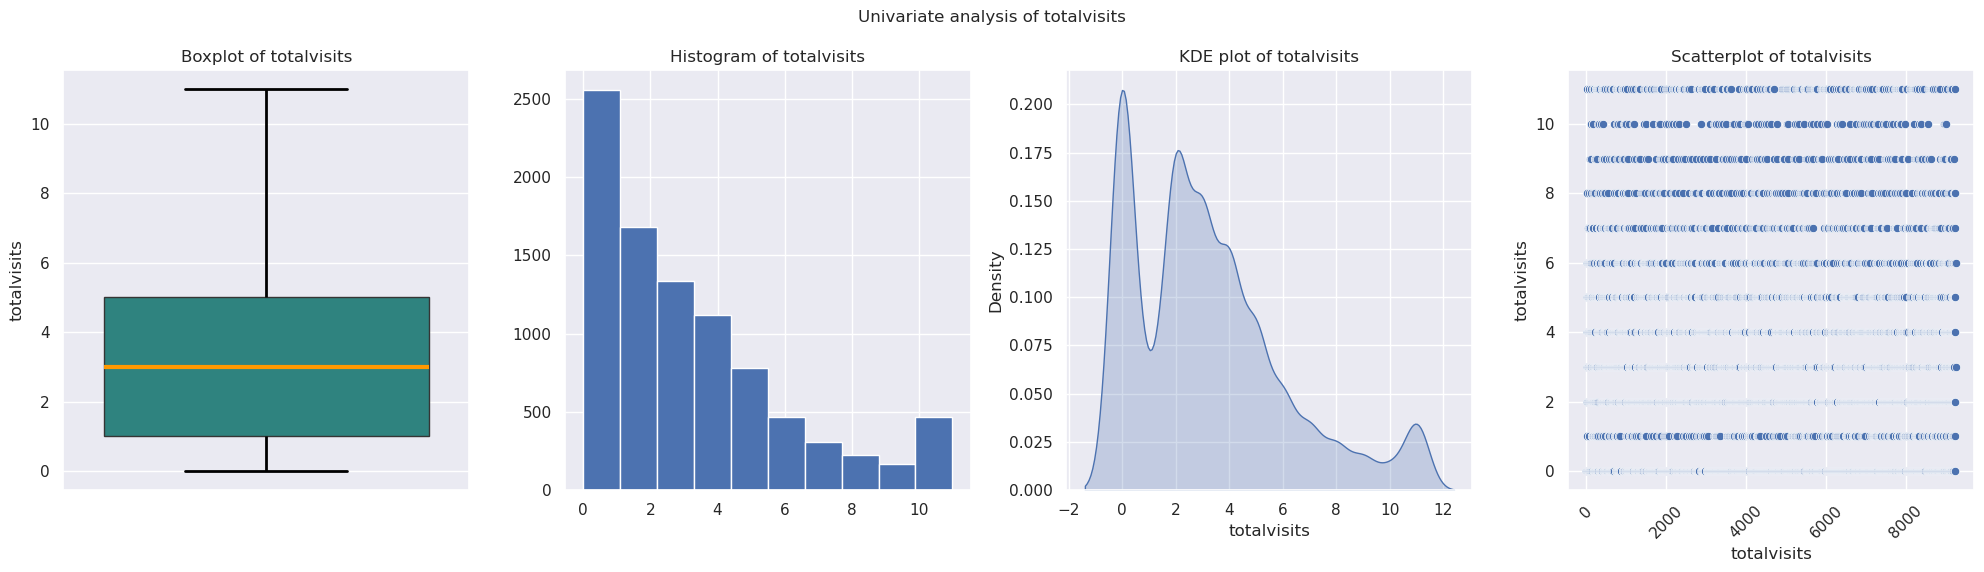

<Figure size 640x480 with 0 Axes>

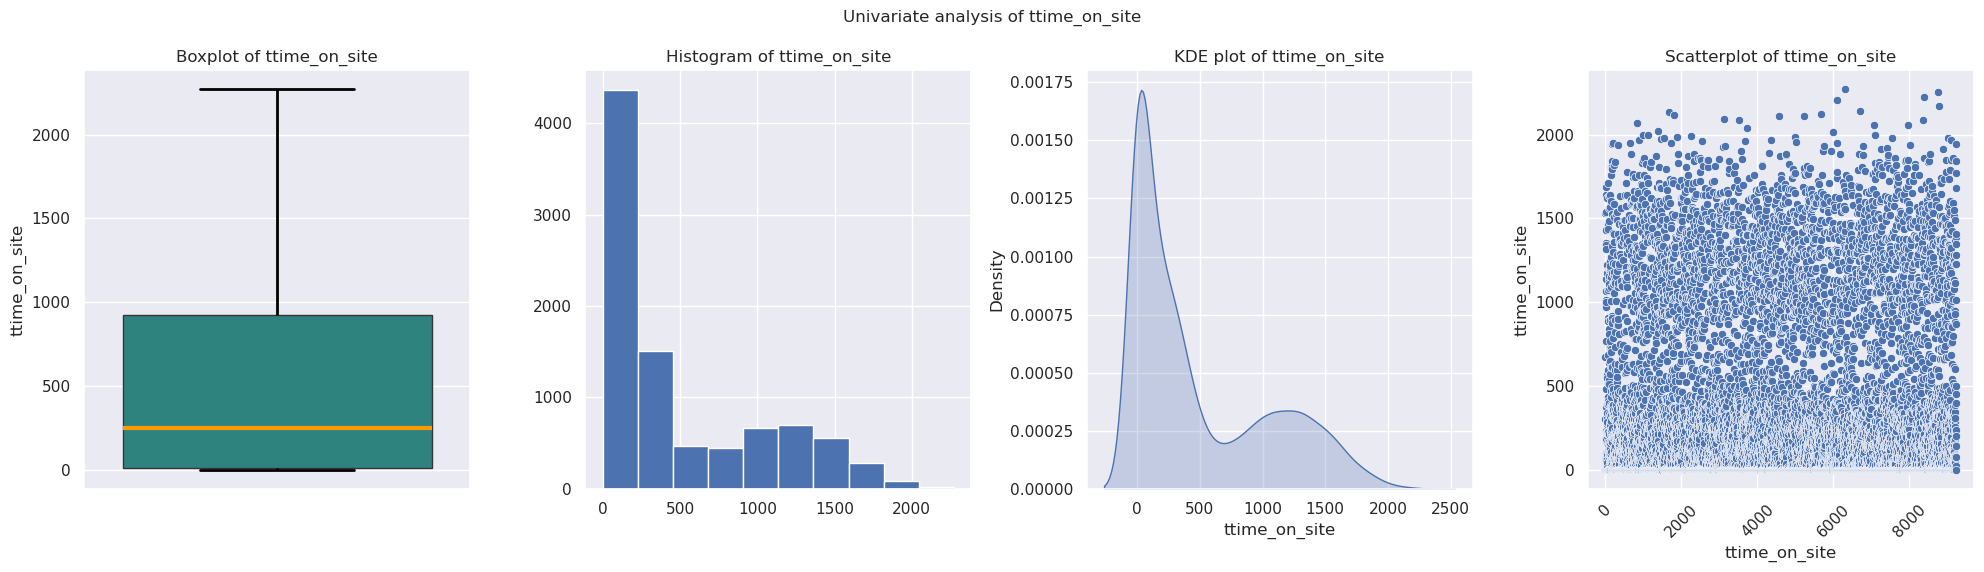

<Figure size 640x480 with 0 Axes>

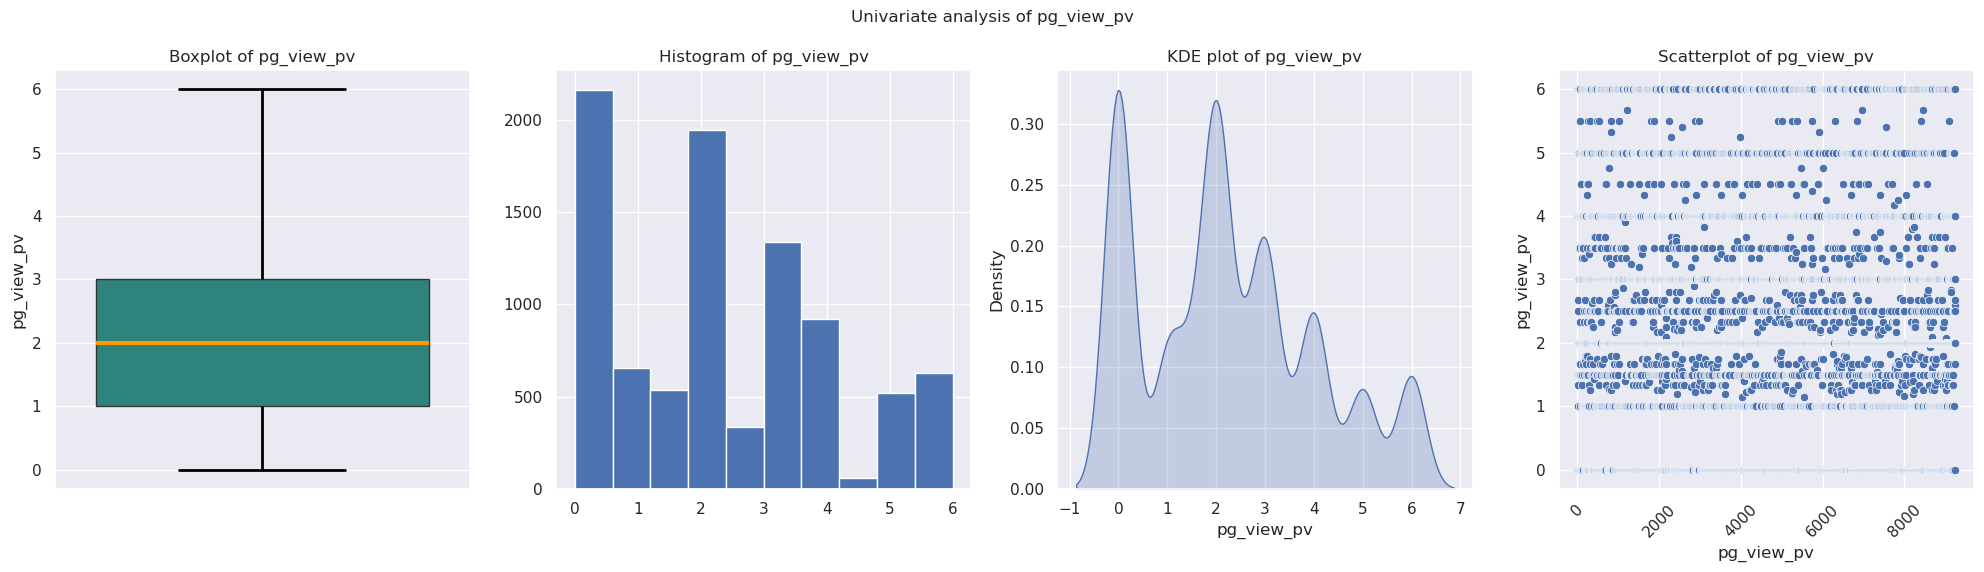

<Figure size 640x480 with 0 Axes>

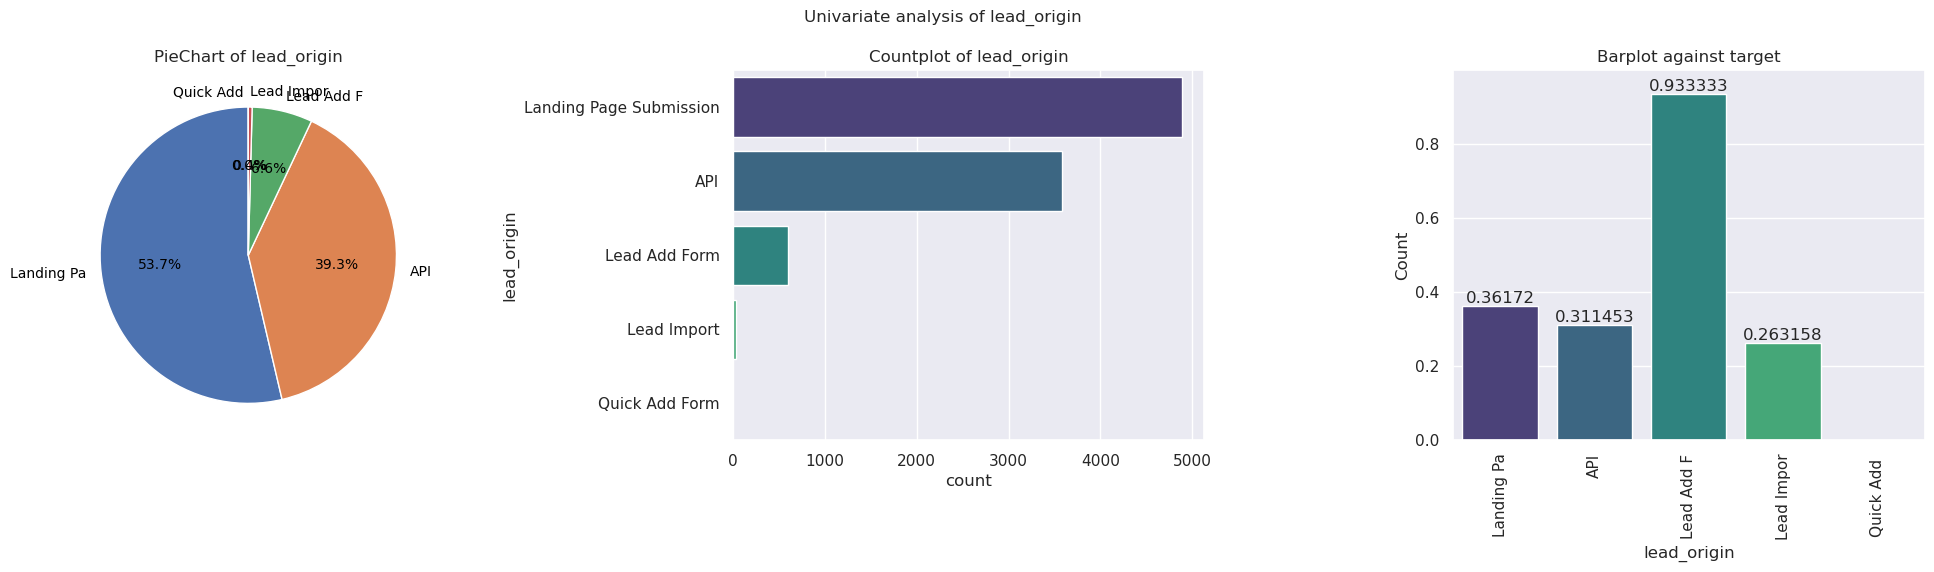

<Figure size 640x480 with 0 Axes>

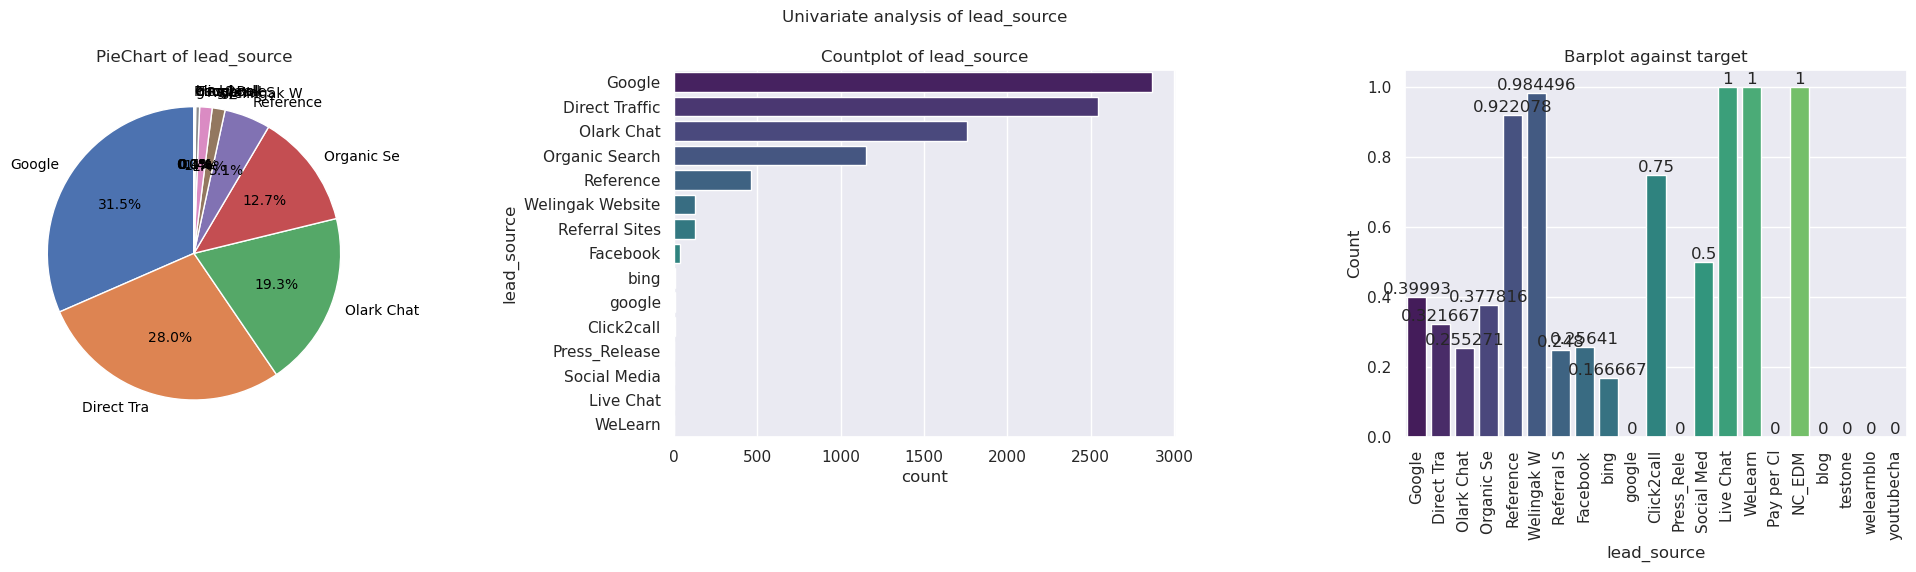

<Figure size 640x480 with 0 Axes>

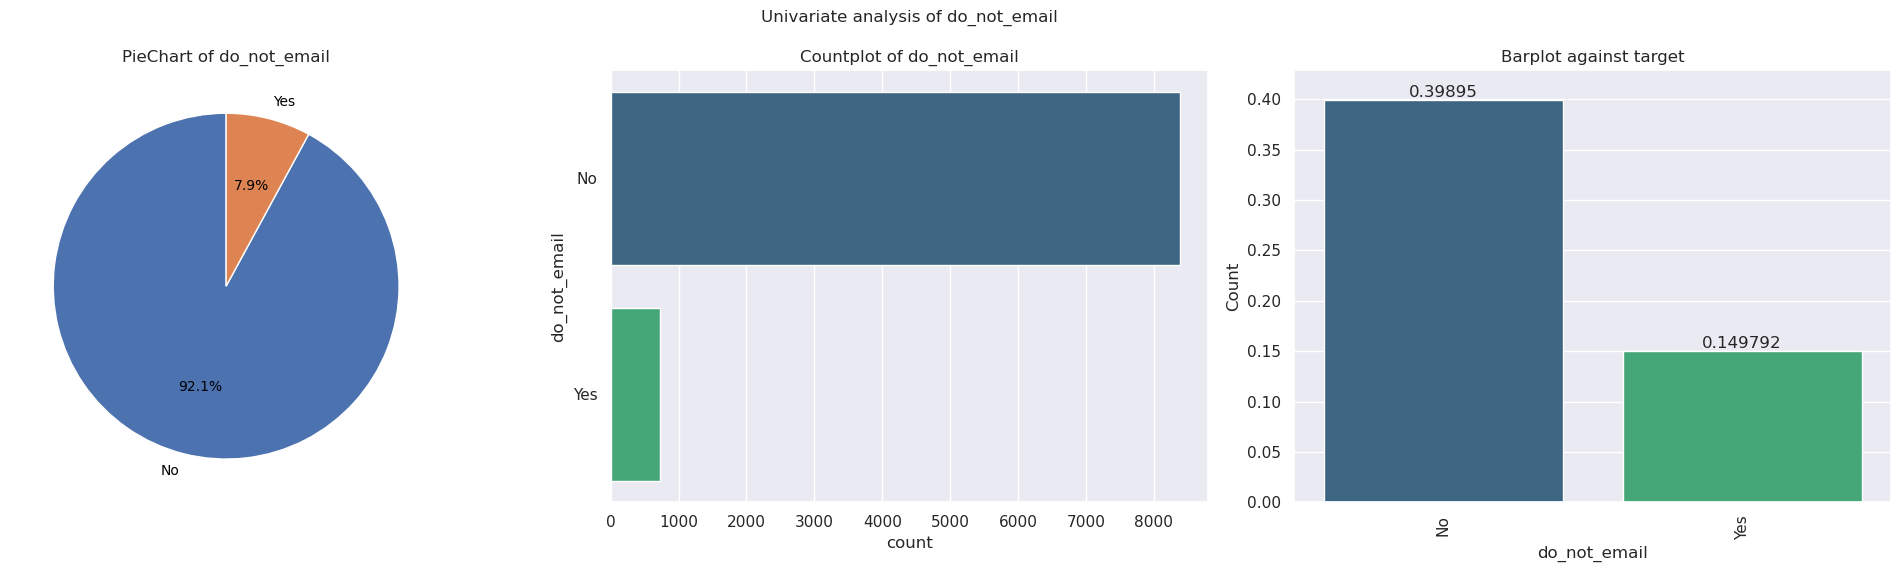

<Figure size 640x480 with 0 Axes>

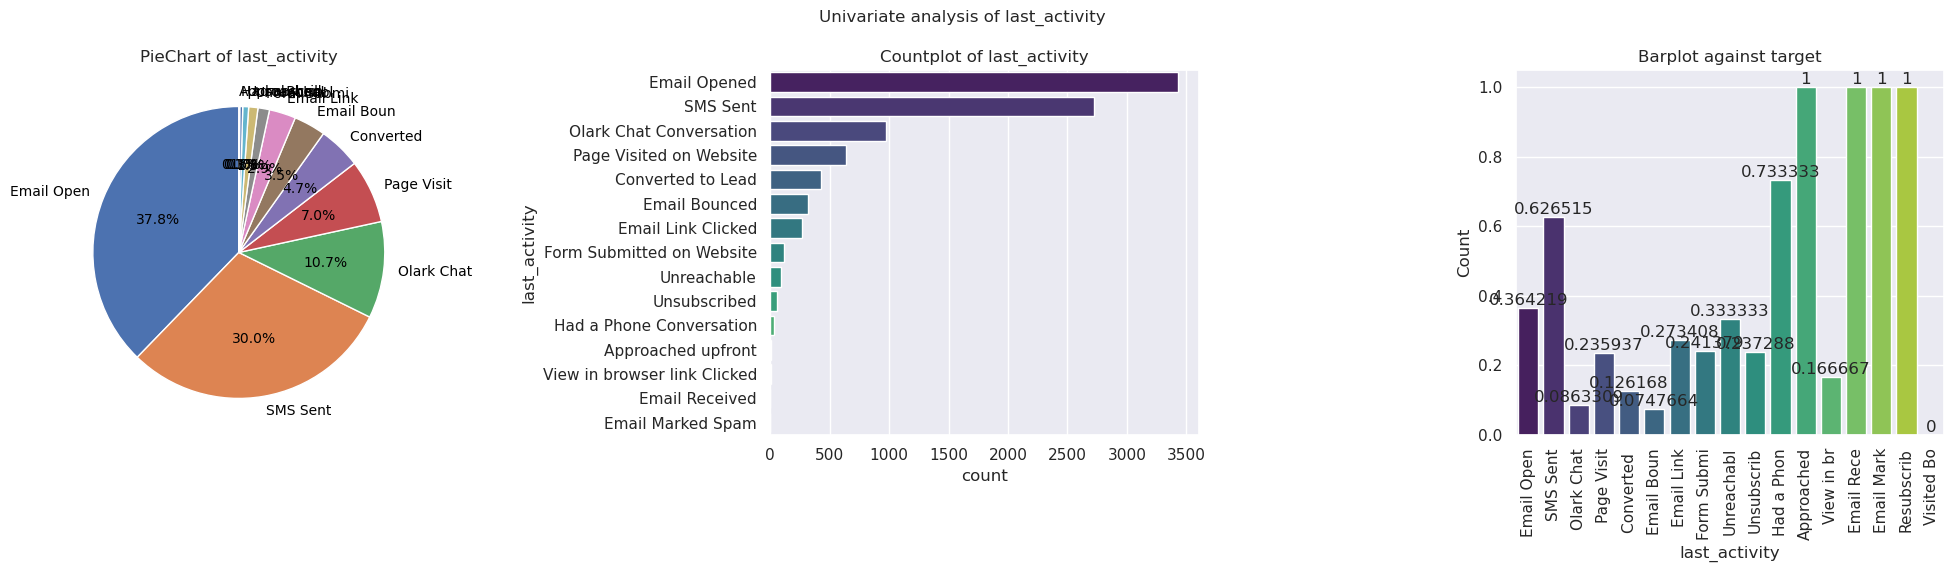

<Figure size 640x480 with 0 Axes>

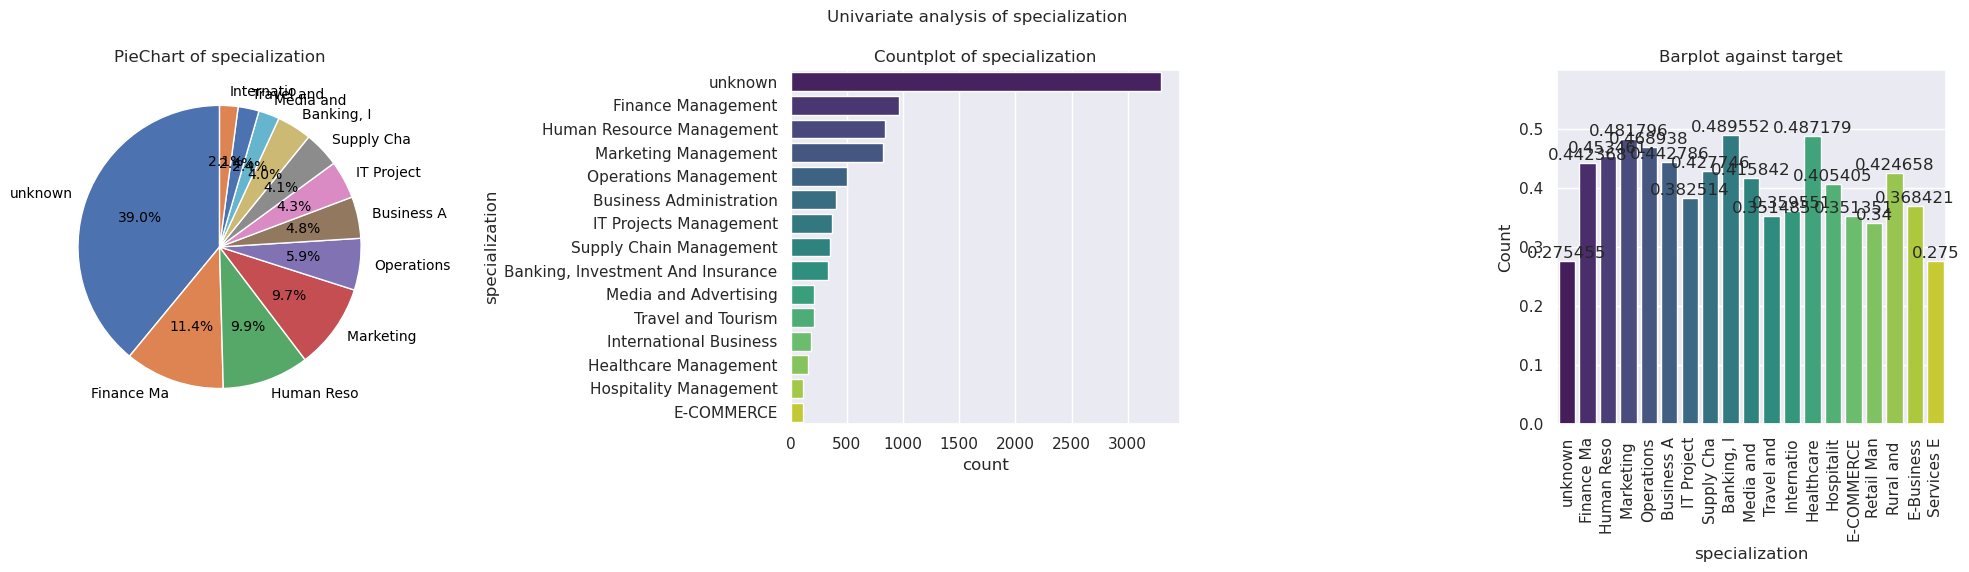

<Figure size 640x480 with 0 Axes>

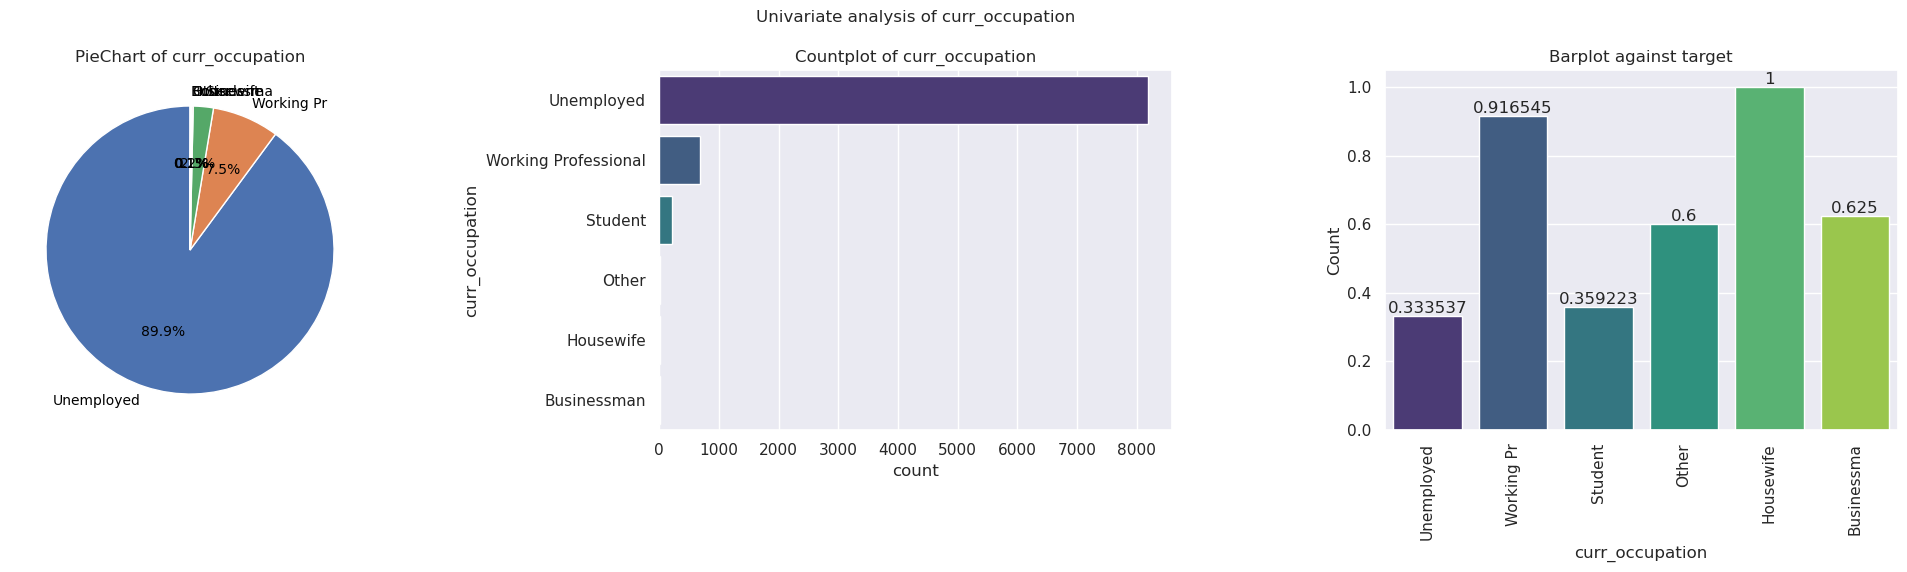

<Figure size 640x480 with 0 Axes>

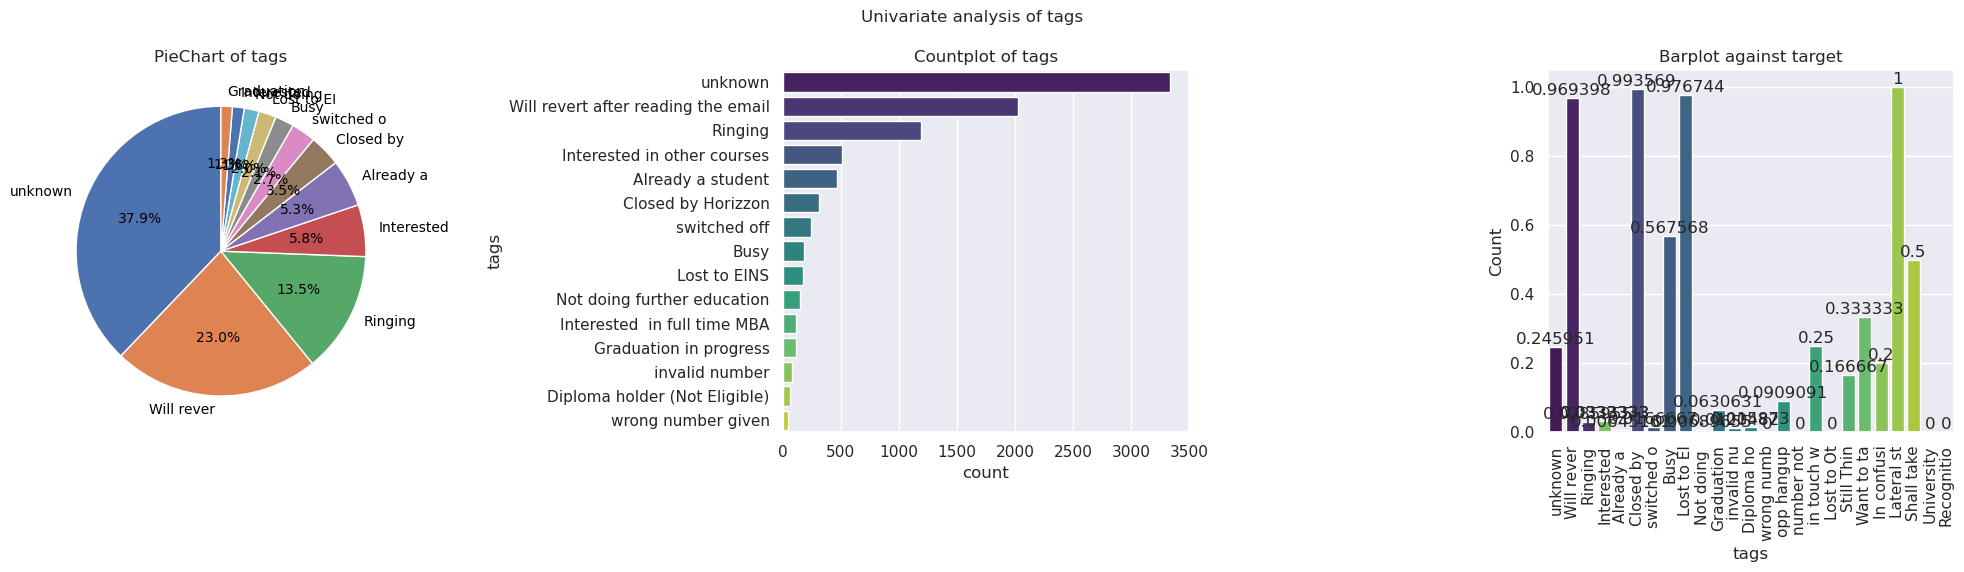

<Figure size 640x480 with 0 Axes>

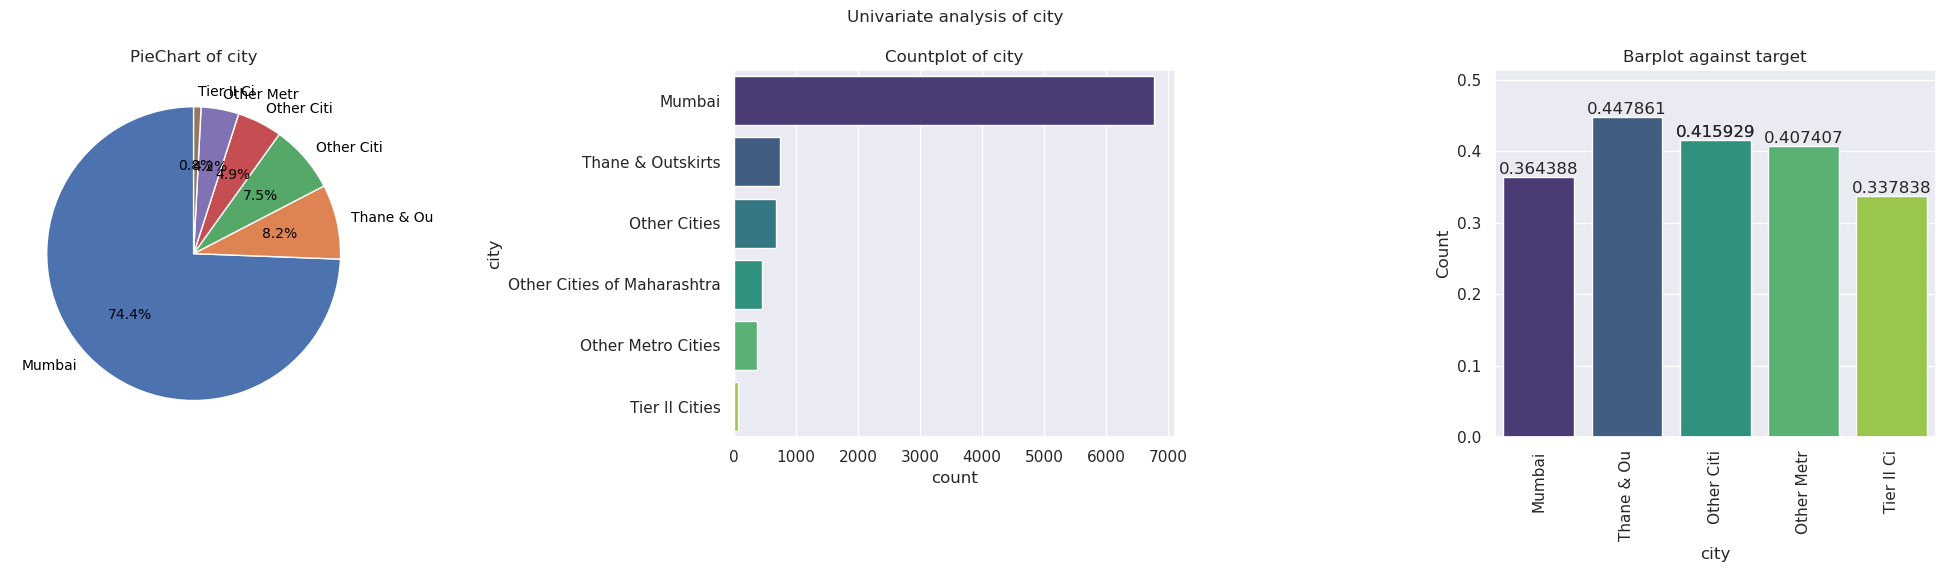

<Figure size 640x480 with 0 Axes>

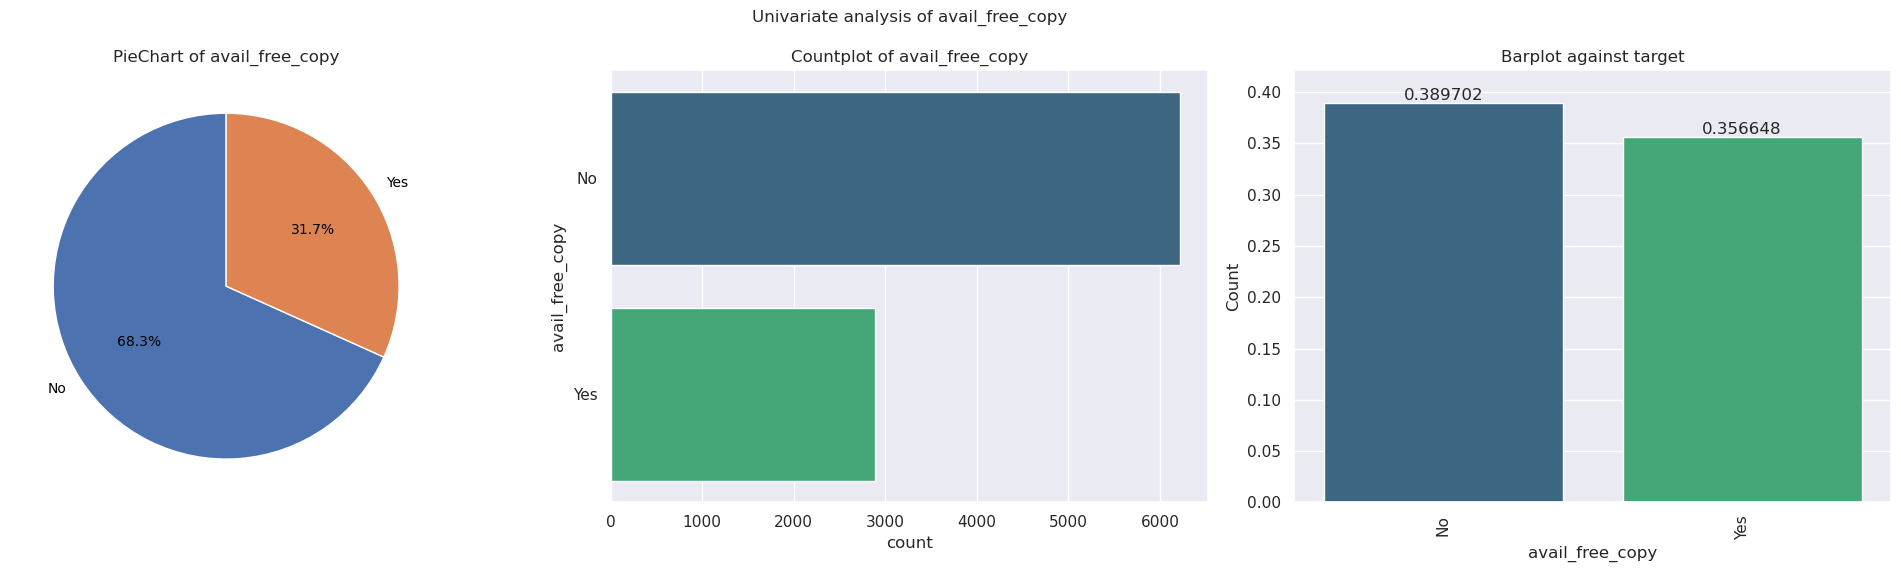

<Figure size 640x480 with 0 Axes>

In [1623]:
# after performing EDA on the raw dataset we are again trying to see the Univarivariate plots for all the related columns

dtype_dict = classify_feature_dtype(lead_score_df, lead_score_df.columns )
univariate_plots(lead_score_df, dtype_dict['float_ts'], ftype='non_categorical', target='converted')

cols = dtype_dict['int_cat'].copy()
cols.remove('converted')
univariate_plots(lead_score_df, cols, ftype='categorical', target='converted')

In [1624]:
# replace Yes, No with 1 and 0
lead_score_df = lead_score_df.replace(to_replace=['Yes', 'No'], value=[1, 0])

###  ----------------------------------------------------------------------

### 5. Data Imbalance & Conversion Ratio

In [1625]:
# Data Imbalance
# From the target variable we have found out the imbalance ratios around 62 therefore we decide not to rebalance

imbalance_ratio = sum(lead_score_df['converted'] == 1)/sum(lead_score_df['converted'] == 0) * 100
print(f'{round(imbalance_ratio, 2)}%')

61.09%


In [1626]:
# Conversion Ratio 
# From the target variable the conversion ratio is around 38 it shows that there is a very high probability of failure in conversion

converted = (sum(lead_score_df['converted'])/len(lead_score_df['converted'].index))*100
print(f'{round(converted, 2)}%')

37.92%


##  -----------------------------------------------------

In [1627]:
# errorline # do no remove this line

## -----------------------------------------------------

## Approach - 01

### Data Encoding

#### Dummy Encoding

In [1628]:
#  we perform dummy encoding
new_ls_df = pd.get_dummies(lead_score_df, columns=lead_score_df.select_dtypes('category').columns.difference(['tags','specialization']), drop_first=True, dtype=float)
new_ls_df.head(1)
new_ls_df.shape

converted  totalvisits  ttime_on_site  pg_view_pv specialization  \
0          0        0.000          0.000       0.000        unknown   

                          tags  avail_free_copy_1  city_Other Cities  \
0  Interested in other courses              0.000              0.000   

   city_Other Cities of Maharashtra  city_Other Metro Cities  \
0                             0.000                    0.000   

   city_Thane & Outskirts  city_Tier II Cities  curr_occupation_Housewife  \
0                   0.000                0.000                      0.000   

   curr_occupation_Other  curr_occupation_Student  curr_occupation_Unemployed  \
0                  0.000                    0.000                       1.000   

   curr_occupation_Working Professional  do_not_email_1  \
0                                 0.000           0.000   

   last_activity_Converted to Lead  last_activity_Email Bounced  \
0                            0.000                        0.000   

   last_activity_Email Link Clicked  last_activity_Email Marked Spam  \
0                             0.000                            0.000   

   last_activity_Email Opened  last_activity_Email Received  \
0                       0.000                         0.000   

   last_activity_Form Submitted on Website  \
0                                    0.000   

   last_activity_Had a Phone Conversation  \
0                                   0.000   

   last_activity_Olark Chat Conversation  \
0                                  0.000   

   last_activity_Page Visited on Website  \
0                                  1.000   

   last_activity_Resubscribed to emails  last_activity_SMS Sent  \
0                                 0.000                   0.000   

   last_activity_Unreachable  last_activity_Unsubscribed  \
0                      0.000                       0.000   

   last_activity_View in browser link Clicked  \
0                                       0.000   

   last_activity_Visited Booth in Tradeshow  \
0                                     0.000   

   lead_origin_Landing Page Submission  lead_origin_Lead Add Form  \
0                                0.000                      0.000   

   lead_origin_Lead Import  lead_origin_Quick Add Form  \
0                    0.000                       0.000   

   lead_source_Direct Traffic  lead_source_Facebook  lead_source_Google  \
0                       0.000                 0.000               0.000   

   lead_source_Live Chat  lead_source_NC_EDM  lead_source_Olark Chat  \
0                  0.000               0.000                   1.000   

   lead_source_Organic Search  lead_source_Pay per Click Ads  \
0                       0.000                          0.000   

   lead_source_Press_Release  lead_source_Reference  \
0                      0.000                  0.000   

   lead_source_Referral Sites  lead_source_Social Media  lead_source_WeLearn  \
0                       0.000                     0.000                0.000   

   lead_source_Welingak Website  lead_source_bing  lead_source_blog  \
0                         0.000             0.000             0.000   

   lead_source_google  lead_source_testone  lead_source_welearnblog_Home  \
0               0.000                0.000                         0.000   

   lead_source_youtubechannel  
0                       0.000

(9103, 58)

In [1629]:
new_ls_df = pd.get_dummies(new_ls_df, columns=['tags','specialization'], dtype=float)
new_ls_df = new_ls_df.drop(['tags_unknown','specialization_unknown'], axis=1)
new_ls_df.shape

(9103, 100)

###  ----------------------------------------------------------------------

### Train and Test Split

In [1630]:
# spliting the data into independent and target variable
X = new_ls_df.drop(['converted'], axis=1)
y = new_ls_df['converted']

In [1631]:
# Now we split the dataset into train and test set
np.random.seed(0)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=0)

###  ----------------------------------------------------------------------

### Feature Scaling

In [1632]:
new_ls_df.dtypes

converted                                                   int64
totalvisits                                               float64
ttime_on_site                                             float64
pg_view_pv                                                float64
avail_free_copy_1                                         float64
city_Other Cities                                         float64
city_Other Cities of Maharashtra                          float64
city_Other Metro Cities                                   float64
city_Thane & Outskirts                                    float64
city_Tier II Cities                                       float64
curr_occupation_Housewife                                 float64
curr_occupation_Other                                     float64
curr_occupation_Student                                   float64
curr_occupation_Unemployed                                float64
curr_occupation_Working Professional                      float64
do_not_ema

In [1633]:
# Post split we perform standard scaling they fit and transform the train data set
# to_scale = ['lead_number', 'totalvisits', 'ttime_on_site', 'pg_view_pv']

to_scale = list(X.columns)

scaler = StandardScaler()
X_train[to_scale] = scaler.fit_transform(X_train[to_scale], y_train)
X_train.head(5)

totalvisits  ttime_on_site  pg_view_pv  avail_free_copy_1  \
7740       -0.779         -0.376      -0.712              1.471   
7014        0.971          0.881      -0.150             -0.680   
2431       -0.429         -0.337      -0.150             -0.680   
3012        1.672          1.539       0.973             -0.680   
3140       -1.130         -0.889      -1.274             -0.680   

      city_Other Cities  city_Other Cities of Maharashtra  \
7740             -0.284                             4.347   
7014             -0.284                            -0.230   
2431             -0.284                            -0.230   
3012             -0.284                            -0.230   
3140             -0.284                            -0.230   

      city_Other Metro Cities  city_Thane & Outskirts  city_Tier II Cities  \
7740                   -0.208                  -0.293               -0.086   
7014                   -0.208                  -0.293               -0.086   
2431                   -0.208                  -0.293               -0.086   
3012                   -0.208                  -0.293               -0.086   
3140                   -0.208                  -0.293               -0.086   

      curr_occupation_Housewife  curr_occupation_Other  \
7740                     -0.029                 -0.042   
7014                     -0.029                 -0.042   
2431                     -0.029                 -0.042   
3012                     -0.029                 -0.042   
3140                     -0.029                 -0.042   

      curr_occupation_Student  curr_occupation_Unemployed  \
7740                   -0.152                       0.335   
7014                   -0.152                       0.335   
2431                   -0.152                       0.335   
3012                   -0.152                       0.335   
3140                   -0.152                       0.335   

      curr_occupation_Working Professional  do_not_email_1  \
7740                                -0.284          -0.290   
7014                                -0.284          -0.290   
2431                                -0.284          -0.290   
3012                                -0.284          -0.290   
3140                                -0.284          -0.290   

      last_activity_Converted to Lead  last_activity_Email Bounced  \
7740                            4.477                       -0.192   
7014                           -0.223                       -0.192   
2431                           -0.223                       -0.192   
3012                           -0.223                       -0.192   
3140                           -0.223                       -0.192   

      last_activity_Email Link Clicked  last_activity_Email Marked Spam  \
7740                            -0.176                           -0.017   
7014                            -0.176                           -0.017   
2431                            -0.176                           -0.017   
3012                            -0.176                           -0.017   
3140                            -0.176                           -0.017   

      last_activity_Email Opened  last_activity_Email Received  \
7740                      -0.781                        -0.017   
7014                       1.280                        -0.017   
2431                      -0.781                        -0.017   
3012                       1.280                        -0.017   
3140                       1.280                        -0.017   

      last_activity_Form Submitted on Website  \
7740                                   -0.122   
7014                                   -0.122   
2431                                    8.189   
3012                                   -0.122   
3140                                   -0.122   

      last_activity_Had a Phone Conversation  \
7740                                  -0.054   
7014              

###  ----------------------------------------------------------------------

### Model Building

##### Custom Functions for Model Training

In [1634]:
# We create custom functions for model veiling since iteration we reuse certain functions again and again
# Train and predict function trains the model and predicts on the same data and returns the model its probability and predicted values based on cutoff
# The matrix function returns confusion matrix and accuracy score
# The vif function returns the vif score for the features

def logreg_train_pred_fn(fX_train, fy_train, fcol, fcutoff):
    fX_train_sm = sm.add_constant(fX_train[fcol])
    flogm = sm.GLM(fy_train, fX_train_sm, family = sm.families.Binomial())
    fres = flogm.fit()
    fy_train_pred = fres.predict(fX_train_sm)
    fy_train_pred = fy_train_pred.values.reshape(-1)
    fy_train_pred_final = pd.DataFrame({'Converted':fy_train.values, 'Conv_Prob':fy_train_pred})
    fy_train_pred_final['ID'] = fy_train.index
    fy_train_pred_final['predicted'] = fy_train_pred_final.Conv_Prob.map(lambda x: 1 if x > fcutoff else 0)
    return fres, fy_train_pred,fy_train_pred_final

def logreg_metrics_fn(fy_train_pred_final):
    fconfusion = confusion_matrix(fy_train_pred_final.Converted, fy_train_pred_final.predicted )
    faccuracy = accuracy_score(fy_train_pred_final.Converted, fy_train_pred_final.predicted)
    return fconfusion, faccuracy
   
def logreg_VIF_score_fn(fX_train, fcol):
    fvif = pd.DataFrame()
    fvif['Features'] = fX_train[fcol].columns
    fvif['VIF'] = [variance_inflation_factor(fX_train[fcol].values, i) for i in range(fX_train[fcol].shape[1])]
    fvif['VIF'] = round(fvif['VIF'], 2)
    fvif = fvif.sort_values(by = "VIF", ascending = False)
    return fvif

##### Base Model

In [1635]:
# Logistic regression model
logm1 = sm.GLM(y_train,(sm.add_constant(X_train)), family = sm.families.Binomial())
res = logm1.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              converted   No. Observations:                 7282
Model:                            GLM   Df Residuals:                     7183
Model Family:                Binomial   Df Model:                           98
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                    nan
Date:                Sun, 20 Oct 2024   Deviance:                       69906.
Time:                        23:04:16   Pearson chi2:                 3.42e+18
No. Iterations:                   100   Pseudo R-squ. (CS):                nan
Covariance Type:            nonrobust                                         
==========================================================================================================================
                                                             coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------------
const                                                  -2.981e+14   7.86e+05  -3.79e+08      0.000   -2.98e+14   -2.98e+14
totalvisits                                             1.437e+14    1.3e+06   1.11e+08      0.000    1.44e+14    1.44e+14
ttime_on_site                                           9.087e+13   9.56e+05   9.51e+07      0.000    9.09e+13    9.09e+13
pg_view_pv                                             -1.353e+14   1.44e+06  -9.37e+07      0.000   -1.35e+14   -1.35e+14
avail_free_copy_1                                      -5.638e+13   1.18e+06   -4.8e+07      0.000   -5.64e+13   -5.64e+13
city_Other Cities                                       1.495e+13   8.39e+05   1.78e+07      0.000    1.49e+13    1.49e+13
city_Other Cities of Maharashtra                        6.152e+12   8.29e+05   7.42e+06      0.000    6.15e+12    6.15e+12
city_Other Metro Cities                                 6.251e+12   8.28e+05   7.55e+06      0.000    6.25e+12    6.25e+12
city_Thane & Outskirts                                 -8.958e+12   8.34e+05  -1.07e+07      0.000   -8.96e+12   -8.96e+12
city_Tier II Cities                                     2.437e+13      8e+05   3.05e+07      0.000    2.44e+13    2.44e+13
curr_occupation_Housewife                               1.005e+14   1.12e+06   8.99e+07      0.000    1.01e+14    1.01e+14
curr_occupation_Other                                  -5.502e+11   1.41e+06  -3.91e+05      0.000    -5.5e+11    -5.5e+11
curr_occupation_Student                                 4.004e+13   4.18e+06   9.58e+06      0.000       4e+13       4e+13
curr_occupation_Unemployed                              6.388e+13   8.31e+06   7.69e+06      0.000    6.39e+13    6.39e+13
curr_occupation_Working Professional                    9.028e+13    7.3e+06   1.24e+07      0.000    9.03e+13    9.03e+13
do_not_email_1                                         -1.029e+14   1.13e+06  -9.07e+07      0.000   -1.03e+14   -1.03e+14
last_activity_Converted to Lead                        -3.893e+14   5.96e+06  -6.54e+07      0.000   -3.89e+14   -3.89e+14
last_activity_Email Bounced                            -3.002e+14   5.25e+06  -5.72e+07      0.000      -3e+14      -3e+14
last_activity_Email Link Clicked                       -2.886e+14   4.78e+06  -6.04e+07      0.000   -2.89e+14   -2.89e+14
last_activity_Email Marked Spam                         2.959e+13   9.15e+05   3.23e+07      0.000    2.96e+13    2.96e+13
last_activity_Email Opened                             -7.692e+14   1.34e+07  -5.72e+07      0.000   -7.69e+14   -7.69e+14
last_activity_Email Received                           -1.686e+13   9.13e+05  -1.85e+07      0.000   -1.69e+13   -1.69e+13
last_act

##### RFE - Recursive Feature Elimination

In [1636]:
# Since the data set has a lot of features we perform rfe to eliminate insignificant features
logreg = LogisticRegression()

rfe = RFE(estimator=logreg, n_features_to_select=15)             # running RFE with 15 variables as output
rfe = rfe.fit(X_train, y_train)
rfe_feature_Ranking = list(zip(X_train.columns, rfe.support_, rfe.ranking_))

In [1637]:
rfe_sorted = sorted(rfe_feature_Ranking, key=lambda x : x[2])
rfe_sorted[:15]

[('ttime_on_site', True, 1),
 ('last_activity_Olark Chat Conversation', True, 1),
 ('last_activity_SMS Sent', True, 1),
 ('lead_origin_Lead Add Form', True, 1),
 ('lead_source_Olark Chat', True, 1),
 ('lead_source_Welingak Website', True, 1),
 ('tags_Already a student', True, 1),
 ('tags_Closed by Horizzon', True, 1),
 ('tags_Interested in other courses', True, 1),
 ('tags_Lost to EINS', True, 1),
 ('tags_Not doing further education', True, 1),
 ('tags_Ringing', True, 1),
 ('tags_Will revert after reading the email', True, 1),
 ('tags_switched off', True, 1),
 ('tags_wrong number given', True, 1)]

In [1638]:
col = X_train.columns[rfe.support_]
# X_train.columns[~rfe.support_]

##### Model 1

In [1639]:
# Now we perform model iteration as many times as possible till we get an optimum result

cutoff = 0.5
res, y_train_pred,y_train_pred_final = logreg_train_pred_fn(X_train, y_train, col, cutoff)
confusion, accuracy = logreg_metrics_fn(y_train_pred_final)
vif = logreg_VIF_score_fn(X_train, col)

print('Model Summary:')          # Model Summary:
res.summary()
print('\nVIF Score:')            # VIF Score:
vif

# print('\nY_Predicted Values:')   # Y_Predicted Values:
# y_train_pred
# print('\nY_Predicted Cutoff:')   # Y_Predicted Cutoff:
# y_train_pred_final
# print('\nConfusion Matrix:')     # Confusion Matrix: 
# confusion
# print(f'\nAccuracy Score: {accuracy}\n')       # Accuracy Score:

# since we can see the 'tags_wrong number given' column having high P value then we will drop the same.

Model Summary:


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              converted   No. Observations:                 7282
Model:                            GLM   Df Residuals:                     7266
Model Family:                Binomial   Df Model:                           15
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1601.1
Date:                Sun, 20 Oct 2024   Deviance:                       3202.1
Time:                        23:04:22   Pearson chi2:                 8.54e+03
No. Iterations:                    22   Pseudo R-squ. (CS):             0.5892
Covariance Type:            nonrobust                                         
============================================================================================================
                                               coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------
const                                       -0.8841     60.489     -0.015      0.988    -119.440     117.672
ttime_on_site                                1.0554      0.052     20.110      0.000       0.953       1.158
last_activity_Olark Chat Conversation       -0.4699      0.064     -7.347      0.000      -0.595      -0.345
last_activity_SMS Sent                       0.8580      0.046     18.699      0.000       0.768       0.948
lead_origin_Lead Add Form                    0.4000      0.091      4.405      0.000       0.222       0.578
lead_source_Olark Chat                       0.5871      0.051     11.412      0.000       0.486       0.688
lead_source_Welingak Website                 0.5735      0.126      4.555      0.000       0.327       0.820
tags_Already a student                      -0.7594      0.156     -4.853      0.000      -1.066      -0.453
tags_Closed by Horizzon                      1.2012      0.136      8.801      0.000       0.934       1.469
tags_Interested in other courses            -0.4510      0.074     -6.087      0.000      -0.596      -0.306
tags_Lost to EINS                            0.6964      0.071      9.754      0.000       0.556       0.836
tags_Not doing further education            -0.3755      0.126     -2.972      0.003      -0.623      -0.128
tags_Ringing                                -0.9581      0.070    -13.702      0.000      -1.095      -0.821
tags_Will revert after reading the email     1.9035      0.069     27.620      0.000       1.768       2.039
tags_switched off                           -0.4885      0.083     -5.851      0.000      -0.652      -0.325
tags_wrong number given                     -1.6314    835.166     -0.002      0.998   -1638.527    1635.264
============================================================================================================
"""


VIF Score:


Features   VIF
3                  lead_origin_Lead Add Form 1.670
4                     lead_source_Olark Chat 1.450
12  tags_Will revert after reading the email 1.450
0                              ttime_on_site 1.420
5               lead_source_Welingak Website 1.310
1      last_activity_Olark Chat Conversation 1.280
7                    tags_Closed by Horizzon 1.220
11                              tags_Ringing 1.180
2                     last_activity_SMS Sent 1.170
8           tags_Interested in other courses 1.090
6                     tags_Already a student 1.070
13                         tags_switched off 1.050
9                          tags_Lost to EINS 1.040
10          tags_Not doing further education 1.030
14                   tags_wrong number given 1.010

##### Model 2

In [1640]:
# after dropping the 'tags_wrong number given' we will again make a model and see the stats

# col = col.drop('curr_occupation_Housewife', 1)
# col

col = col.drop('tags_wrong number given', 1)
col

cutoff = 0.5
res, y_train_pred,y_train_pred_final = logreg_train_pred_fn(X_train, y_train, col, cutoff)
confusion, accuracy = logreg_metrics_fn(y_train_pred_final)
vif = logreg_VIF_score_fn(X_train, col)

print('Model Summary:')          # Model Summary:
res.summary()
print('\nVIF Score:')            # VIF Score:
vif

# print('\nY_Predicted Values:')   # Y_Predicted Values:
# y_train_pred
# print('\nY_Predicted Cutoff:')   # Y_Predicted Cutoff:
# y_train_pred_final

print('\nConfusion Matrix:')     # Confusion Matrix: 
confusion
print(f'\nAccuracy Score: {accuracy}\n')   # Accuracy Score:

Index(['ttime_on_site', 'last_activity_Olark Chat Conversation',
       'last_activity_SMS Sent', 'lead_origin_Lead Add Form',
       'lead_source_Olark Chat', 'lead_source_Welingak Website',
       'tags_Already a student', 'tags_Closed by Horizzon',
       'tags_Interested in other courses', 'tags_Lost to EINS',
       'tags_Not doing further education', 'tags_Ringing',
       'tags_Will revert after reading the email', 'tags_switched off'],
      dtype='object')

Model Summary:


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              converted   No. Observations:                 7282
Model:                            GLM   Df Residuals:                     7267
Model Family:                Binomial   Df Model:                           14
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1613.0
Date:                Sun, 20 Oct 2024   Deviance:                       3225.9
Time:                        23:04:22   Pearson chi2:                 8.54e+03
No. Iterations:                     8   Pseudo R-squ. (CS):             0.5878
Covariance Type:            nonrobust                                         
============================================================================================================
                                               coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------
const                                       -0.7748      0.074    -10.459      0.000      -0.920      -0.630
ttime_on_site                                1.0570      0.052     20.244      0.000       0.955       1.159
last_activity_Olark Chat Conversation       -0.4698      0.064     -7.339      0.000      -0.595      -0.344
last_activity_SMS Sent                       0.8479      0.046     18.582      0.000       0.758       0.937
lead_origin_Lead Add Form                    0.4040      0.091      4.445      0.000       0.226       0.582
lead_source_Olark Chat                       0.5964      0.051     11.614      0.000       0.496       0.697
lead_source_Welingak Website                 0.5749      0.126      4.567      0.000       0.328       0.822
tags_Already a student                      -0.7561      0.156     -4.832      0.000      -1.063      -0.449
tags_Closed by Horizzon                      1.2040      0.136      8.823      0.000       0.937       1.472
tags_Interested in other courses            -0.4463      0.074     -6.029      0.000      -0.591      -0.301
tags_Lost to EINS                            0.6987      0.071      9.785      0.000       0.559       0.839
tags_Not doing further education            -0.3729      0.126     -2.951      0.003      -0.621      -0.125
tags_Ringing                                -0.9469      0.070    -13.565      0.000      -1.084      -0.810
tags_Will revert after reading the email     1.9121      0.069     27.758      0.000       1.777       2.047
tags_switched off                           -0.4829      0.083     -5.786      0.000      -0.647      -0.319
============================================================================================================
"""


VIF Score:


Features   VIF
3                  lead_origin_Lead Add Form 1.670
4                     lead_source_Olark Chat 1.450
12  tags_Will revert after reading the email 1.450
0                              ttime_on_site 1.420
5               lead_source_Welingak Website 1.310
1      last_activity_Olark Chat Conversation 1.280
7                    tags_Closed by Horizzon 1.220
2                     last_activity_SMS Sent 1.170
11                              tags_Ringing 1.170
8           tags_Interested in other courses 1.090
6                     tags_Already a student 1.070
13                         tags_switched off 1.050
9                          tags_Lost to EINS 1.040
10          tags_Not doing further education 1.030


Confusion Matrix:


array([[4302,  204],
       [ 389, 2387]])


Accuracy Score: 0.9185663279318869



In [1641]:
# taking values for TP , TN, FP, FN
TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives

# Calculate the sensitivity
TP/(TP+FN)

# Calculate the specificity
TN/(TN+FP)

0.8598703170028819

0.9547270306258322

#### Finding Optimal Cutoff Point

In [1642]:
# Let's create columns with different probability cutoffs 
numbers = [float(x)/10 for x in range(10)]
for i in numbers:
    y_train_pred_final[i]= y_train_pred_final.Conv_Prob.map(lambda x: 1 if x > i else 0)
y_train_pred_final.head()

Converted   Conv_Prob    ID   predicted  0.000  0.100  0.200  0.300  \
0           0       0.002  7740           0      1      0      0      0   
1           1       0.966  7014           1      1      1      1      1   
2           0       0.004  2431           0      1      0      0      0   
3           1       0.983  3012           1      1      1      1      1   
4           0       0.165  3140           0      1      1      0      0   

   0.400  0.500  0.600  0.700  0.800  0.900  
0      0      0      0      0      0      0  
1      1      1      1      1      1      1  
2      0      0      0      0      0      0  
3      1      1      1      1      1      1  
4      0      0      0      0      0      0

In [1643]:
# Now let's calculate accuracy sensitivity and specificity for various probability cutoffs.
cutoff_df = pd.DataFrame( columns = ['prob','accuracy','sensi','speci'])

num = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
for i in num:
    cm1 = confusion_matrix(y_train_pred_final.Converted, y_train_pred_final[i] )
    total1=sum(sum(cm1))
    accuracy = (cm1[0,0]+cm1[1,1])/total1
    
    speci = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    sensi = cm1[1,1]/(cm1[1,0]+cm1[1,1])
    cutoff_df.loc[i] =[ i ,accuracy,sensi,speci]
print(cutoff_df)

       prob  accuracy  sensi  speci
0.000 0.000     0.381  1.000  0.000
0.100 0.100     0.832  0.970  0.747
0.200 0.200     0.884  0.930  0.856
0.300 0.300     0.904  0.900  0.906
0.400 0.400     0.916  0.875  0.942
0.500 0.500     0.919  0.860  0.955
0.600 0.600     0.907  0.807  0.968
0.700 0.700     0.902  0.785  0.975
0.800 0.800     0.896  0.755  0.982
0.900 0.900     0.874  0.686  0.990


<Axes: xlabel='prob'>

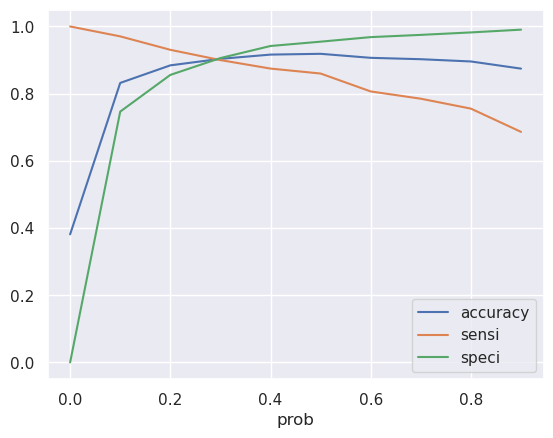

In [1644]:
# Let's plot accuracy sensitivity and specificity for various probabilities.
cutoff_df.plot.line(x='prob', y=['accuracy','sensi','speci'])
plt.show()

# we can that there is a intersection at 0.29 then we are taking that values as a cutoff

In [1645]:
y_train_pred_final['final_predicted'] = y_train_pred_final.Conv_Prob.map( lambda x: 1 if x > 0.29 else 0)
y_train_pred_final.head()

Converted   Conv_Prob    ID   predicted  0.000  0.100  0.200  0.300  \
0           0       0.002  7740           0      1      0      0      0   
1           1       0.966  7014           1      1      1      1      1   
2           0       0.004  2431           0      1      0      0      0   
3           1       0.983  3012           1      1      1      1      1   
4           0       0.165  3140           0      1      1      0      0   

   0.400  0.500  0.600  0.700  0.800  0.900   final_predicted  
0      0      0      0      0      0      0                 0  
1      1      1      1      1      1      1                 1  
2      0      0      0      0      0      0                 0  
3      1      1      1      1      1      1                 1  
4      0      0      0      0      0      0                 0

In [1646]:
# Let's check the overall accuracy.
accuracy_score(y_train_pred_final.Converted, y_train_pred_final.final_predicted)

0.9026366382861851

In [1647]:
confusion = confusion_matrix(y_train_pred_final.Converted, y_train_pred_final.final_predicted )
confusion

array([[4069,  437],
       [ 272, 2504]])

In [1648]:
# taking values for TP , TN, FP, FN
TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives

# Calculate the sensitivity
TP/(TP+FN)

# Calculate the specificity
TN/(TN+FP)

precision_score(y_train_pred_final.Converted, y_train_pred_final.predicted)
recall_score(y_train_pred_final.Converted, y_train_pred_final.predicted)

0.9020172910662824

0.9030181979582779

0.9212659204940178

0.8598703170028819

####  ----------------------------------------------------------------------

#### ROC Curve and Precision - Recall Curve

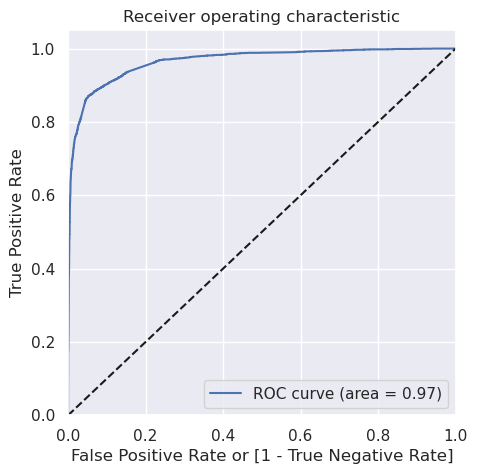

In [1649]:
# created a function for the ROC curve creation and see the lables 
def draw_roc( actual, probs ):
    fpr, tpr, thresholds = roc_curve( actual, probs, drop_intermediate = False )
    auc_score = roc_auc_score( actual, probs )
    plt.figure(figsize=(5, 5))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()
    return None

fpr, tpr, thresholds = roc_curve( y_train_pred_final.Converted, y_train_pred_final.Conv_Prob, drop_intermediate = False )
draw_roc(y_train_pred_final.Converted, y_train_pred_final.Conv_Prob)

In [1650]:
# we are looking for precision recall score using inbuilt function
precision_score(y_train_pred_final.Converted, y_train_pred_final.predicted)
recall_score(y_train_pred_final.Converted, y_train_pred_final.predicted)

0.9212659204940178

0.8598703170028819

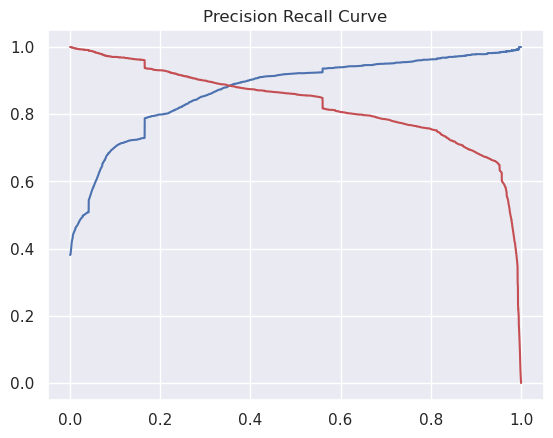

In [1651]:
# plotting Presicion and Recall curve and finding the cutoff for this.
p, r, thresholds = precision_recall_curve(y_train_pred_final.Converted, y_train_pred_final.Conv_Prob)
plt.plot(thresholds, p[:-1], "b")
plt.plot(thresholds, r[:-1], "r")
plt.title('Precision Recall Curve')
plt.show();

In [ ]:
# since we can see here that precision recall having high value than sensitivity and specificity, so we are gonna use this cutoff only
# to find out accuracy.

In [1652]:
# used the cutoff value to see the prediction on train dataset.
y_train_pred_final['final_predicted'] = y_train_pred_final.Conv_Prob.map( lambda x: 1 if x > 0.39 else 0)
y_train_pred_final.head()

Converted   Conv_Prob    ID   predicted  0.000  0.100  0.200  0.300  \
0           0       0.002  7740           0      1      0      0      0   
1           1       0.966  7014           1      1      1      1      1   
2           0       0.004  2431           0      1      0      0      0   
3           1       0.983  3012           1      1      1      1      1   
4           0       0.165  3140           0      1      1      0      0   

   0.400  0.500  0.600  0.700  0.800  0.900   final_predicted  
0      0      0      0      0      0      0                 0  
1      1      1      1      1      1      1                 1  
2      0      0      0      0      0      0                 0  
3      1      1      1      1      1      1                 1  
4      0      0      0      0      0      0                 0

In [1653]:
# Let's check the overall accuracy.
accuracy_score(y_train_pred_final.Converted, y_train_pred_final.final_predicted)

0.9147212304312002

In [1654]:
# looking at confusion_matrix.
confusion = confusion_matrix(y_train_pred_final.Converted, y_train_pred_final.final_predicted )
confusion

array([[4229,  277],
       [ 344, 2432]])

In [1655]:
TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives

# Calculate the sensitivity
TP/(TP+FN)

# Calculate the specificity
TN/(TN+FP)

precision_score(y_train_pred_final.Converted, y_train_pred_final.predicted)
recall_score(y_train_pred_final.Converted, y_train_pred_final.predicted)

0.8760806916426513

0.9385264092321349

0.9212659204940178

0.8598703170028819

###  ---------------------------------------------------------------

### Predictions on the test set

##### Custom Functions for Test

In [1656]:
# this is the function to do the prediction on test data.
def logreg_test_pred_fn(fX_test, fy_test, fcol, fcutoff, fres):
    fX_test_sm = sm.add_constant(fX_test[fcol])
    fy_test_pred = fres.predict(fX_test_sm)
    fy_test_pred = fy_test_pred.values.reshape(-1)
    fy_test_pred_final = pd.DataFrame({'Converted':fy_test.values, 'Conv_Prob':fy_test_pred})
    fy_test_pred_final['ID'] = fy_test.index
    fy_test_pred_final['predicted'] = fy_test_pred_final.Conv_Prob.map(lambda x: 1 if x > fcutoff else 0)
    return fres, fy_test_pred,fy_test_pred_final

# this is function which give us the metrics.
def logreg_test_metrics_fn(fy_test_pred_final):
    fconfusion = confusion_matrix(fy_test_pred_final.Converted, fy_test_pred_final.predicted )
    faccuracy = accuracy_score(fy_test_pred_final.Converted, fy_test_pred_final.predicted)
    return fconfusion, faccuracy

# using this we can see VIF score.
def logreg_test_VIF_score_fn(fX_test, fcol):
    fvif = pd.DataFrame()
    fvif['Features'] = fX_test[fcol].columns
    fvif['VIF'] = [variance_inflation_factor(fX_test[fcol].values, i) for i in range(fX_test[fcol].shape[1])]
    fvif['VIF'] = round(fvif['VIF'], 2)
    fvif = fvif.sort_values(by = "VIF", ascending = False)
    return fvif

#### Model Validation on Test Data

In [1657]:
# did the scaling for test data too.
X_test[to_scale] = scaler.transform(X_test[to_scale])
X_test[col].head(2)
X_test.shape

ttime_on_site  last_activity_Olark Chat Conversation  \
7421         -0.502                                 -0.345   
4570         -0.409                                 -0.345   

      last_activity_SMS Sent  lead_origin_Lead Add Form  \
7421                  -0.647                     -0.265   
4570                   1.545                     -0.265   

      lead_source_Olark Chat  lead_source_Welingak Website  \
7421                  -0.485                        -0.119   
4570                  -0.485                        -0.119   

      tags_Already a student  tags_Closed by Horizzon  \
7421                  -0.229                    5.116   
4570                  -0.229                   -0.195   

      tags_Interested in other courses  tags_Lost to EINS  \
7421                            -0.245             -0.138   
4570                            -0.245             -0.138   

      tags_Not doing further education  tags_Ringing  \
7421                            -0.127        -0.389   
4570                            -0.127        -0.389   

      tags_Will revert after reading the email  tags_switched off  
7421                                    -0.532             -0.164  
4570                                    -0.532             -0.164

(1821, 99)

In [1658]:
# since we got the cutoff after presicion recall so we are gonna use in this.
cutoff = 0.39
res, y_test_pred, y_test_pred_final = logreg_test_pred_fn(X_test, y_test, col, cutoff, res)
confusion, accuracy = logreg_test_metrics_fn(y_test_pred_final)
vif = logreg_test_VIF_score_fn(X_test, col)

# print('Model Summary:')          # Model Summary:
# res.summary()
# print('\nVIF Score:')            # VIF Score:
# vif


In [1659]:
# print('\nY_Predicted Values:')   # Y_Predicted Values:
# y_test_pred
# print('\nY_Predicted Cutoff:')   # Y_Predicted Cutoff:
# y_test_pred_final

print('\nConfusion Matrix:')     # Confusion Matrix: 
confusion
print(f'\nAccuracy Score: {accuracy}\n')  # Accuracy Score:


Confusion Matrix:


array([[1080,   65],
       [  61,  615]])


Accuracy Score: 0.9308072487644151



In [1660]:
# seeing all the metrix related to test data and prediction accuracy.
TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives

# Calculate the sensitivity
TP/(TP+FN)

# Calculate the specificity
TN/(TN+FP)

precision_score(y_train_pred_final.Converted, y_train_pred_final.predicted)
recall_score(y_train_pred_final.Converted, y_train_pred_final.predicted)

0.9097633136094675

0.9432314410480349

0.9212659204940178

0.8598703170028819

## Approach - 01 - Accuracy Score:

In [1661]:
# Now this is the final Accoracy Score on Test Dataset.
print(f'\nAccuracy Score: {accuracy}\n')  # Accuracy Score:


Accuracy Score: 0.9308072487644151



## -----------------------------------------------------

In [1662]:
# errorline # do no remove this line

In [ ]:
# There 2 more approach we have but those having less accuracy than Approach-1.

## -----------------------------------------------------

## Approach - 02

### Data Encoding

#### Label Encoding

In [1663]:
# for label_encoding:
# Since there are many categorical features with nominal values 5 we decide to use label encoding for those features

cols_to_le = lead_score_df.select_dtypes('category').columns
cols_to_le

Index(['lead_origin', 'lead_source', 'do_not_email', 'last_activity',
       'specialization', 'curr_occupation', 'tags', 'city', 'avail_free_copy'],
      dtype='object')

In [1664]:
df_le = lead_score_df.copy()

le = LabelEncoder()
df_le[cols_to_le] = df_le[cols_to_le].apply(le.fit_transform)

<Figure size 1000x600 with 0 Axes>

<Axes: >

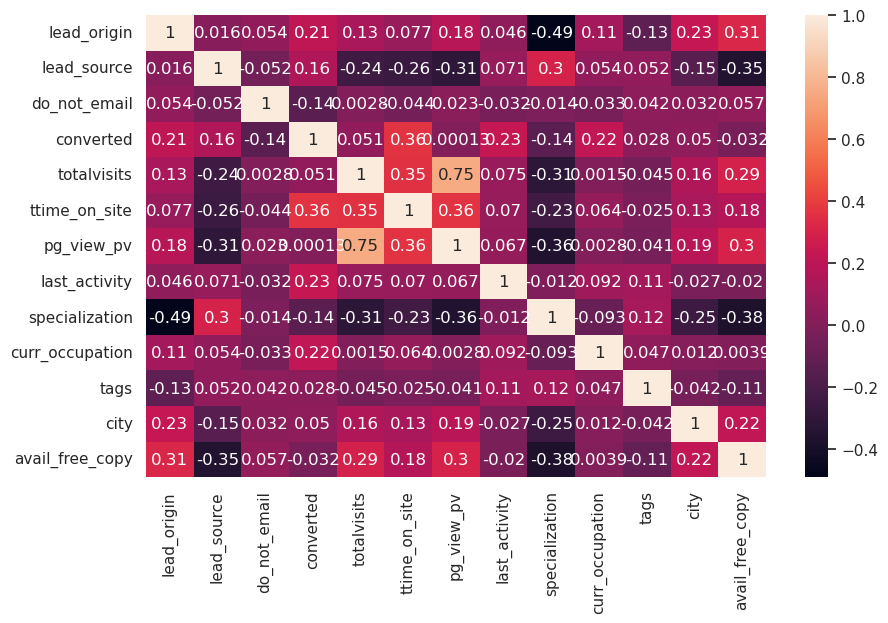

In [1665]:
plt.figure(figsize=(10, 6))
sns.heatmap(df_le.corr(), annot=True)

In [1666]:
# We then merged the encoder features with the non encoded features and name it as new lsdf

# new_ls_df = lead_score_df[lead_score_df.columns.difference(cols_to_le)]
# new_ls_df = new_ls_df.merge(right=df_le, right_index=True, left_index=True)
df_le.head(3)

lead_origin  lead_source  do_not_email  converted  totalvisits  \
0            0            6             0          0        0.000   
1            0            7             0          0        5.000   
2            1            1             0          1        2.000   

   ttime_on_site  pg_view_pv  last_activity  specialization  curr_occupation  \
0          0.000       0.000             10              18                4   
1        674.000       2.500              5              18                4   
2       1532.000       2.000              5               1                3   

   tags  city  avail_free_copy  
0     8     0                0  
1    14     0                0  
2    19     0                1

In [1667]:
# our null values have significantly reduced
null_pct = check_cols_null_pct(df_le)
null_pct[null_pct>0]
df_le.shape

Series([], dtype: float64)

(9103, 13)

In [1668]:
# new_ls_df = new_ls_df[(new_ls_df.notna()).all(axis=1)]
# check_cols_null_pct(new_ls_df)
# sorted([f'{i} - {new_ls_df[i].unique()}' for i in new_ls_df.columns])

###  ----------------------------------------------------------------------

### Train and Test Split

In [1669]:
X = df_le.drop(['converted'], axis=1)
y = df_le['converted']

In [1670]:
# Now we split the dataset into train and test set
np.random.seed(0)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=0)

###  ----------------------------------------------------------------------

### Feature Scaling

In [1671]:
# Post split we perform standard scaling they fit and transform the train data set

# to_scale = ['lead_number', 'totalvisits', 'ttime_on_site', 'pg_view_pv']
to_scale = ['totalvisits', 'ttime_on_site', 'pg_view_pv', 'lead_source', 'last_activity', 'curr_occupation']

scaler = StandardScaler()
X_train[to_scale] = scaler.fit_transform(X_train[to_scale],y_train)
X_train.head()

lead_origin  lead_source  do_not_email  totalvisits  ttime_on_site  \
7740            1       -1.063             0       -0.779         -0.376   
7014            1       -0.392             0        0.971          0.881   
2431            1       -0.392             0       -0.429         -0.337   
3012            0        0.949             0        1.672          1.539   
3140            0        0.614             0       -1.130         -0.889   

      pg_view_pv  last_activity  specialization  curr_occupation  tags  city  \
7740      -0.712         -1.823               7           -0.122     0     2   
7014      -0.150         -0.729               4           -0.122    19     0   
2431      -0.150         -0.182               8           -0.122    12     0   
3012       0.973         -0.729               5           -0.122    19     0   
3140      -1.274         -0.729              18           -0.122    25     0   

      avail_free_copy  
7740                1  
7014                0  
2431                0  
3012                0  
3140                0

###  ----------------------------------------------------------------------

### Model Building

##### Custom Functions for Model Training

In [1672]:
# We create custom functions for model veiling since iteration we reuse certain functions again and again
# Train and predict function trains the model and predicts on the same data and returns the model its probability and predicted values based on cutoff
# The matrix function returns confusion matrix and accuracy score
# The vif function returns the vif score for the features

def logreg_train_pred_fn(fX_train, fy_train, fcol, fcutoff):
    fX_train_sm = sm.add_constant(fX_train[fcol])
    flogm = sm.GLM(fy_train, fX_train_sm, family = sm.families.Binomial())
    fres = flogm.fit()
    fy_train_pred = fres.predict(fX_train_sm)
    fy_train_pred = fy_train_pred.values.reshape(-1)
    fy_train_pred_final = pd.DataFrame({'Converted':fy_train.values, 'Conv_Prob':fy_train_pred})
    fy_train_pred_final['ID'] = fy_train.index
    fy_train_pred_final['predicted'] = fy_train_pred_final.Conv_Prob.map(lambda x: 1 if x > fcutoff else 0)
    return fres, fy_train_pred,fy_train_pred_final

def logreg_metrics_fn(fy_train_pred_final):
    fconfusion = confusion_matrix(fy_train_pred_final.Converted, fy_train_pred_final.predicted )
    faccuracy = accuracy_score(fy_train_pred_final.Converted, fy_train_pred_final.predicted)
    return fconfusion, faccuracy
    
def logreg_VIF_score_fn(fX_train, fcol):
    fvif = pd.DataFrame()
    fvif['Features'] = fX_train[fcol].columns
    fvif['VIF'] = [variance_inflation_factor(fX_train[fcol].values, i) for i in range(fX_train[fcol].shape[1])]
    fvif['VIF'] = round(fvif['VIF'], 2)
    fvif = fvif.sort_values(by = "VIF", ascending = False)
    return fvif

##### Base Model 1

In [1673]:
# Logistic regression model
logm1 = sm.GLM(y_train,(sm.add_constant(X_train)), family = sm.families.Binomial())
res = logm1.fit()
# res.summary()

##### RFE - Recursive Feature Elimination

In [1674]:
# Since the data set has a lot of features we perform rfe to eliminate insignificant features

logreg = LogisticRegression()

rfe = RFE(estimator=logreg, n_features_to_select=15)             # running RFE with 15 variables as output
rfe = rfe.fit(X_train, y_train)
rfe_feature_Ranking = list(zip(X_train.columns, rfe.support_, rfe.ranking_))

In [1675]:
rfe_sorted = sorted(rfe_feature_Ranking, key=lambda x : x[2])
rfe_sorted[:15]

[('lead_origin', True, 1),
 ('lead_source', True, 1),
 ('do_not_email', True, 1),
 ('totalvisits', True, 1),
 ('ttime_on_site', True, 1),
 ('pg_view_pv', True, 1),
 ('last_activity', True, 1),
 ('specialization', True, 1),
 ('curr_occupation', True, 1),
 ('tags', True, 1),
 ('city', True, 1),
 ('avail_free_copy', True, 1)]

In [1676]:
col = X_train.columns[rfe.support_]
# X_train.columns[~rfe.support_]

##### Model 1

In [1677]:
# Now we perform model iteration as many times as possible till we get an optimum result

cutoff = 0.5
res, y_train_pred,y_train_pred_final = logreg_train_pred_fn(X_train, y_train, col, cutoff)
confusion, accuracy = logreg_metrics_fn(y_train_pred_final)
vif = logreg_VIF_score_fn(X_train, col)

print('Model Summary:')          # Model Summary:
res.summary()
print('\nVIF Score:')            # VIF Score:
vif

# print('\nY_Predicted Values:')   # Y_Predicted Values:
# y_train_pred
# print('\nY_Predicted Cutoff:')   # Y_Predicted Cutoff:
# y_train_pred_final

# print('\nConfusion Matrix:')     # Confusion Matrix: 
# confusion
# print(f'\nAccuracy Score: {accuracy}\n')       # Accuracy Score:

Model Summary:


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              converted   No. Observations:                 7282
Model:                            GLM   Df Residuals:                     7269
Model Family:                Binomial   Df Model:                           12
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -3558.5
Date:                Sun, 20 Oct 2024   Deviance:                       7117.0
Time:                        23:04:24   Pearson chi2:                 9.24e+03
No. Iterations:                     5   Pseudo R-squ. (CS):             0.2967
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -0.5614      0.121     -4.656      0.000      -0.798      -0.325
lead_origin         0.6757      0.058     11.667      0.000       0.562       0.789
lead_source         0.5132      0.035     14.595      0.000       0.444       0.582
do_not_email       -1.4810      0.145    -10.216      0.000      -1.765      -1.197
totalvisits         0.1084      0.044      2.443      0.015       0.021       0.195
ttime_on_site       1.0413      0.034     30.765      0.000       0.975       1.108
pg_view_pv         -0.4758      0.047    -10.069      0.000      -0.568      -0.383
last_activity       0.5183      0.031     16.677      0.000       0.457       0.579
specialization     -0.0415      0.006     -6.841      0.000      -0.053      -0.030
curr_occupation     0.4308      0.036     11.966      0.000       0.360       0.501
tags                0.0096      0.004      2.512      0.012       0.002       0.017
city                0.0398      0.024      1.687      0.092      -0.006       0.086
avail_free_copy    -0.4397      0.073     -5.994      0.000      -0.583      -0.296
===================================================================================
"""


VIF Score:


Features   VIF
9              tags 4.170
7    specialization 3.500
5        pg_view_pv 2.540
3       totalvisits 2.410
0       lead_origin 2.320
11  avail_free_copy 1.930
10             city 1.380
1       lead_source 1.330
4     ttime_on_site 1.220
2      do_not_email 1.100
6     last_activity 1.040
8   curr_occupation 1.040

##### Model 2

In [1678]:
# col = col.drop('avail_free_copy_1', 1)
# col

col = col.drop('city', 1)
col

cutoff = 0.5
res, y_train_pred,y_train_pred_final = logreg_train_pred_fn(X_train, y_train, col, cutoff)
confusion, accuracy = logreg_metrics_fn(y_train_pred_final)
vif = logreg_VIF_score_fn(X_train, col)

print('Model Summary:')          # Model Summary:
res.summary()
print('\nVIF Score:')            # VIF Score:
vif

# print('\nY_Predicted Values:')   # Y_Predicted Values:
# y_train_pred
# print('\nY_Predicted Cutoff:')   # Y_Predicted Cutoff:
# y_train_pred_final

print('\nConfusion Matrix:')     # Confusion Matrix: 
confusion
print(f'\nAccuracy Score: {accuracy}\n')   # Accuracy Score:

Index(['lead_origin', 'lead_source', 'do_not_email', 'totalvisits',
       'ttime_on_site', 'pg_view_pv', 'last_activity', 'specialization',
       'curr_occupation', 'tags', 'avail_free_copy'],
      dtype='object')

Model Summary:


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              converted   No. Observations:                 7282
Model:                            GLM   Df Residuals:                     7270
Model Family:                Binomial   Df Model:                           11
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -3559.9
Date:                Sun, 20 Oct 2024   Deviance:                       7119.9
Time:                        23:04:24   Pearson chi2:                 9.27e+03
No. Iterations:                     5   Pseudo R-squ. (CS):             0.2964
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -0.5380      0.120     -4.492      0.000      -0.773      -0.303
lead_origin         0.6887      0.057     11.986      0.000       0.576       0.801
lead_source         0.5109      0.035     14.541      0.000       0.442       0.580
do_not_email       -1.4786      0.145    -10.196      0.000      -1.763      -1.194
totalvisits         0.1102      0.044      2.484      0.013       0.023       0.197
ttime_on_site       1.0427      0.034     30.828      0.000       0.976       1.109
pg_view_pv         -0.4724      0.047    -10.014      0.000      -0.565      -0.380
last_activity       0.5156      0.031     16.622      0.000       0.455       0.576
specialization     -0.0423      0.006     -6.991      0.000      -0.054      -0.030
curr_occupation     0.4307      0.036     11.954      0.000       0.360       0.501
tags                0.0096      0.004      2.530      0.011       0.002       0.017
avail_free_copy    -0.4317      0.073     -5.899      0.000      -0.575      -0.288
===================================================================================
"""


VIF Score:


Features   VIF
9              tags 4.140
7    specialization 3.500
5        pg_view_pv 2.540
3       totalvisits 2.400
0       lead_origin 2.200
10  avail_free_copy 1.910
1       lead_source 1.320
4     ttime_on_site 1.220
2      do_not_email 1.100
6     last_activity 1.040
8   curr_occupation 1.040


Confusion Matrix:


array([[3941,  565],
       [1047, 1729]])


Accuracy Score: 0.7786322438890415



In [1679]:
TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives

# Calculate the sensitivity
TP/(TP+FN)

# Calculate the specificity
TN/(TN+FP)

0.6228386167146974

0.8746116289391922

####  ----------------------------------------------------------------------

#### Finding Optimal Cutoff Point

In [1680]:
# Let's create columns with different probability cutoffs 
numbers = [float(x)/10 for x in range(10)]
for i in numbers:
    y_train_pred_final[i]= y_train_pred_final.Conv_Prob.map(lambda x: 1 if x > i else 0)
y_train_pred_final.head()

Converted   Conv_Prob    ID   predicted  0.000  0.100  0.200  0.300  \
0           0       0.095  7740           0      1      0      0      0   
1           1       0.653  7014           1      1      1      1      1   
2           0       0.322  2431           0      1      1      1      1   
3           1       0.694  3012           1      1      1      1      1   
4           0       0.165  3140           0      1      1      0      0   

   0.400  0.500  0.600  0.700  0.800  0.900  
0      0      0      0      0      0      0  
1      1      1      1      0      0      0  
2      0      0      0      0      0      0  
3      1      1      1      0      0      0  
4      0      0      0      0      0      0

In [1681]:
# Now let's calculate accuracy sensitivity and specificity for various probability cutoffs.
cutoff_df = pd.DataFrame( columns = ['prob','accuracy','sensi','speci'])

num = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
for i in num:
    cm1 = confusion_matrix(y_train_pred_final.Converted, y_train_pred_final[i] )
    total1=sum(sum(cm1))
    accuracy = (cm1[0,0]+cm1[1,1])/total1
    
    speci = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    sensi = cm1[1,1]/(cm1[1,0]+cm1[1,1])
    cutoff_df.loc[i] =[ i ,accuracy,sensi,speci]
print(cutoff_df)

       prob  accuracy  sensi  speci
0.000 0.000     0.381  1.000  0.000
0.100 0.100     0.492  0.974  0.194
0.200 0.200     0.642  0.885  0.492
0.300 0.300     0.762  0.818  0.727
0.400 0.400     0.779  0.714  0.820
0.500 0.500     0.779  0.623  0.875
0.600 0.600     0.766  0.525  0.914
0.700 0.700     0.740  0.408  0.945
0.800 0.800     0.700  0.261  0.971
0.900 0.900     0.652  0.100  0.993


<Axes: xlabel='prob'>

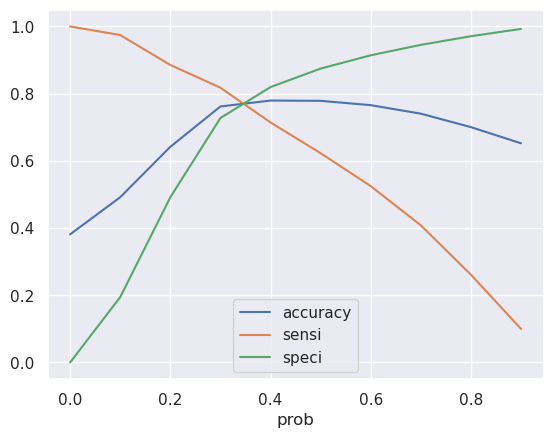

In [1682]:
# Let's plot accuracy sensitivity and specificity for various probabilities.
cutoff_df.plot.line(x='prob', y=['accuracy','sensi','speci'])
plt.show()

In [1683]:
y_train_pred_final['final_predicted'] = y_train_pred_final.Conv_Prob.map( lambda x: 1 if x > 0.36 else 0)
y_train_pred_final.head()

Converted   Conv_Prob    ID   predicted  0.000  0.100  0.200  0.300  \
0           0       0.095  7740           0      1      0      0      0   
1           1       0.653  7014           1      1      1      1      1   
2           0       0.322  2431           0      1      1      1      1   
3           1       0.694  3012           1      1      1      1      1   
4           0       0.165  3140           0      1      1      0      0   

   0.400  0.500  0.600  0.700  0.800  0.900   final_predicted  
0      0      0      0      0      0      0                 0  
1      1      1      1      0      0      0                 1  
2      0      0      0      0      0      0                 0  
3      1      1      1      0      0      0                 1  
4      0      0      0      0      0      0                 0

In [1684]:
# Let's check the overall accuracy.
accuracy_score(y_train_pred_final.Converted, y_train_pred_final.final_predicted)

0.7728645976380115

In [1685]:
confusion = confusion_matrix(y_train_pred_final.Converted, y_train_pred_final.final_predicted )
confusion

array([[3564,  942],
       [ 712, 2064]])

In [1686]:
TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives

# Calculate the sensitivity
TP/(TP+FN)

# Calculate the specificity
TN/(TN+FP)

0.7435158501440923

0.7909454061251664

####  ----------------------------------------------------------------------

#### ROC Curve and Precision - Recall Curve

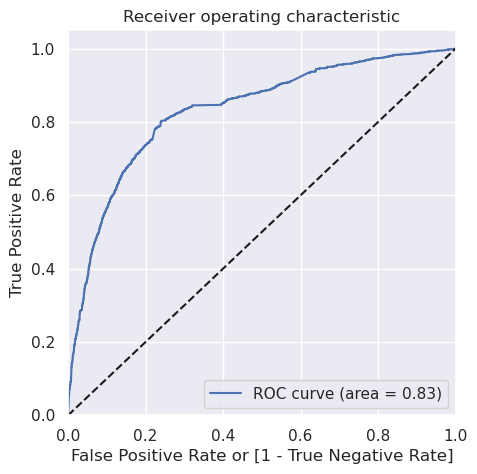

In [1687]:
def draw_roc( actual, probs ):
    fpr, tpr, thresholds = roc_curve( actual, probs, drop_intermediate = False )
    auc_score = roc_auc_score( actual, probs )
    plt.figure(figsize=(5, 5))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()
    return None

fpr, tpr, thresholds = roc_curve( y_train_pred_final.Converted, y_train_pred_final.Conv_Prob, drop_intermediate = False )
draw_roc(y_train_pred_final.Converted, y_train_pred_final.Conv_Prob)

In [1688]:
precision_score(y_train_pred_final.Converted, y_train_pred_final.predicted)
recall_score(y_train_pred_final.Converted, y_train_pred_final.predicted)

0.7537053182214473

0.6228386167146974

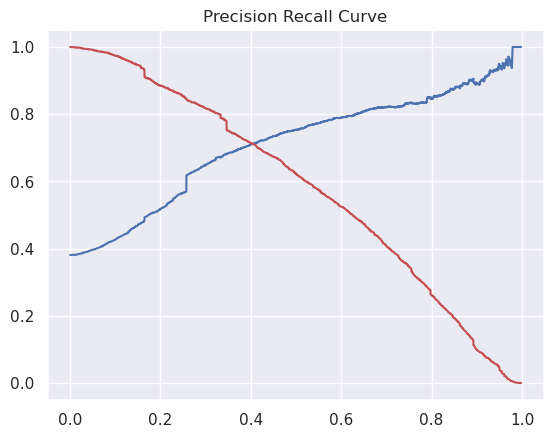

In [1689]:
p, r, thresholds = precision_recall_curve(y_train_pred_final.Converted, y_train_pred_final.Conv_Prob)
plt.plot(thresholds, p[:-1], "b")
plt.plot(thresholds, r[:-1], "r")
plt.title('Precision Recall Curve')
plt.show();

In [1690]:
y_train_pred_final['final_predicted'] = y_train_pred_final.Conv_Prob.map( lambda x: 1 if x > 0.40 else 0)
y_train_pred_final.head()

Converted   Conv_Prob    ID   predicted  0.000  0.100  0.200  0.300  \
0           0       0.095  7740           0      1      0      0      0   
1           1       0.653  7014           1      1      1      1      1   
2           0       0.322  2431           0      1      1      1      1   
3           1       0.694  3012           1      1      1      1      1   
4           0       0.165  3140           0      1      1      0      0   

   0.400  0.500  0.600  0.700  0.800  0.900   final_predicted  
0      0      0      0      0      0      0                 0  
1      1      1      1      0      0      0                 1  
2      0      0      0      0      0      0                 0  
3      1      1      1      0      0      0                 1  
4      0      0      0      0      0      0                 0

In [1691]:
# Let's check the overall accuracy.
accuracy_score(y_train_pred_final.Converted, y_train_pred_final.final_predicted)

0.7794561933534743

In [1692]:
confusion = confusion_matrix(y_train_pred_final.Converted, y_train_pred_final.final_predicted )
confusion

array([[3693,  813],
       [ 793, 1983]])

In [1693]:
TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives

# Calculate the sensitivity
TP/(TP+FN)

# Calculate the specificity
TN/(TN+FP)

precision_score(y_train_pred_final.Converted, y_train_pred_final.predicted)
recall_score(y_train_pred_final.Converted, y_train_pred_final.predicted)

0.7143371757925072

0.8195739014647138

0.7537053182214473

0.6228386167146974

###  ----------------------------------------------------------------------

### Predictions on the test set

##### Custom Functions for Test

In [1694]:
def logreg_test_pred_fn(fX_test, fy_test, fcol, fcutoff, fres):
    fX_test_sm = sm.add_constant(fX_test[fcol])
    fy_test_pred = fres.predict(fX_test_sm)
    fy_test_pred = fy_test_pred.values.reshape(-1)
    fy_test_pred_final = pd.DataFrame({'Converted':fy_test.values, 'Conv_Prob':fy_test_pred})
    fy_test_pred_final['ID'] = fy_test.index
    fy_test_pred_final['predicted'] = fy_test_pred_final.Conv_Prob.map(lambda x: 1 if x > fcutoff else 0)
    return fres, fy_test_pred,fy_test_pred_final

def logreg_test_metrics_fn(fy_test_pred_final):
    fconfusion = confusion_matrix(fy_test_pred_final.Converted, fy_test_pred_final.predicted )
    faccuracy = accuracy_score(fy_test_pred_final.Converted, fy_test_pred_final.predicted)
    return fconfusion, faccuracy
    
def logreg_test_VIF_score_fn(fX_test, fcol):
    fvif = pd.DataFrame()
    fvif['Features'] = fX_test[fcol].columns
    fvif['VIF'] = [variance_inflation_factor(fX_test[fcol].values, i) for i in range(fX_test[fcol].shape[1])]
    fvif['VIF'] = round(fvif['VIF'], 2)
    fvif = fvif.sort_values(by = "VIF", ascending = False)
    return fvif

#### Model Validation on Test Data

In [1695]:
X_test[to_scale] = scaler.transform(X_test[to_scale])
X_test[col].head()

lead_origin  lead_source  do_not_email  totalvisits  ttime_on_site  \
7421            1       -1.063             1        2.722         -0.502   
4570            1       -0.392             1       -0.079         -0.409   
5302            0        0.614             0       -1.130         -0.889   
6471            1        0.949             1        0.971         -0.293   
8958            1       -1.063             0        0.271          0.708   

      pg_view_pv  last_activity  specialization  curr_occupation  tags  \
7421       0.102          0.639               4           -0.122     2   
4570       0.411          1.186              12           -0.122    25   
5302      -1.274          0.365              18           -0.122    25   
6471       2.096          1.186              13           -0.122    24   
8958      -0.150         -0.729               7           -0.122     0   

      avail_free_copy  
7421                1  
4570                0  
5302                0  
6471                1  
8958                1

In [1696]:
cutoff = 0.39
res, y_test_pred, y_test_pred_final = logreg_test_pred_fn(X_test, y_test, col, cutoff, res)
confusion, accuracy = logreg_test_metrics_fn(y_test_pred_final)
vif = logreg_test_VIF_score_fn(X_test, col)

print('Model Summary:')          # Model Summary:
res.summary()
print('\nVIF Score:')            # VIF Score:
vif

# print('\nY_Predicted Values:')   # Y_Predicted Values:
# y_test_pred
# print('\nY_Predicted Cutoff:')   # Y_Predicted Cutoff:
# y_test_pred_final

Model Summary:


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              converted   No. Observations:                 7282
Model:                            GLM   Df Residuals:                     7270
Model Family:                Binomial   Df Model:                           11
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -3559.9
Date:                Sun, 20 Oct 2024   Deviance:                       7119.9
Time:                        23:04:25   Pearson chi2:                 9.27e+03
No. Iterations:                     5   Pseudo R-squ. (CS):             0.2964
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -0.5380      0.120     -4.492      0.000      -0.773      -0.303
lead_origin         0.6887      0.057     11.986      0.000       0.576       0.801
lead_source         0.5109      0.035     14.541      0.000       0.442       0.580
do_not_email       -1.4786      0.145    -10.196      0.000      -1.763      -1.194
totalvisits         0.1102      0.044      2.484      0.013       0.023       0.197
ttime_on_site       1.0427      0.034     30.828      0.000       0.976       1.109
pg_view_pv         -0.4724      0.047    -10.014      0.000      -0.565      -0.380
last_activity       0.5156      0.031     16.622      0.000       0.455       0.576
specialization     -0.0423      0.006     -6.991      0.000      -0.054      -0.030
curr_occupation     0.4307      0.036     11.954      0.000       0.360       0.501
tags                0.0096      0.004      2.530      0.011       0.002       0.017
avail_free_copy    -0.4317      0.073     -5.899      0.000      -0.575      -0.288
===================================================================================
"""


VIF Score:


Features   VIF
9              tags 4.370
7    specialization 3.680
5        pg_view_pv 2.470
3       totalvisits 2.360
0       lead_origin 2.140
10  avail_free_copy 1.940
1       lead_source 1.320
4     ttime_on_site 1.260
2      do_not_email 1.110
6     last_activity 1.040
8   curr_occupation 1.040

In [1697]:
print('\nConfusion Matrix:')     # Confusion Matrix: 
confusion
print(f'\nAccuracy Score: {accuracy}\n')  # Accuracy Score:


Confusion Matrix:


array([[948, 197],
       [195, 481]])


Accuracy Score: 0.7847336628226249



In [1698]:
TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives

# Calculate the sensitivity
TP/(TP+FN)

# Calculate the specificity
TN/(TN+FP)

precision_score(y_train_pred_final.Converted, y_train_pred_final.predicted)
recall_score(y_train_pred_final.Converted, y_train_pred_final.predicted)

0.7115384615384616

0.8279475982532751

0.7537053182214473

0.6228386167146974

## Approach - 02 - Accuracy Score:

In [1699]:
print(f'\nAccuracy Score: {accuracy}\n')  # Accuracy Score:


Accuracy Score: 0.7847336628226249



## -----------------------------------------------------

In [1700]:
# errorline #do not remove

## -----------------------------------------------------

## Approach - 03

### Data Encoding

#### Dummy Encoding

In [1701]:
#  we perform dummy encoding

new_ls_df = pd.get_dummies(lead_score_df, columns=lead_score_df.select_dtypes('category').columns.difference(['tags','specialization']), drop_first=True, dtype=float)
new_ls_df.head(1)

new_ls_df = pd.get_dummies(new_ls_df, columns=['tags','specialization'], dtype=float)
new_ls_df = new_ls_df.drop(['tags_unknown','specialization_unknown'], axis=1)
new_ls_df.head(1)

converted  totalvisits  ttime_on_site  pg_view_pv specialization  \
0          0        0.000          0.000       0.000        unknown   

                          tags  avail_free_copy_1  city_Other Cities  \
0  Interested in other courses              0.000              0.000   

   city_Other Cities of Maharashtra  city_Other Metro Cities  \
0                             0.000                    0.000   

   city_Thane & Outskirts  city_Tier II Cities  curr_occupation_Housewife  \
0                   0.000                0.000                      0.000   

   curr_occupation_Other  curr_occupation_Student  curr_occupation_Unemployed  \
0                  0.000                    0.000                       1.000   

   curr_occupation_Working Professional  do_not_email_1  \
0                                 0.000           0.000   

   last_activity_Converted to Lead  last_activity_Email Bounced  \
0                            0.000                        0.000   

   last_activity_Email Link Clicked  last_activity_Email Marked Spam  \
0                             0.000                            0.000   

   last_activity_Email Opened  last_activity_Email Received  \
0                       0.000                         0.000   

   last_activity_Form Submitted on Website  \
0                                    0.000   

   last_activity_Had a Phone Conversation  \
0                                   0.000   

   last_activity_Olark Chat Conversation  \
0                                  0.000   

   last_activity_Page Visited on Website  \
0                                  1.000   

   last_activity_Resubscribed to emails  last_activity_SMS Sent  \
0                                 0.000                   0.000   

   last_activity_Unreachable  last_activity_Unsubscribed  \
0                      0.000                       0.000   

   last_activity_View in browser link Clicked  \
0                                       0.000   

   last_activity_Visited Booth in Tradeshow  \
0                                     0.000   

   lead_origin_Landing Page Submission  lead_origin_Lead Add Form  \
0                                0.000                      0.000   

   lead_origin_Lead Import  lead_origin_Quick Add Form  \
0                    0.000                       0.000   

   lead_source_Direct Traffic  lead_source_Facebook  lead_source_Google  \
0                       0.000                 0.000               0.000   

   lead_source_Live Chat  lead_source_NC_EDM  lead_source_Olark Chat  \
0                  0.000               0.000                   1.000   

   lead_source_Organic Search  lead_source_Pay per Click Ads  \
0                       0.000                          0.000   

   lead_source_Press_Release  lead_source_Reference  \
0                      0.000                  0.000   

   lead_source_Referral Sites  lead_source_Social Media  lead_source_WeLearn  \
0                       0.000                     0.000                0.000   

   lead_source_Welingak Website  lead_source_bing  lead_source_blog  \
0                         0.000             0.000             0.000   

   lead_source_google  lead_source_testone  lead_source_welearnblog_Home  \
0               0.000                0.000                         0.000   

   lead_source_youtubechannel  
0                       0.000

converted  totalvisits  ttime_on_site  pg_view_pv  avail_free_copy_1  \
0          0        0.000          0.000       0.000              0.000   

   city_Other Cities  city_Other Cities of Maharashtra  \
0              0.000                             0.000   

   city_Other Metro Cities  city_Thane & Outskirts  city_Tier II Cities  \
0                    0.000                   0.000                0.000   

   curr_occupation_Housewife  curr_occupation_Other  curr_occupation_Student  \
0                      0.000                  0.000                    0.000   

   curr_occupation_Unemployed  curr_occupation_Working Professional  \
0                       1.000                                 0.000   

   do_not_email_1  last_activity_Converted to Lead  \
0           0.000                            0.000   

   last_activity_Email Bounced  last_activity_Email Link Clicked  \
0                        0.000                             0.000   

   last_activity_Email Marked Spam  last_activity_Email Opened  \
0                            0.000                       0.000   

   last_activity_Email Received  last_activity_Form Submitted on Website  \
0                         0.000                                    0.000   

   last_activity_Had a Phone Conversation  \
0                                   0.000   

   last_activity_Olark Chat Conversation  \
0                                  0.000   

   last_activity_Page Visited on Website  \
0                                  1.000   

   last_activity_Resubscribed to emails  last_activity_SMS Sent  \
0                                 0.000                   0.000   

   last_activity_Unreachable  last_activity_Unsubscribed  \
0                      0.000                       0.000   

   last_activity_View in browser link Clicked  \
0                                       0.000   

   last_activity_Visited Booth in Tradeshow  \
0                                     0.000   

   lead_origin_Landing Page Submission  lead_origin_Lead Add Form  \
0                                0.000                      0.000   

   lead_origin_Lead Import  lead_origin_Quick Add Form  \
0                    0.000                       0.000   

   lead_source_Direct Traffic  lead_source_Facebook  lead_source_Google  \
0                       0.000                 0.000               0.000   

   lead_source_Live Chat  lead_source_NC_EDM  lead_source_Olark Chat  \
0                  0.000               0.000                   1.000   

   lead_source_Organic Search  lead_source_Pay per Click Ads  \
0                       0.000                          0.000   

   lead_source_Press_Release  lead_source_Reference  \
0                      0.000                  0.000   

   lead_source_Referral Sites  lead_source_Social Media  lead_source_WeLearn  \
0                       0.000                     0.000                0.000   

   lead_source_Welingak Website  lead_source_bing  lead_source_blog  \
0                         0.000             0.000             0.000   

   lead_source_google  lead_source_testone  lead_source_welearnblog_Home  \
0               0.000                0.000                         0.000   

   lead_source_youtubechannel  tags_Already a student  tags_Busy  \
0                       0.000                   0.000      0.000   

   tags_Closed by Horizzon  tags_Diploma holder (Not Eligible)  \
0                    0.000                               0.000   

   tags_Graduation in progress  tags_In confusion whether part time or DLP  \
0                        0.000                                       0.000   

   tags_Interested  in full time MBA  tags_Interested in Next batch  \
0                              0.000                          0.000   

   tags_Interested in other courses  tags_Lateral student  tags_Lost to EINS  \
0                             1.000                 0.000              0.000   

   tags_Lost to Others  tags_Not doing further ed

###  ----------------------------------------------------------------------

### Train and Test Split

In [1702]:
X = new_ls_df.drop(['converted'], axis=1)
y = new_ls_df['converted']

In [1703]:
# Now we split the dataset into train and test set
np.random.seed(0)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=0)

###  ----------------------------------------------------------------------

### Feature Scaling

In [1704]:
new_ls_df.dtypes

converted                                                   int64
totalvisits                                               float64
ttime_on_site                                             float64
pg_view_pv                                                float64
avail_free_copy_1                                         float64
city_Other Cities                                         float64
city_Other Cities of Maharashtra                          float64
city_Other Metro Cities                                   float64
city_Thane & Outskirts                                    float64
city_Tier II Cities                                       float64
curr_occupation_Housewife                                 float64
curr_occupation_Other                                     float64
curr_occupation_Student                                   float64
curr_occupation_Unemployed                                float64
curr_occupation_Working Professional                      float64
do_not_ema

In [1705]:
# Post split we perform standard scaling they fit and transform the train data set

# to_scale = ['lead_number', 'totalvisits', 'ttime_on_site', 'pg_view_pv']
to_scale = X.columns
to_scale

scaler = MinMaxScaler()
X_train[to_scale] = scaler.fit_transform(X_train[to_scale], y_train)
X_train.head()

Index(['totalvisits', 'ttime_on_site', 'pg_view_pv', 'avail_free_copy_1',
       'city_Other Cities', 'city_Other Cities of Maharashtra',
       'city_Other Metro Cities', 'city_Thane & Outskirts',
       'city_Tier II Cities', 'curr_occupation_Housewife',
       'curr_occupation_Other', 'curr_occupation_Student',
       'curr_occupation_Unemployed', 'curr_occupation_Working Professional',
       'do_not_email_1', 'last_activity_Converted to Lead',
       'last_activity_Email Bounced', 'last_activity_Email Link Clicked',
       'last_activity_Email Marked Spam', 'last_activity_Email Opened',
       'last_activity_Email Received',
       'last_activity_Form Submitted on Website',
       'last_activity_Had a Phone Conversation',
       'last_activity_Olark Chat Conversation',
       'last_activity_Page Visited on Website',
       'last_activity_Resubscribed to emails', 'last_activity_SMS Sent',
       'last_activity_Unreachable', 'last_activity_Unsubscribed',
       'last_activity_View i

totalvisits  ttime_on_site  pg_view_pv  avail_free_copy_1  \
7740        0.091          0.124       0.167              1.000   
7014        0.545          0.426       0.333              0.000   
2431        0.182          0.133       0.333              0.000   
3012        0.727          0.585       0.667              0.000   
3140        0.000          0.000       0.000              0.000   

      city_Other Cities  city_Other Cities of Maharashtra  \
7740              0.000                             1.000   
7014              0.000                             0.000   
2431              0.000                             0.000   
3012              0.000                             0.000   
3140              0.000                             0.000   

      city_Other Metro Cities  city_Thane & Outskirts  city_Tier II Cities  \
7740                    0.000                   0.000                0.000   
7014                    0.000                   0.000                0.000   
2431                    0.000                   0.000                0.000   
3012                    0.000                   0.000                0.000   
3140                    0.000                   0.000                0.000   

      curr_occupation_Housewife  curr_occupation_Other  \
7740                      0.000                  0.000   
7014                      0.000                  0.000   
2431                      0.000                  0.000   
3012                      0.000                  0.000   
3140                      0.000                  0.000   

      curr_occupation_Student  curr_occupation_Unemployed  \
7740                    0.000                       1.000   
7014                    0.000                       1.000   
2431                    0.000                       1.000   
3012                    0.000                       1.000   
3140                    0.000                       1.000   

      curr_occupation_Working Professional  do_not_email_1  \
7740                                 0.000           0.000   
7014                                 0.000           0.000   
2431                                 0.000           0.000   
3012                                 0.000           0.000   
3140                                 0.000           0.000   

      last_activity_Converted to Lead  last_activity_Email Bounced  \
7740                            1.000                        0.000   
7014                            0.000                        0.000   
2431                            0.000                        0.000   
3012                            0.000                        0.000   
3140                            0.000                        0.000   

      last_activity_Email Link Clicked  last_activity_Email Marked Spam  \
7740                             0.000                            0.000   
7014                             0.000                            0.000   
2431                             0.000                            0.000   
3012                             0.000                            0.000   
3140                             0.000                            0.000   

      last_activity_Email Opened  last_activity_Email Received  \
7740                       0.000                         0.000   
7014                       1.000                         0.000   
2431                       0.000                         0.000   
3012                       1.000                         0.000   
3140                       1.000                         0.000   

      last_activity_Form Submitted on Website  \
7740                                    0.000   
7014                                    0.000   
2431                                    1.000   
3012                                    0.000   
3140                                    0.000   

      last_activity_Had a Phone Conversation  \
7740                                   0.000   
7014              

###  ----------------------------------------------------------------------

### Model Building

##### Custom Functions for Model Training

In [1706]:
# We create custom functions for model veiling since iteration we reuse certain functions again and again
# Train and predict function trains the model and predicts on the same data and returns the model its probability and predicted values based on cutoff
# The matrix function returns confusion matrix and accuracy score
# The vif function returns the vif score for the features

def logreg_train_pred_fn(fX_train, fy_train, fcol, fcutoff):
    fX_train_sm = sm.add_constant(fX_train[fcol])
    flogm = sm.GLM(fy_train, fX_train_sm, family = sm.families.Binomial())
    fres = flogm.fit()
    fy_train_pred = fres.predict(fX_train_sm)
    fy_train_pred = fy_train_pred.values.reshape(-1)
    fy_train_pred_final = pd.DataFrame({'Converted':fy_train.values, 'Conv_Prob':fy_train_pred})
    fy_train_pred_final['ID'] = fy_train.index
    fy_train_pred_final['predicted'] = fy_train_pred_final.Conv_Prob.map(lambda x: 1 if x > fcutoff else 0)
    return fres, fy_train_pred,fy_train_pred_final

def logreg_metrics_fn(fy_train_pred_final):
    fconfusion = confusion_matrix(fy_train_pred_final.Converted, fy_train_pred_final.predicted )
    faccuracy = accuracy_score(fy_train_pred_final.Converted, fy_train_pred_final.predicted)
    return fconfusion, faccuracy
    
def logreg_VIF_score_fn(fX_train, fcol):
    fvif = pd.DataFrame()
    fvif['Features'] = fX_train[fcol].columns
    fvif['VIF'] = [variance_inflation_factor(fX_train[fcol].values, i) for i in range(fX_train[fcol].shape[1])]
    fvif['VIF'] = round(fvif['VIF'], 2)
    fvif = fvif.sort_values(by = "VIF", ascending = False)
    return fvif

##### Base Model 1

In [1707]:
# Logistic regression model
logm1 = sm.GLM(y_train,(sm.add_constant(X_train)), family = sm.families.Binomial())
res = logm1.fit()
# res.summary()

##### RFE - Recursive Feature Elimination

In [1708]:
# Since the data set has a lot of features we perform rfe to eliminate insignificant features
logreg = LogisticRegression()

rfe = RFE(estimator=logreg, n_features_to_select=15)             # running RFE with 15 variables as output
rfe = rfe.fit(X_train, y_train)
rfe_feature_Ranking = list(zip(X_train.columns, rfe.support_, rfe.ranking_))

In [1709]:
rfe_sorted = sorted(rfe_feature_Ranking, key=lambda x : x[2])
rfe_sorted[:15]

[('ttime_on_site', True, 1),
 ('last_activity_SMS Sent', True, 1),
 ('lead_source_Welingak Website', True, 1),
 ('tags_Already a student', True, 1),
 ('tags_Closed by Horizzon', True, 1),
 ('tags_Interested  in full time MBA', True, 1),
 ('tags_Interested in other courses', True, 1),
 ('tags_Lost to EINS', True, 1),
 ('tags_Not doing further education', True, 1),
 ('tags_Ringing', True, 1),
 ('tags_Will revert after reading the email', True, 1),
 ('tags_invalid number', True, 1),
 ('tags_number not provided', True, 1),
 ('tags_switched off', True, 1),
 ('tags_wrong number given', True, 1)]

In [1710]:
col = X_train.columns[rfe.support_]
# X_train.columns[~rfe.support_]

##### Model 1

In [1711]:
# Now we perform model iteration as many times as possible till we get an optimum result

cutoff = 0.5
res, y_train_pred,y_train_pred_final = logreg_train_pred_fn(X_train, y_train, col, cutoff)
confusion, accuracy = logreg_metrics_fn(y_train_pred_final)
vif = logreg_VIF_score_fn(X_train, col)

print('Model Summary:')          # Model Summary:
res.summary()
print('\nVIF Score:')            # VIF Score:
vif

# print('\nY_Predicted Values:')   # Y_Predicted Values:
# y_train_pred
# print('\nY_Predicted Cutoff:')   # Y_Predicted Cutoff:
# y_train_pred_final
# print('\nConfusion Matrix:')     # Confusion Matrix: 
# confusion
# print(f'\nAccuracy Score: {accuracy}\n')       # Accuracy Score:

Model Summary:


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              converted   No. Observations:                 7282
Model:                            GLM   Df Residuals:                     7266
Model Family:                Binomial   Df Model:                           15
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1654.3
Date:                Sun, 20 Oct 2024   Deviance:                       3308.7
Time:                        23:04:34   Pearson chi2:                 7.92e+03
No. Iterations:                    23   Pseudo R-squ. (CS):             0.5831
Covariance Type:            nonrobust                                         
============================================================================================================
                                               coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------
const                                       -2.5738      0.080    -32.306      0.000      -2.730      -2.418
ttime_on_site                                3.3673      0.186     18.083      0.000       3.002       3.732
last_activity_SMS Sent                       1.9695      0.097     20.333      0.000       1.780       2.159
lead_source_Welingak Website                 5.9595      1.015      5.869      0.000       3.969       7.950
tags_Already a student                      -3.4976      0.714     -4.898      0.000      -4.897      -2.098
tags_Closed by Horizzon                      6.6849      0.715      9.351      0.000       5.284       8.086
tags_Interested  in full time MBA           -2.3781      0.752     -3.163      0.002      -3.852      -0.904
tags_Interested in other courses            -2.0603      0.311     -6.625      0.000      -2.670      -1.451
tags_Lost to EINS                            5.0236      0.519      9.687      0.000       4.007       6.040
tags_Not doing further education            -3.1741      1.011     -3.139      0.002      -5.156      -1.192
tags_Ringing                                -2.9089      0.204    -14.230      0.000      -3.310      -2.508
tags_Will revert after reading the email     4.5600      0.158     28.854      0.000       4.250       4.870
tags_invalid number                         -3.4463      1.073     -3.211      0.001      -5.550      -1.343
tags_number not provided                   -24.2221   2.73e+04     -0.001      0.999   -5.36e+04    5.36e+04
tags_switched off                           -3.2715      0.519     -6.306      0.000      -4.288      -2.255
tags_wrong number given                    -23.8951   1.93e+04     -0.001      0.999   -3.78e+04    3.77e+04
============================================================================================================
"""


VIF Score:


Features   VIF
0                              ttime_on_site 1.650
10  tags_Will revert after reading the email 1.530
1                     last_activity_SMS Sent 1.480
9                               tags_Ringing 1.120
4                    tags_Closed by Horizzon 1.050
7                          tags_Lost to EINS 1.040
2               lead_source_Welingak Website 1.030
13                         tags_switched off 1.030
6           tags_Interested in other courses 1.020
3                     tags_Already a student 1.010
5          tags_Interested  in full time MBA 1.010
8           tags_Not doing further education 1.010
11                       tags_invalid number 1.010
14                   tags_wrong number given 1.010
12                  tags_number not provided 1.000

##### Model 2

In [1712]:
col = col.drop('tags_number not provided', 1)
col

cutoff = 0.5
res, y_train_pred,y_train_pred_final = logreg_train_pred_fn(X_train, y_train, col, cutoff)
confusion, accuracy = logreg_metrics_fn(y_train_pred_final)
vif = logreg_VIF_score_fn(X_train, col)

print('Model Summary:')          # Model Summary:
res.summary()
print('\nVIF Score:')            # VIF Score:
vif

# print('\nY_Predicted Values:')   # Y_Predicted Values:
# y_train_pred
# print('\nY_Predicted Cutoff:')   # Y_Predicted Cutoff:
# y_train_pred_final
# print('\nConfusion Matrix:')     # Confusion Matrix: 
# confusion
# print(f'\nAccuracy Score: {accuracy}\n')   # Accuracy Score:

Index(['ttime_on_site', 'last_activity_SMS Sent',
       'lead_source_Welingak Website', 'tags_Already a student',
       'tags_Closed by Horizzon', 'tags_Interested  in full time MBA',
       'tags_Interested in other courses', 'tags_Lost to EINS',
       'tags_Not doing further education', 'tags_Ringing',
       'tags_Will revert after reading the email', 'tags_invalid number',
       'tags_switched off', 'tags_wrong number given'],
      dtype='object')

Model Summary:


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              converted   No. Observations:                 7282
Model:                            GLM   Df Residuals:                     7267
Model Family:                Binomial   Df Model:                           14
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1662.5
Date:                Sun, 20 Oct 2024   Deviance:                       3325.0
Time:                        23:04:34   Pearson chi2:                 7.89e+03
No. Iterations:                    22   Pseudo R-squ. (CS):             0.5822
Covariance Type:            nonrobust                                         
============================================================================================================
                                               coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------
const                                       -2.5765      0.080    -32.391      0.000      -2.732      -2.421
ttime_on_site                                3.3419      0.186     18.012      0.000       2.978       3.706
last_activity_SMS Sent                       1.9566      0.096     20.279      0.000       1.768       2.146
lead_source_Welingak Website                 5.9655      1.015      5.875      0.000       3.975       7.956
tags_Already a student                      -3.4854      0.714     -4.882      0.000      -4.885      -2.086
tags_Closed by Horizzon                      6.6906      0.715      9.359      0.000       5.289       8.092
tags_Interested  in full time MBA           -2.3630      0.751     -3.147      0.002      -3.835      -0.891
tags_Interested in other courses            -2.0456      0.311     -6.584      0.000      -2.655      -1.437
tags_Lost to EINS                            5.0308      0.518      9.703      0.000       4.015       6.047
tags_Not doing further education            -3.1612      1.011     -3.127      0.002      -5.143      -1.180
tags_Ringing                                -2.8871      0.204    -14.147      0.000      -3.287      -2.487
tags_Will revert after reading the email     4.5690      0.158     28.930      0.000       4.259       4.879
tags_invalid number                         -3.4238      1.072     -3.195      0.001      -5.524      -1.324
tags_switched off                           -3.2511      0.519     -6.270      0.000      -4.267      -2.235
tags_wrong number given                    -22.8750   1.17e+04     -0.002      0.998   -2.29e+04    2.29e+04
============================================================================================================
"""


VIF Score:


Features   VIF
0                              ttime_on_site 1.650
10  tags_Will revert after reading the email 1.530
1                     last_activity_SMS Sent 1.470
9                               tags_Ringing 1.120
4                    tags_Closed by Horizzon 1.050
2               lead_source_Welingak Website 1.030
7                          tags_Lost to EINS 1.030
12                         tags_switched off 1.030
6           tags_Interested in other courses 1.020
3                     tags_Already a student 1.010
5          tags_Interested  in full time MBA 1.010
8           tags_Not doing further education 1.010
11                       tags_invalid number 1.010
13                   tags_wrong number given 1.010

##### Model 3

In [1713]:
col = col.drop('tags_wrong number given', 1)
col

cutoff = 0.5
res, y_train_pred,y_train_pred_final = logreg_train_pred_fn(X_train, y_train, col, cutoff)
confusion, accuracy = logreg_metrics_fn(y_train_pred_final)
vif = logreg_VIF_score_fn(X_train, col)

print('Model Summary:')          # Model Summary:
res.summary()
print('\nVIF Score:')            # VIF Score:
vif

# print('\nY_Predicted Values:')   # Y_Predicted Values:
# y_train_pred
# print('\nY_Predicted Cutoff:')   # Y_Predicted Cutoff:
# y_train_pred_final
print('\nConfusion Matrix:')     # Confusion Matrix: 
confusion
print(f'\nAccuracy Score: {accuracy}\n')   # Accuracy Score:

Index(['ttime_on_site', 'last_activity_SMS Sent',
       'lead_source_Welingak Website', 'tags_Already a student',
       'tags_Closed by Horizzon', 'tags_Interested  in full time MBA',
       'tags_Interested in other courses', 'tags_Lost to EINS',
       'tags_Not doing further education', 'tags_Ringing',
       'tags_Will revert after reading the email', 'tags_invalid number',
       'tags_switched off'],
      dtype='object')

Model Summary:


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              converted   No. Observations:                 7282
Model:                            GLM   Df Residuals:                     7268
Model Family:                Binomial   Df Model:                           13
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1677.1
Date:                Sun, 20 Oct 2024   Deviance:                       3354.3
Time:                        23:04:34   Pearson chi2:                 7.86e+03
No. Iterations:                     8   Pseudo R-squ. (CS):             0.5805
Covariance Type:            nonrobust                                         
============================================================================================================
                                               coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------
const                                       -2.5895      0.079    -32.593      0.000      -2.745      -2.434
ttime_on_site                                3.3369      0.185     18.080      0.000       2.975       3.699
last_activity_SMS Sent                       1.9243      0.096     20.103      0.000       1.737       2.112
lead_source_Welingak Website                 5.9866      1.015      5.897      0.000       3.997       7.976
tags_Already a student                      -3.4670      0.714     -4.856      0.000      -4.866      -2.068
tags_Closed by Horizzon                      6.7048      0.715      9.379      0.000       5.304       8.106
tags_Interested  in full time MBA           -2.3393      0.750     -3.120      0.002      -3.809      -0.870
tags_Interested in other courses            -2.0230      0.310     -6.519      0.000      -2.631      -1.415
tags_Lost to EINS                            5.0457      0.518      9.733      0.000       4.030       6.062
tags_Not doing further education            -3.1410      1.011     -3.107      0.002      -5.122      -1.160
tags_Ringing                                -2.8475      0.204    -13.985      0.000      -3.247      -2.448
tags_Will revert after reading the email     4.5883      0.158     29.075      0.000       4.279       4.898
tags_invalid number                         -3.3843      1.070     -3.162      0.002      -5.482      -1.286
tags_switched off                           -3.2113      0.518     -6.196      0.000      -4.227      -2.196
============================================================================================================
"""


VIF Score:


Features   VIF
0                              ttime_on_site 1.650
10  tags_Will revert after reading the email 1.530
1                     last_activity_SMS Sent 1.470
9                               tags_Ringing 1.120
4                    tags_Closed by Horizzon 1.050
2               lead_source_Welingak Website 1.030
7                          tags_Lost to EINS 1.030
12                         tags_switched off 1.030
6           tags_Interested in other courses 1.020
3                     tags_Already a student 1.010
5          tags_Interested  in full time MBA 1.010
8           tags_Not doing further education 1.010
11                       tags_invalid number 1.010


Confusion Matrix:


array([[4334,  172],
       [ 487, 2289]])


Accuracy Score: 0.9095028838231255



In [1714]:
TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives

# Calculate the sensitivity
TP/(TP+FN)

# Calculate the specificity
TN/(TN+FP)

0.8245677233429395

0.9618286728806036

####  ----------------------------------------------------------------------

#### Finding Optimal Cutoff Point

In [1715]:
# Let's create columns with different probability cutoffs 
numbers = [float(x)/10 for x in range(10)]
for i in numbers:
    y_train_pred_final[i]= y_train_pred_final.Conv_Prob.map(lambda x: 1 if x > i else 0)
y_train_pred_final.head()

Converted   Conv_Prob    ID   predicted  0.000  0.100  0.200  0.300  \
0           0       0.004  7740           0      1      0      0      0   
1           1       0.968  7014           1      1      1      1      1   
2           0       0.005  2431           0      1      0      0      0   
3           1       0.981  3012           1      1      1      1      1   
4           0       0.070  3140           0      1      0      0      0   

   0.400  0.500  0.600  0.700  0.800  0.900  
0      0      0      0      0      0      0  
1      1      1      1      1      1      1  
2      0      0      0      0      0      0  
3      1      1      1      1      1      1  
4      0      0      0      0      0      0

In [1716]:
# Now let's calculate accuracy sensitivity and specificity for various probability cutoffs.
cutoff_df = pd.DataFrame( columns = ['prob','accuracy','sensi','speci'])

num = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
for i in num:
    cm1 = confusion_matrix(y_train_pred_final.Converted, y_train_pred_final[i] )
    total1=sum(sum(cm1))
    accuracy = (cm1[0,0]+cm1[1,1])/total1
    
    speci = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    sensi = cm1[1,1]/(cm1[1,0]+cm1[1,1])
    cutoff_df.loc[i] =[ i ,accuracy,sensi,speci]
print(cutoff_df)

       prob  accuracy  sensi  speci
0.000 0.000     0.381  1.000  0.000
0.100 0.100     0.827  0.953  0.750
0.200 0.200     0.891  0.936  0.863
0.300 0.300     0.896  0.914  0.884
0.400 0.400     0.900  0.846  0.933
0.500 0.500     0.910  0.825  0.962
0.600 0.600     0.910  0.811  0.970
0.700 0.700     0.905  0.792  0.974
0.800 0.800     0.896  0.754  0.983
0.900 0.900     0.868  0.670  0.990


<Axes: xlabel='prob'>

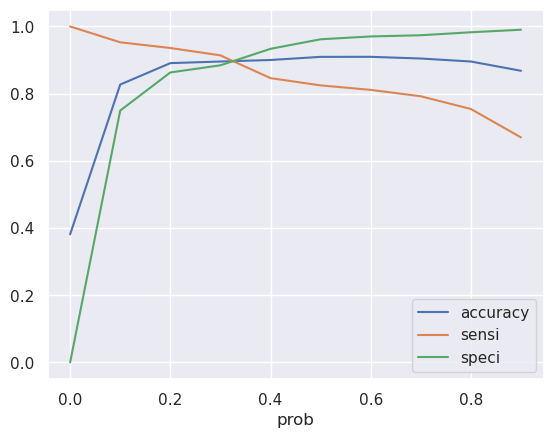

In [1717]:
# Let's plot accuracy sensitivity and specificity for various probabilities.
cutoff_df.plot.line(x='prob', y=['accuracy','sensi','speci'])
plt.show()

In [1718]:
y_train_pred_final['final_predicted'] = y_train_pred_final.Conv_Prob.map( lambda x: 1 if x > 0.34 else 0)
y_train_pred_final.head()

Converted   Conv_Prob    ID   predicted  0.000  0.100  0.200  0.300  \
0           0       0.004  7740           0      1      0      0      0   
1           1       0.968  7014           1      1      1      1      1   
2           0       0.005  2431           0      1      0      0      0   
3           1       0.981  3012           1      1      1      1      1   
4           0       0.070  3140           0      1      0      0      0   

   0.400  0.500  0.600  0.700  0.800  0.900   final_predicted  
0      0      0      0      0      0      0                 0  
1      1      1      1      1      1      1                 1  
2      0      0      0      0      0      0                 0  
3      1      1      1      1      1      1                 1  
4      0      0      0      0      0      0                 0

In [1719]:
# Let's check the overall accuracy.
accuracy_score(y_train_pred_final.Converted, y_train_pred_final.final_predicted)

0.8893161219445207

In [1720]:
confusion = confusion_matrix(y_train_pred_final.Converted, y_train_pred_final.final_predicted )
confusion

array([[4061,  445],
       [ 361, 2415]])

In [1721]:
TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives

# Calculate the sensitivity
TP/(TP+FN)

# Calculate the specificity
TN/(TN+FP)

0.8699567723342939

0.901242787394585

#### ROC Curve and Precision - Recall Curve

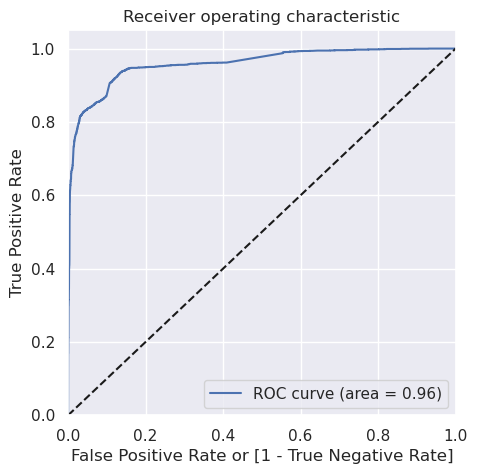

In [1722]:
def draw_roc( actual, probs ):
    fpr, tpr, thresholds = roc_curve( actual, probs, drop_intermediate = False )
    auc_score = roc_auc_score( actual, probs )
    plt.figure(figsize=(5, 5))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()
    return None

fpr, tpr, thresholds = roc_curve( y_train_pred_final.Converted, y_train_pred_final.Conv_Prob, drop_intermediate = False )
draw_roc(y_train_pred_final.Converted, y_train_pred_final.Conv_Prob)

In [1723]:
precision_score(y_train_pred_final.Converted, y_train_pred_final.predicted)
recall_score(y_train_pred_final.Converted, y_train_pred_final.predicted)

0.9301097114993905

0.8245677233429395

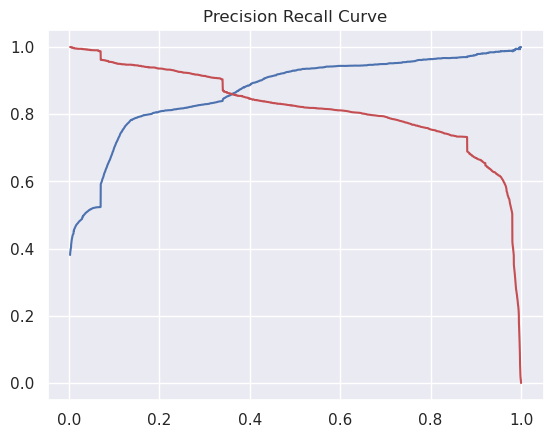

In [1724]:
p, r, thresholds = precision_recall_curve(y_train_pred_final.Converted, y_train_pred_final.Conv_Prob)
plt.plot(thresholds, p[:-1], "b")
plt.plot(thresholds, r[:-1], "r")
plt.title('Precision Recall Curve')
plt.show();

In [1725]:
y_train_pred_final['final_predicted'] = y_train_pred_final.Conv_Prob.map( lambda x: 1 if x > 0.37 else 0)
y_train_pred_final.head()

Converted   Conv_Prob    ID   predicted  0.000  0.100  0.200  0.300  \
0           0       0.004  7740           0      1      0      0      0   
1           1       0.968  7014           1      1      1      1      1   
2           0       0.005  2431           0      1      0      0      0   
3           1       0.981  3012           1      1      1      1      1   
4           0       0.070  3140           0      1      0      0      0   

   0.400  0.500  0.600  0.700  0.800  0.900   final_predicted  
0      0      0      0      0      0      0                 0  
1      1      1      1      1      1      1                 1  
2      0      0      0      0      0      0                 0  
3      1      1      1      1      1      1                 1  
4      0      0      0      0      0      0                 0

In [1726]:
# Let's check the overall accuracy.
accuracy_score(y_train_pred_final.Converted, y_train_pred_final.final_predicted)

0.8950837681955507

In [1727]:
confusion = confusion_matrix(y_train_pred_final.Converted, y_train_pred_final.final_predicted )
confusion

array([[4141,  365],
       [ 399, 2377]])

In [1728]:
TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives

# Calculate the sensitivity
TP/(TP+FN)

# Calculate the specificity
TN/(TN+FP)

precision_score(y_train_pred_final.Converted, y_train_pred_final.predicted)
recall_score(y_train_pred_final.Converted, y_train_pred_final.predicted)

0.8562680115273775

0.9189968930315136

0.9301097114993905

0.8245677233429395

###  ----------------------------------------------------------------------

### Predictions on the test set

##### Custom Functions for Test

In [1729]:
def logreg_test_pred_fn(fX_test, fy_test, fcol, fcutoff, fres):
    fX_test_sm = sm.add_constant(fX_test[fcol])
    fy_test_pred = fres.predict(fX_test_sm)
    fy_test_pred = fy_test_pred.values.reshape(-1)
    fy_test_pred_final = pd.DataFrame({'Converted':fy_test.values, 'Conv_Prob':fy_test_pred})
    fy_test_pred_final['ID'] = fy_test.index
    fy_test_pred_final['predicted'] = fy_test_pred_final.Conv_Prob.map(lambda x: 1 if x > fcutoff else 0)
    return fres, fy_test_pred,fy_test_pred_final

def logreg_test_metrics_fn(fy_test_pred_final):
    fconfusion = confusion_matrix(fy_test_pred_final.Converted, fy_test_pred_final.predicted )
    faccuracy = accuracy_score(fy_test_pred_final.Converted, fy_test_pred_final.predicted)
    return fconfusion, faccuracy
    
def logreg_test_VIF_score_fn(fX_test, fcol):
    fvif = pd.DataFrame()
    fvif['Features'] = fX_test[fcol].columns
    fvif['VIF'] = [variance_inflation_factor(fX_test[fcol].values, i) for i in 
                   range(fX_test[fcol].shape[1])]
    fvif['VIF'] = round(fvif['VIF'], 2)
    fvif = fvif.sort_values(by = "VIF", ascending = False)
    return fvif

#### Model Validation on Test Data

In [1730]:
X_test[to_scale] = scaler.transform(X_test[to_scale])
X_test[col].head()

ttime_on_site  last_activity_SMS Sent  lead_source_Welingak Website  \
7421          0.093                   0.000                         0.000   
4570          0.116                   1.000                         0.000   
5302          0.000                   0.000                         0.000   
6471          0.143                   1.000                         0.000   
8958          0.385                   0.000                         0.000   

      tags_Already a student  tags_Closed by Horizzon  \
7421                   0.000                    1.000   
4570                   0.000                    0.000   
5302                   0.000                    0.000   
6471                   0.000                    0.000   
8958                   1.000                    0.000   

      tags_Interested  in full time MBA  tags_Interested in other courses  \
7421                              0.000                             0.000   
4570                              0.000                             0.000   
5302                              0.000                             0.000   
6471                              0.000                             0.000   
8958                              0.000                             0.000   

      tags_Lost to EINS  tags_Not doing further education  tags_Ringing  \
7421              0.000                             0.000         0.000   
4570              0.000                             0.000         0.000   
5302              0.000                             0.000         0.000   
6471              0.000                             0.000         0.000   
8958              0.000                             0.000         0.000   

      tags_Will revert after reading the email  tags_invalid number  \
7421                                     0.000                0.000   
4570                                     0.000                0.000   
5302                                     0.000                0.000   
6471                                     0.000                0.000   
8958                                     0.000                0.000   

      tags_switched off  
7421              0.000  
4570              0.000  
5302              0.000  
6471              1.000  
8958              0.000

In [1731]:
cutoff = 0.37
res, y_test_pred, y_test_pred_final = logreg_test_pred_fn(X_test, y_test, col, cutoff, res)
confusion, accuracy = logreg_test_metrics_fn(y_test_pred_final)
vif = logreg_test_VIF_score_fn(X_test, col)

print('Model Summary:')          # Model Summary:
res.summary()
print('\nVIF Score:')            # VIF Score:
vif

# print('\nY_Predicted Values:')   # Y_Predicted Values:
# y_test_pred
# print('\nY_Predicted Cutoff:')   # Y_Predicted Cutoff:
# y_test_pred_final

Model Summary:


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              converted   No. Observations:                 7282
Model:                            GLM   Df Residuals:                     7268
Model Family:                Binomial   Df Model:                           13
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1677.1
Date:                Sun, 20 Oct 2024   Deviance:                       3354.3
Time:                        23:04:35   Pearson chi2:                 7.86e+03
No. Iterations:                     8   Pseudo R-squ. (CS):             0.5805
Covariance Type:            nonrobust                                         
============================================================================================================
                                               coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------
const                                       -2.5895      0.079    -32.593      0.000      -2.745      -2.434
ttime_on_site                                3.3369      0.185     18.080      0.000       2.975       3.699
last_activity_SMS Sent                       1.9243      0.096     20.103      0.000       1.737       2.112
lead_source_Welingak Website                 5.9866      1.015      5.897      0.000       3.997       7.976
tags_Already a student                      -3.4670      0.714     -4.856      0.000      -4.866      -2.068
tags_Closed by Horizzon                      6.7048      0.715      9.379      0.000       5.304       8.106
tags_Interested  in full time MBA           -2.3393      0.750     -3.120      0.002      -3.809      -0.870
tags_Interested in other courses            -2.0230      0.310     -6.519      0.000      -2.631      -1.415
tags_Lost to EINS                            5.0457      0.518      9.733      0.000       4.030       6.062
tags_Not doing further education            -3.1410      1.011     -3.107      0.002      -5.122      -1.160
tags_Ringing                                -2.8475      0.204    -13.985      0.000      -3.247      -2.448
tags_Will revert after reading the email     4.5883      0.158     29.075      0.000       4.279       4.898
tags_invalid number                         -3.3843      1.070     -3.162      0.002      -5.482      -1.286
tags_switched off                           -3.2113      0.518     -6.196      0.000      -4.227      -2.196
============================================================================================================
"""


VIF Score:


Features   VIF
0                              ttime_on_site 1.730
10  tags_Will revert after reading the email 1.590
1                     last_activity_SMS Sent 1.550
9                               tags_Ringing 1.110
2               lead_source_Welingak Website 1.040
7                          tags_Lost to EINS 1.040
4                    tags_Closed by Horizzon 1.030
12                         tags_switched off 1.030
3                     tags_Already a student 1.020
6           tags_Interested in other courses 1.020
5          tags_Interested  in full time MBA 1.010
8           tags_Not doing further education 1.010
11                       tags_invalid number 1.010

In [1732]:
print('\nConfusion Matrix:')     # Confusion Matrix: 
confusion
print(f'\nAccuracy Score: {accuracy}\n')  # Accuracy Score:


Confusion Matrix:


array([[1045,  100],
       [  76,  600]])


Accuracy Score: 0.9033498077979132



In [1733]:
TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives

# Calculate the sensitivity
TP/(TP+FN)

# Calculate the specificity
TN/(TN+FP)

precision_score(y_train_pred_final.Converted, y_train_pred_final.predicted)
recall_score(y_train_pred_final.Converted, y_train_pred_final.predicted)

0.8875739644970414

0.9126637554585153

0.9301097114993905

0.8245677233429395

## Approach - 03 - Accuracy Score:

In [1734]:
print(f'\nAccuracy Score: {accuracy}\n')  # Accuracy Score:


Accuracy Score: 0.9033498077979132



## ------------------------------------------------------

#### Cross Validation Testing

In [1735]:
logreg = LogisticRegression()
res = logreg.fit(X_train[col],y_train)

scores = cross_val_score(res, X_train[col], y_train, cv=5, scoring='accuracy')
np.sqrt(np.abs(scores))
scores = cross_val_score(res, X_test[col], y_test, cv=5, scoring='accuracy')
np.sqrt(np.abs(scores))

array([0.95398597, 0.96258061, 0.94563776, 0.95790522, 0.94962399])

array([0.97080675, 0.96076892, 0.96076892, 0.96504854, 0.95070824])